In [3]:
import os, copy
import numpy as NP
import numpy.linalg as LA
import scipy.optimize as OPT
import astropy.constants as FCNST
from astropy import units as U
from astropy.io import fits
from astropy.coordinates import SkyCoord
from astropy.wcs import WCS
from astropy.modeling import models, fitting
import matplotlib as MPL
import matplotlib.pyplot as PLT
from matplotlib.patches import Arc, RegularPolygon
from mpl_toolkits.axes_grid1.inset_locator import mark_inset, InsetPosition
from astroutils import geometry as GEOM
try:
    from pyuvdata import UVData
except ImportError:
    pyuvdata_found = False
else:
    pyuvdata_found = True

from IPython.core.debugger import set_trace
%matplotlib notebook

os.environ["PATH"] += os.pathsep + '/opt/local/bin/'

MPL.rcParams['xtick.direction'] = 'in'
MPL.rcParams['ytick.direction'] = 'in'

MPL.rc('text', usetex=True)
# MPL.rc('text.latex',unicode=True)
MPL.rc('font', **{'size': 12,'family': 'serif', 'serif': ['Computer Modern']})

# Define some useful functions

In [2]:
def gaussian2D_without_offset((x, y), amplitude, xo, yo, sigma_x, sigma_y, theta):
    xo = float(xo)
    yo = float(yo)    
    a = (NP.cos(theta)**2)/(2*sigma_x**2) + (NP.sin(theta)**2)/(2*sigma_y**2)
    b = -(NP.sin(2*theta))/(4*sigma_x**2) + (NP.sin(2*theta))/(4*sigma_y**2)
    c = (NP.sin(theta)**2)/(2*sigma_x**2) + (NP.cos(theta)**2)/(2*sigma_y**2)
    g = amplitude*NP.exp( - (a*((x-xo)**2) + 2*b*(x-xo)*(y-yo) + c*((y-yo)**2)))
    return g.ravel()

def gaussian2D_with_offset((x, y), amplitude, xo, yo, sigma_x, sigma_y, theta, offset):
    xo = float(xo)
    yo = float(yo)    
    a = (NP.cos(theta)**2)/(2*sigma_x**2) + (NP.sin(theta)**2)/(2*sigma_y**2)
    b = -(NP.sin(2*theta))/(4*sigma_x**2) + (NP.sin(2*theta))/(4*sigma_y**2)
    c = (NP.sin(theta)**2)/(2*sigma_x**2) + (NP.cos(theta)**2)/(2*sigma_y**2)
    g = offset + amplitude*NP.exp( - (a*((x-xo)**2) + 2*b*(x-xo)*(y-yo) + c*((y-yo)**2)))
    return g.ravel()

In [3]:
# def generate_parallel_lines_at_distance_from_line(coeffs, dvects, distances):
#     """
#     -------------------------------------------------------------------------
#     Given a set of equations of lines using coeff (dot) xyvect = dvect, find
#     new dvects such that the new lines are at the specified distances from 
#     the original lines. For each input line, two values of output dvects are
#     returned corresponding to the positive and negative distances.
    
#     Inputs:
    
#     coeffs      [numpy array] Array of shape (N,2) or (1,2) specifying the 
#                 x and y coefficients of the N (or 1) lines.
                
#     dvects      [scalar or numpy array] Array of shape (N,) or (1,) or scalar
#                 specifying the dvect of the input lines corresponding to 
#                 input coeffs.
                
#     distances   [scalar or numpy array] Array of shape (N,) or (1,) or scalar
#                 specifying the distances from the corresponding lines given
#                 by coeffs and dvect. 
                
#     Output:
    
#     Output dvect array of shape (N,2) where [:,0] corresponds to negative
#     distance offsets, and [:,1] corresponds to positive distance offsets from
#     the original input lines. The coeffs remain the same as the slope is 
#     unchanged. If any of the inputs coeffs, dvects, or distances have only
#     1 inputs, then they are assumed to apply to all the N inputs and are 
#     broadcasted. 
#     -------------------------------------------------------------------------
#     """
    
#     if not isinstance(coeffs, NP.ndarray):
#         raise TypeError('Input coeffs must be a numpy array')
#     if isinstance(dvects, (int,float)):
#         dvects = NP.asarray(dvects).reshape(-1)
#     if isinstance(distances, (int,float)):
#         distanes = NP.asarray(distances).reshape(-1)
#     if not isinstance(dvects, NP.ndarray):
#         raise TypeError('Input dvects must be a numpy array')
#     if not isinstance(distances, NP.ndarray):
#         raise TypeError('Input distances must be a numpy array')
#     if coeffs.size == 2:
#         coeffs = coeffs.reshape(-1,2)
#     if coeffs.ndim != 2:
#         raise ValueError('Input coeffs must be a 2D numpy array')
#     if coeffs.shape[1] != 2:
#         raise ValueError('Input coeffs must be a Nx2 array')
        
#     dvects = dvects.reshape(-1)
#     distances = NP.abs(distances).reshape(-1)
    
#     n_dvects = dvects.size
#     n_distances = distances.size
#     n_coeffs = coeffs.shape[0]
    
#     if (n_dvects != n_distances) and ((n_dvects != 1) and (n_distances != 1)):
#         raise ValueError('Inputs dvects and distances must be equal in size or broadcastable')
#     if (n_dvects != n_coeffs) and ((n_dvects != 1) and (n_coeffs != 1)):
#         raise ValueError('Inputs dvects and number of coeffs must be equal in size or broadcastable')
#     if (n_distances != n_coeffs) and ((n_distances != 1) and (n_coeffs != 1)):
#         raise ValueError('Inputs distances and number of coeffs must be equal in size or broadcastable')
        
#     n_max = NP.max([n_coeffs, n_dvects, n_distances])
#     coeffs = coeffs + NP.zeros((n_max,2), dtype=NP.float)
#     dvects = dvects + NP.zeros(n_max, dtype=NP.float)
#     distances = distances + NP.zeros(n_max, dtype=NP.float)
    
#     pm_distances = NP.asarray([-1.0, 1.0]).reshape(1,2) * distances.reshape(-1,1)
    
#     dvects_out_pm = dvects.reshape(-1,1) + pm_distances * NP.sqrt(NP.sum(coeffs**2, axis=1, keepdims=True))
    
#     return dvects_out_pm

## Perform some IERS related adjustments

In [4]:
from astropy.utils import iers

default_iers_auto_url = 'http://maia.usno.navy.mil/ser7/finals2000A.all'
secondary_iers_auto_url = 'ftp://cddis.gsfc.nasa.gov/pub/products/iers/finals2000A.all'

try:    
#     iers.conf.iers_auto_url = default_iers_auto_url
    iers.conf.remote_timeout = 100.0
    iers.IERS_A.open(iers.IERS_A_URL)
except Exception as err:
    if ('url' in str(err).lower()) or (('connection' in str(err).lower())):
        print(err)
        print('Original source URL for IERS_A: {0} failed!'.format(iers.conf.iers_auto_url))
        print('Original IERS Configuration:')
        print(iers.conf.__class__.__dict__)
        print('Modifying the source URL for IERS_A table to {0}'.format(secondary_iers_auto_url))
#         iers.IERS_A_URL = 'ftp://cddis.gsfc.nasa.gov/pub/products/iers/finals2000A.all'
        iers.conf.auto_download = True
        iers.conf.iers_auto_url = secondary_iers_auto_url
#         iers.conf.iers_auto_url = 'ftp://cddis.gsfc.nasa.gov/pub/products/iers/finals2000A.all'
        try:
            print('Now testing {0}'.format(secondary_iers_auto_url))
            iers_a = iers.IERS_A.open(secondary_iers_auto_url)
        except Exception as newerr:
            if ('url' in str(err).lower()):
                print(newerr)
                print('Modified URL also did not work. Computation of LST may be affected or will completely fail.')
#                 raise newerr
        else:
            print('Updated source URL {0} worked!'.format(secondary_iers_auto_url))
            print('Modified IERS Configuration:')
            print(iers.conf.__class__.__dict__)

<urlopen error timed out>
Original source URL for IERS_A: http://maia.usno.navy.mil/ser7/finals2000A.all failed!
Original IERS Configuration:
{'__module__': 'astropy.utils.iers.iers', 'auto_download': <ConfigItem: name='auto_download' value=True at 0x7f7a203d9b50>, 'iers_auto_url': <ConfigItem: name='iers_auto_url' value=u'http://maia.usno.navy.mil/ser7/finals2000A.all' at 0x7f7a2c243490>, 'remote_timeout': <ConfigItem: name='remote_timeout' value=100.0 at 0x7f7a1fb4a590>, 'auto_max_age': <ConfigItem: name='auto_max_age' value=30.0 at 0x7f7a2c2434d0>, '__doc__': u'\n    Configuration parameters for `astropy.utils.iers`.\n    '}
Modifying the source URL for IERS_A table to ftp://cddis.gsfc.nasa.gov/pub/products/iers/finals2000A.all
Now testing ftp://cddis.gsfc.nasa.gov/pub/products/iers/finals2000A.all
<urlopen error ftp error: timed out>
Modified URL also did not work. Computation of LST may be affected or will completely fail.


# Set up folders

In [5]:
projectdir = '/lustre/aoc/users/nthyagar/projects/CPhaseGeom/'
datadir = projectdir + 'data/'
figdir = projectdir + 'figures/'

# Set up the antenna and baseline variables

In [6]:
# Antenna locations, baseline vectors, wavelength, and spatial frequencies

antpos = NP.asarray([[0.0, 2.0], [85.0, -25.0], [40.0, 25.0]]) * U.m
blvect = NP.roll(antpos, -1, axis=0) - antpos
# blvect = NP.asarray([[antpos[(a+1)%len(antpos)].to('m').value - antpos[a].to('m').value] for a in range(len(antpos))]) * U.m 
wl = 21.0 * U.cm
uvvect = blvect / wl

In [7]:
print(antpos.shape)
print(NP.roll(antpos, -1, axis=0))
print(blvect)
print(uvvect.decompose().value)
print(NP.sqrt(NP.sum(uvvect**2, axis=1)).decompose().value)
print(1/NP.sqrt(NP.sum(uvvect**2, axis=1)).decompose().value)

(3, 2)
[[ 85. -25.]
 [ 40.  25.]
 [  0.   2.]] m
[[ 85. -27.]
 [-45.  50.]
 [-40. -23.]] m
[[ 404.76190476 -128.57142857]
 [-214.28571429  238.0952381 ]
 [-190.47619048 -109.52380952]]
[424.69143127 320.32438207 219.71946657]
[0.00235465 0.00312184 0.00455126]


# Plot antenna, baseline locations

<IPython.core.display.Javascript object>


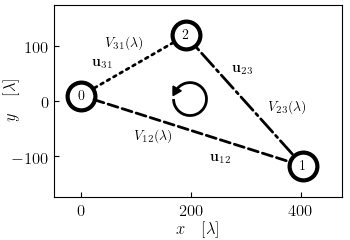

In [12]:
circle_radius = 30.0
theta_start = 180.0
theta_end = 150.0
centX = NP.mean((antpos[:,0]/wl).decompose().value)
centY = NP.mean((antpos[:,1]/wl).decompose().value)
endX=centX+circle_radius*NP.cos(NP.radians(theta_end)) #Do trig to determine end position
endY=centY+circle_radius*NP.sin(NP.radians(theta_end))

circle = Arc([centX, centY], 2*circle_radius, 2*circle_radius, angle=0, theta1=theta_start, theta2=theta_end, color='black', linewidth=2)
arrowhead = RegularPolygon(
        (endX, endY),            # (x,y)
        3,                       # number of vertices
        circle_radius/3,                # radius
        NP.radians(theta_end),     # orientation
        color='black'
    )

ls = ['--', '-.', ':']
# ls = [(0, (5, 10)), (0, (3, 10, 1, 10)), (0, (1, 10))]

fig = PLT.figure(figsize=(3.5,2.4))
ax = fig.add_subplot(111)
ax.plot((antpos[:,0]/wl).decompose().value, (antpos[:,1]/wl).decompose().value, ls='none', marker='o', ms=20, mew=3, mec='black', mfc='none')
ax.annotate('2', xy=((antpos[0,0]/wl).decompose().value, (antpos[0,1]/wl).decompose().value), xytext=((antpos[2,0]/wl).decompose().value, (antpos[2,1]/wl).decompose().value), xycoords='data', textcoords='data', ha='center', va='center', fontsize=10, arrowprops={'arrowstyle': '-', 'ls': ls[2], 'lw': 2, 'fc': 'black', 'ec': 'black', 'shrinkA': 5, 'shrinkB': 10})
ax.annotate('0', xy=((antpos[1,0]/wl).decompose().value, (antpos[1,1]/wl).decompose().value), xytext=((antpos[0,0]/wl).decompose().value, (antpos[0,1]/wl).decompose().value), xycoords='data', textcoords='data', ha='center', va='center', fontsize=10, arrowprops={'arrowstyle': '-', 'ls': ls[0], 'lw': 2, 'fc': 'black', 'ec': 'black', 'shrinkA': 5, 'shrinkB': 10})
ax.annotate('1', xy=((antpos[2,0]/wl).decompose().value, (antpos[2,1]/wl).decompose().value), xytext=((antpos[1,0]/wl).decompose().value, (antpos[1,1]/wl).decompose().value), xycoords='data', textcoords='data', ha='center', va='center', fontsize=10, arrowprops={'arrowstyle': '-', 'ls': ls[1], 'lw': 2, 'fc': 'black', 'ec': 'black', 'shrinkA': 5, 'shrinkB': 10})
# ax.text(-10+0.5*((antpos[0,0]+antpos[1,0])/wl).decompose().value, -20+0.5*((antpos[0,1]+antpos[1,1])/wl).decompose().value, r'$V_{12}(\lambda)$', ha='center', va='top', fontsize=10, color='black')
# ax.text(10+0.5*((antpos[1,0]+antpos[2,0])/wl).decompose().value, 20+0.5*((antpos[1,1]+antpos[2,1])/wl).decompose().value, r'$V_{23}(\lambda)$', ha='left', va='center', fontsize=10, color='black')
# ax.text(-10+0.5*((antpos[2,0]+antpos[0,0])/wl).decompose().value, 20+0.5*((antpos[2,1]+antpos[0,1])/wl).decompose().value, r'$V_{31}(\lambda)$', ha='right', va='center', fontsize=10, color='black')
ax.text(-10+((0.65*antpos[0,0]+0.35*antpos[1,0])/wl).decompose().value, -20+((0.65*antpos[0,1]+0.35*antpos[1,1])/wl).decompose().value, r'$V_{12}(\lambda)$', ha='center', va='top', fontsize=10, color='black')
ax.text(10+((0.65*antpos[1,0]+0.35*antpos[2,0])/wl).decompose().value, 20+((0.65*antpos[1,1]+0.35*antpos[2,1])/wl).decompose().value, r'$V_{23}(\lambda)$', ha='left', va='center', fontsize=10, color='black')
ax.text(-10+((0.65*antpos[2,0]+0.35*antpos[0,0])/wl).decompose().value, 20+((0.65*antpos[2,1]+0.35*antpos[0,1])/wl).decompose().value, r'$V_{31}(\lambda)$', ha='right', va='center', fontsize=10, color='black')
ax.text(-10+((0.35*antpos[0,0]+0.65*antpos[1,0])/wl).decompose().value, -20+((0.35*antpos[0,1]+0.65*antpos[1,1])/wl).decompose().value, r'$\mathbf{u}_{12}$', ha='center', va='top', fontsize=10, color='black')
ax.text(10+((0.35*antpos[1,0]+0.65*antpos[2,0])/wl).decompose().value, 20+((0.35*antpos[1,1]+0.65*antpos[2,1])/wl).decompose().value, r'$\mathbf{u}_{23}$', ha='left', va='center', fontsize=10, color='black')
ax.text(-10+((0.35*antpos[2,0]+0.65*antpos[0,0])/wl).decompose().value, 20+((0.35*antpos[2,1]+0.65*antpos[0,1])/wl).decompose().value, r'$\mathbf{u}_{31}$', ha='right', va='center', fontsize=10, color='black')
ax.add_patch(circle)
ax.add_patch(arrowhead)
ax.set_aspect('equal')
ax.set_xlim(-50, 475)
ax.set_ylim(-175, 175)

fig.subplots_adjust(left=0.14, right=0.99, bottom=0.18, top=0.98)
ax.set_xlabel(r'$x \quad[\lambda]$', labelpad=0)
ax.set_ylabel(r'$y \quad[\lambda]$', labelpad=-5)

PLT.savefig(figdir+'antenna_positions_wavelengths.pdf', bbox_inches=0)

# Set up the interferometric variables (gains, visibilities, phases)

In [13]:
randseed = 51
rstate = NP.random.RandomState(randseed)
del_l = 0.00055 # Translation in l (originally 0.00025)
del_m = 0.0005 # translation in m (originally 0.0005)
gains_to_be_discarded = rstate.randn(antpos.shape[0]) + 1j * rstate.randn(antpos.shape[0])
skyvis = rstate.randn(blvect.shape[0]) + 1j * rstate.randn(blvect.shape[0])
# randseed = 51
# rstate = NP.random.RandomState(randseed)
gains = rstate.normal(loc=1.0, scale=0.3, size=antpos.shape[0]) * NP.exp(1j*rstate.uniform(low=-NP.pi, high=NP.pi, size=antpos.shape[0]))
measvis = gains.conj() * skyvis * NP.roll(gains, -1)
# transvis_cs = skyvis * (NP.cos(2*NP.pi*NP.dot(uvvect.decompose().value, NP.asarray([del_l, del_m]).reshape(-1,1))) - 1j * NP.sin(2*NP.pi*NP.dot(uvvect.decompose().value, NP.asarray([del_l, del_m]).reshape(-1,1))))
transvis = skyvis.reshape(-1) * NP.exp(1j*2*NP.pi*NP.dot(uvvect.decompose().value, NP.asarray([del_l, del_m]).reshape(-1,1)).reshape(-1))

In [14]:
skyvisphase = NP.angle(skyvis)
measvisphase = NP.angle(measvis)
transvisphase = NP.angle(transvis)

# Do not run, modify or delete the cell below below !!!

In [16]:
# print(NP.degrees(NP.angle(gains))) # [-63.52261343 -74.80736686 -19.65221894]
# print(gains) # [0.27556323-0.55324105j 0.32077683-1.18125513j 0.78400437-0.2799768j]
# print(skyvis) # [-0.35622969+2.58839995j -1.08855909-0.50565079j -0.3510177 -0.58430921j]
# print(skyvisphase) # [ 1.7075626  -2.70673476 -2.1117595 ]
# print(measvisphase) # [ 1.5106065  -1.74409583 -2.87744232]
# print(transvisphase) # [ 2.70240028 -2.69925478 -3.11407715]
# print(NP.angle(NP.exp(1j*(skyvisphase + NP.angle(NP.roll(gains,-1)) + NP.angle(gains.conj()))))) # [ 1.5106065  -1.74409583 -2.87744232]
# print(NP.sum(skyvisphase)) # -3.110931655360633
# print(NP.sum(measvisphase)) # -3.110931655360633
# print(NP.sum(transvisphase)) # -3.110931655360633

In [15]:
print(NP.degrees(NP.angle(gains))) 
print(gains)
print(skyvis)
print(skyvisphase)
print(measvisphase)
print(transvisphase)
print(NP.angle(NP.exp(1j*(skyvisphase + NP.angle(NP.roll(gains,-1)) + NP.angle(gains.conj())))))
print(NP.sum(skyvisphase))
print(NP.sum(measvisphase))
print(NP.sum(transvisphase))

[-63.52261343 -74.80736686 -19.65221894]
[0.27556323-0.55324105j 0.32077683-1.18125513j 0.78400437-0.2799768j ]
[-0.35622969+2.58839995j -1.08855909-0.50565079j -0.3510177 -0.58430921j]
[ 1.7075626  -2.70673476 -2.1117595 ]
[ 1.5106065  -1.74409583 -2.87744232]
[ 2.70240028 -2.69925478 -3.11407715]
[ 1.5106065  -1.74409583 -2.87744232]
-3.110931655360633
-3.110931655360633
-3.1109316553606328


# Set up fringe equations in the image plane

In [16]:
npts_fringe = 10001
maxharmonics = 5
harmonic_num = NP.arange(-maxharmonics, maxharmonics+1)
lvect = NP.linspace(-1.0, 1.0, npts_fringe)
mvect = NP.linspace(-1.0, 1.0, npts_fringe)
dl = lvect[1] - lvect[0]
dm = mvect[1] - mvect[0]
lgrid, mgrid = NP.meshgrid(lvect, mvect, indexing='xy')
lmgrid = NP.dstack((lgrid,mgrid))
# skyfringes = 2*NP.pi*NP.tensordot(uvect, lmgrid, axes=[1,2]) + skyvisphase.reshape(-1,1,1)
# measfringes = 2*NP.pi*NP.tensordot(uvect, lmgrid, axes=[1,2]) + measvisphase.reshape(-1,1,1)
# skyfringes_img = NP.exp(1j*2*NP.pi*NP.tensordot(uvvect.decompose().value, lmgrid, axes=[1,2]) + skyvisphase.reshape(-1,1,1))
# measfringes_img = NP.exp(1j*2*NP.pi*NP.tensordot(uvvect.decompose().value, lmgrid, axes=[1,2]) + measvisphase.reshape(-1,1,1))
skyfringes_img = NP.cos(2*NP.pi*NP.tensordot(uvvect.decompose().value, lmgrid, axes=[1,2]) + skyvisphase.reshape(-1,1,1)) + 1j * NP.sin(2*NP.pi*NP.tensordot(uvvect.decompose().value, lmgrid, axes=[1,2]) + skyvisphase.reshape(-1,1,1))
measfringes_img = NP.cos(2*NP.pi*NP.tensordot(uvvect.decompose().value, lmgrid, axes=[1,2]) + measvisphase.reshape(-1,1,1)) + 1j * NP.sin(2*NP.pi*NP.tensordot(uvvect.decompose().value, lmgrid, axes=[1,2]) + measvisphase.reshape(-1,1,1))
transfringes_img = NP.cos(2*NP.pi*NP.tensordot(uvvect.decompose().value, lmgrid, axes=[1,2]) + transvisphase.reshape(-1,1,1)) + 1j * NP.sin(2*NP.pi*NP.tensordot(uvvect.decompose().value, lmgrid, axes=[1,2]) + transvisphase.reshape(-1,1,1))
net_skyfringes_img = NP.sum(skyfringes_img, axis=0)
net_measfringes_img = NP.sum(measfringes_img, axis=0)
net_transfringes_img = NP.sum(transfringes_img, axis=0)
skyfringes_lines_m = -(skyvisphase.reshape(-1,1,1)/(2*NP.pi) + harmonic_num.reshape(1,-1,1) + uvvect[:,0].decompose().value.reshape(-1,1,1)*lvect.reshape(1,1,-1)) / uvvect[:,1].decompose().value.reshape(-1,1,1)
measfringes_lines_m = -(measvisphase.reshape(-1,1,1)/(2*NP.pi) + harmonic_num.reshape(1,-1,1) + uvvect[:,0].decompose().value.reshape(-1,1,1)*lvect.reshape(1,1,-1)) / uvvect[:,1].decompose().value.reshape(-1,1,1)
transfringes_lines_m = -(transvisphase.reshape(-1,1,1)/(2*NP.pi) + harmonic_num.reshape(1,-1,1) + uvvect[:,0].decompose().value.reshape(-1,1,1)*lvect.reshape(1,1,-1)) / uvvect[:,1].decompose().value.reshape(-1,1,1)

In [17]:
print(harmonic_num)
print(lvect)
print(lmgrid.shape)
print(skyfringes_img.real.max())
print(skyfringes_lines_m.shape)
print(skyfringes_lines_m.real.max())
print(skyfringes_lines_m.real.min())

[-5 -4 -3 -2 -1  0  1  2  3  4  5]
[-1.     -0.9998 -0.9996 ...  0.9996  0.9998  1.    ]
(10001, 10001, 2)
0.9999998273843677
(3, 11, 10001)
3.1891507805946286
-3.1849232934794447


In [18]:
coeffs = 2 * NP.pi * uvvect.decompose().value
skyvis_dvect = -skyvisphase
measvis_dvect = -measvisphase
transvis_dvect = -transvisphase
skyvis_points = GEOM.points_from_line2d_intersection(coeffs, skyvis_dvect, ravel=False)
measvis_points = GEOM.points_from_line2d_intersection(coeffs, measvis_dvect, ravel=False)
transvis_points = GEOM.points_from_line2d_intersection(coeffs, transvis_dvect, ravel=False)
print(skyvis_points)
print(measvis_points)
print(transvis_points)
skyvis_points_raveled = NP.asarray([skyvis_points[i,j,:] for i in range(skyvis_points.shape[0]) for j in range(i-1,-1,-1)])
measvis_points_raveled = NP.asarray([measvis_points[i,j,:] for i in range(measvis_points.shape[0]) for j in range(i-1,-1,-1)])
transvis_points_raveled = NP.asarray([transvis_points[i,j,:] for i in range(transvis_points.shape[0]) for j in range(i-1,-1,-1)])
print(skyvis_points_raveled)
print(measvis_points_raveled)
print(transvis_points_raveled)

[[[        nan         nan]
  [        nan         nan]
  [        nan         nan]]

 [[-0.00013541  0.00168745]
  [        nan         nan]
  [        nan         nan]]

 [[-0.0010604  -0.00122454]
  [-0.00184835  0.00014581]
  [        nan         nan]]]
[[[        nan         nan]
  [        nan         nan]
  [        nan         nan]]

 [[-0.00031319  0.00088397]
  [        nan         nan]
  [        nan         nan]]

 [[-0.00123817 -0.00202802]
  [-0.00202613 -0.00065767]
  [        nan         nan]]]
[[[        nan         nan]
  [        nan         nan]
  [        nan         nan]]

 [[-0.00068541  0.00118745]
  [        nan         nan]
  [        nan         nan]]

 [[-0.0016104  -0.00172454]
  [-0.00239835 -0.00035419]
  [        nan         nan]]]
[[-0.00013541  0.00168745]
 [-0.00184835  0.00014581]
 [-0.0010604  -0.00122454]]
[[-0.00031319  0.00088397]
 [-0.00202613 -0.00065767]
 [-0.00123817 -0.00202802]]
[[-0.00068541  0.00118745]
 [-0.00239835 -0.00035419]
 [-0.001

In [19]:
fringe_slopes = -uvvect[:,0].decompose().value / uvvect[:,1].decompose().value
perp_fringe_slopes = -1 / fringe_slopes
print(fringe_slopes)
print(perp_fringe_slopes)
perp_fringe_slopes_roll1 = NP.roll(perp_fringe_slopes, 1)
print(perp_fringe_slopes_roll1)

[ 3.14814815  0.9        -1.73913043]
[-0.31764706 -1.11111111  0.575     ]
[ 0.575      -0.31764706 -1.11111111]


In [20]:
skyvis_perp_fringe_eqns = GEOM.generate_line_from_point_and_slope(skyvis_points_raveled, perp_fringe_slopes_roll1)
measvis_perp_fringe_eqns = GEOM.generate_line_from_point_and_slope(measvis_points_raveled, perp_fringe_slopes_roll1)
transvis_perp_fringe_eqns = GEOM.generate_line_from_point_and_slope(transvis_points_raveled, perp_fringe_slopes_roll1)
origin = NP.zeros((uvvect.shape[0],2), dtype=NP.float)
origin_perp_fringe_eqns = GEOM.generate_line_from_point_and_slope(origin, perp_fringe_slopes_roll1)
coeffs_roll1 = NP.roll(coeffs, 1, axis=0)
skyvis_dvect_roll1 = NP.roll(skyvis_dvect, 1)
measvis_dvect_roll1 = NP.roll(measvis_dvect, 1)
transvis_dvect_roll1 = NP.roll(transvis_dvect, 1)
skyvis_perp_intersection_opp_fringe = NP.empty((skyvis_dvect.size,2))
skyvis_perp_intersection_opp_fringe.fill(NP.nan)
measvis_perp_intersection_opp_fringe = NP.empty((measvis_dvect.size,2))
measvis_perp_intersection_opp_fringe.fill(NP.nan)
transvis_perp_intersection_opp_fringe = NP.empty((transvis_dvect.size,2))
transvis_perp_intersection_opp_fringe.fill(NP.nan)

skyvis_origin_perp_intersection_opp_fringe = NP.empty((skyvis_dvect.size,2))
skyvis_origin_perp_intersection_opp_fringe.fill(NP.nan)
measvis_origin_perp_intersection_opp_fringe = NP.empty((measvis_dvect.size,2))
measvis_origin_perp_intersection_opp_fringe.fill(NP.nan)
transvis_origin_perp_intersection_opp_fringe = NP.empty((transvis_dvect.size,2))
transvis_origin_perp_intersection_opp_fringe.fill(NP.nan)

skyvis_perp_fringe_lines = []
skyvis_perp_dist2 = []
skyvis_origin_perp_dist = []
measvis_perp_fringe_lines = []
measvis_perp_dist2 = []
measvis_origin_perp_dist = []
transvis_perp_fringe_lines = []
transvis_perp_dist2 = []
transvis_origin_perp_dist = []

In [21]:
print(skyvis_perp_fringe_eqns)
print(measvis_perp_fringe_eqns)
print(transvis_perp_fringe_eqns)

[[-5.75000000e-01  1.00000000e+00  1.76531024e-03]
 [ 3.17647059e-01  1.00000000e+00 -4.41316063e-04]
 [ 1.11111111e+00  1.00000000e+00 -2.40276167e-03]]
[[-5.75000000e-01  1.00000000e+00  1.06405580e-03]
 [ 3.17647059e-01  1.00000000e+00 -1.30126313e-03]
 [ 1.11111111e+00  1.00000000e+00 -3.40376885e-03]]
[[-0.575       1.          0.00158156]
 [ 0.31764706  1.         -0.00111602]
 [ 1.11111111  1.         -0.00351387]]


In [22]:
for vertex_ind in range(skyvis_points_raveled.shape[0]):
    coeff_2x2 = NP.vstack((skyvis_perp_fringe_eqns[[vertex_ind],:2], coeffs_roll1[[vertex_ind]])) # Prepare coeffs for finding intersection between fringes and their perpendiculars
    skyvis_d2 = NP.hstack((skyvis_perp_fringe_eqns[vertex_ind,2], skyvis_dvect_roll1[vertex_ind]))
    measvis_d2 = NP.hstack((measvis_perp_fringe_eqns[vertex_ind,2], measvis_dvect_roll1[vertex_ind]))
    transvis_d2 = NP.hstack((transvis_perp_fringe_eqns[vertex_ind,2], transvis_dvect_roll1[vertex_ind]))
    
    skyvis_perp_intersection_opp_fringe[vertex_ind,:] = GEOM.points_from_line2d_intersection(coeff_2x2, skyvis_d2, ravel=False)[1,0,:]
    measvis_perp_intersection_opp_fringe[vertex_ind,:] = GEOM.points_from_line2d_intersection(coeff_2x2, measvis_d2, ravel=False)[1,0,:]
    transvis_perp_intersection_opp_fringe[vertex_ind,:] = GEOM.points_from_line2d_intersection(coeff_2x2, transvis_d2, ravel=False)[1,0,:]

    origin_coeff_2x2 = NP.vstack((origin_perp_fringe_eqns[[vertex_ind],:2], coeffs_roll1[[vertex_ind]]))
    skyvis_origin_d2 = NP.hstack((origin_perp_fringe_eqns[vertex_ind,2], skyvis_dvect_roll1[vertex_ind]))
    measvis_origin_d2 = NP.hstack((origin_perp_fringe_eqns[vertex_ind,2], measvis_dvect_roll1[vertex_ind]))
    transvis_origin_d2 = NP.hstack((origin_perp_fringe_eqns[vertex_ind,2], transvis_dvect_roll1[vertex_ind]))

    skyvis_origin_perp_intersection_opp_fringe[vertex_ind,:] = GEOM.points_from_line2d_intersection(origin_coeff_2x2, skyvis_origin_d2, ravel=False)[1,0,:]
    skyvis_perp_fringe_lines += [GEOM.get_ordinate_from_abscissa_on_line(skyvis_perp_fringe_eqns[vertex_ind,:2], skyvis_perp_fringe_eqns[vertex_ind,2], lvect)]
    measvis_origin_perp_intersection_opp_fringe[vertex_ind,:] = GEOM.points_from_line2d_intersection(origin_coeff_2x2, measvis_origin_d2, ravel=False)[1,0,:]
    measvis_perp_fringe_lines += [GEOM.get_ordinate_from_abscissa_on_line(measvis_perp_fringe_eqns[vertex_ind,:2], measvis_perp_fringe_eqns[vertex_ind,2], lvect)]
    transvis_origin_perp_intersection_opp_fringe[vertex_ind,:] = GEOM.points_from_line2d_intersection(origin_coeff_2x2, transvis_origin_d2, ravel=False)[1,0,:]
    transvis_perp_fringe_lines += [GEOM.get_ordinate_from_abscissa_on_line(transvis_perp_fringe_eqns[vertex_ind,:2], transvis_perp_fringe_eqns[vertex_ind,2], lvect)]

    skyvis_perp_dist2 += [(NP.dot(coeffs_roll1[vertex_ind,:], skyvis_points_raveled[vertex_ind,:]) - skyvis_dvect_roll1[vertex_ind]) / NP.sqrt(NP.sum(coeffs_roll1[vertex_ind,:]**2))]
    skyvis_origin_perp_dist += [(NP.dot(coeffs_roll1[vertex_ind,:], origin[vertex_ind,:]) - skyvis_dvect_roll1[vertex_ind]) / NP.sqrt(NP.sum(coeffs_roll1[vertex_ind,:]**2))]
    measvis_perp_dist2 += [(NP.dot(coeffs_roll1[vertex_ind,:], measvis_points_raveled[vertex_ind,:]) - measvis_dvect_roll1[vertex_ind]) / NP.sqrt(NP.sum(coeffs_roll1[vertex_ind,:]**2))]
    measvis_origin_perp_dist += [(NP.dot(coeffs_roll1[vertex_ind,:], origin[vertex_ind,:]) - measvis_dvect_roll1[vertex_ind]) / NP.sqrt(NP.sum(coeffs_roll1[vertex_ind,:]**2))]
    transvis_perp_dist2 += [(NP.dot(coeffs_roll1[vertex_ind,:], transvis_points_raveled[vertex_ind,:]) - transvis_dvect_roll1[vertex_ind]) / NP.sqrt(NP.sum(coeffs_roll1[vertex_ind,:]**2))]
    transvis_origin_perp_dist += [(NP.dot(coeffs_roll1[vertex_ind,:], origin[vertex_ind,:]) - transvis_dvect_roll1[vertex_ind]) / NP.sqrt(NP.sum(coeffs_roll1[vertex_ind,:]**2))]
    
skyvis_perp_dist1 = NP.sqrt(NP.sum((skyvis_points_raveled - skyvis_perp_intersection_opp_fringe)**2, axis=1))
skyvis_phase_offset1 = NP.sqrt(NP.sum(coeffs_roll1**2, axis=1)) * skyvis_perp_dist1 
skyvis_phase_offset1[skyvis_phase_offset1 >= NP.pi] -= 2*NP.pi
skyvis_phase_offset1[skyvis_phase_offset1 <= -NP.pi] += 2*NP.pi
measvis_perp_dist1 = NP.sqrt(NP.sum((measvis_points_raveled - measvis_perp_intersection_opp_fringe)**2, axis=1))
measvis_phase_offset1 = NP.sqrt(NP.sum(coeffs_roll1**2, axis=1)) * measvis_perp_dist1 
measvis_phase_offset1[measvis_phase_offset1 >= NP.pi] -= 2*NP.pi
measvis_phase_offset1[measvis_phase_offset1 <= -NP.pi] += 2*NP.pi
transvis_perp_dist1 = NP.sqrt(NP.sum((transvis_points_raveled - transvis_perp_intersection_opp_fringe)**2, axis=1))
transvis_phase_offset1 = NP.sqrt(NP.sum(coeffs_roll1**2, axis=1)) * transvis_perp_dist1 
transvis_phase_offset1[transvis_phase_offset1 >= NP.pi] -= 2*NP.pi
transvis_phase_offset1[transvis_phase_offset1 <= -NP.pi] += 2*NP.pi

skyvis_perp_dist2 = NP.asarray(skyvis_perp_dist2)
skyvis_phase_offset2 = skyvis_perp_dist2 * NP.sqrt(NP.sum(coeffs_roll1**2, axis=1))
skyvis_phase_offset2[skyvis_phase_offset2 >= NP.pi] -= 2*NP.pi
skyvis_phase_offset2[skyvis_phase_offset2 <= -NP.pi] += 2*NP.pi
measvis_perp_dist2 = NP.asarray(measvis_perp_dist2)
measvis_phase_offset2 = measvis_perp_dist2 * NP.sqrt(NP.sum(coeffs_roll1**2, axis=1))
measvis_phase_offset2[measvis_phase_offset2 >= NP.pi] -= 2*NP.pi
measvis_phase_offset2[measvis_phase_offset2 <= -NP.pi] += 2*NP.pi
transvis_perp_dist2 = NP.asarray(transvis_perp_dist2)
transvis_phase_offset2 = transvis_perp_dist2 * NP.sqrt(NP.sum(coeffs_roll1**2, axis=1))
transvis_phase_offset2[transvis_phase_offset2 >= NP.pi] -= 2*NP.pi
transvis_phase_offset2[transvis_phase_offset2 <= -NP.pi] += 2*NP.pi

skyvis_origin_perp_dist = NP.asarray(skyvis_origin_perp_dist)
skyvis_origin_phase_offset = skyvis_origin_perp_dist * NP.sqrt(NP.sum(coeffs_roll1**2, axis=1))
skyvis_origin_phase_offset[skyvis_origin_phase_offset >= NP.pi] -= 2*NP.pi
skyvis_origin_phase_offset[skyvis_origin_phase_offset <= -NP.pi] += 2*NP.pi
measvis_origin_perp_dist = NP.asarray(measvis_origin_perp_dist)
measvis_origin_phase_offset = measvis_origin_perp_dist * NP.sqrt(NP.sum(coeffs_roll1**2, axis=1))
measvis_origin_phase_offset[measvis_origin_phase_offset >= NP.pi] -= 2*NP.pi
measvis_origin_phase_offset[measvis_origin_phase_offset <= -NP.pi] += 2*NP.pi
transvis_origin_perp_dist = NP.asarray(transvis_origin_perp_dist)
transvis_origin_phase_offset = transvis_origin_perp_dist * NP.sqrt(NP.sum(coeffs_roll1**2, axis=1))
transvis_origin_phase_offset[transvis_origin_phase_offset >= NP.pi] -= 2*NP.pi
transvis_origin_phase_offset[transvis_origin_phase_offset <= -NP.pi] += 2*NP.pi

In [23]:
print(skyvis_perp_intersection_opp_fringe)
print(skyvis_perp_fringe_lines[0].shape)
print(skyvis_phase_offset1)
print(skyvis_phase_offset2)
print(skyvis_origin_phase_offset)
print(NP.sum(skyvis_origin_phase_offset))
print('------------')
print(measvis_perp_intersection_opp_fringe)
print(measvis_perp_fringe_lines[0].shape)
print(measvis_phase_offset1)
print(measvis_phase_offset2)
print(measvis_origin_phase_offset)
print(NP.sum(measvis_origin_phase_offset))
print('------------')
print(transvis_perp_intersection_opp_fringe)
print(transvis_perp_fringe_lines[0].shape)
print(transvis_phase_offset1)
print(transvis_phase_offset2)
print(transvis_origin_phase_offset)
print(NP.sum(transvis_origin_phase_offset))
print('------------')
print(transvis_perp_intersection_opp_fringe - skyvis_perp_intersection_opp_fringe) # To verify that the difference is identical to the input del_l and del_m 

[[-2.08891494e-03  5.64184151e-04]
 [-7.37221754e-04 -2.07139741e-04]
 [-2.09440471e-03 -7.56453252e-05]]
(10001,)
[3.11093166 3.11093166 3.11093166]
[-3.11093166 -3.11093166 -3.11093166]
[-2.1117595   1.7075626  -2.70673476]
-3.110931655360633
------------
[[-0.00226669 -0.00023929]
 [-0.000915   -0.00101062]
 [-0.00227218 -0.00087912]]
(10001,)
[3.11093166 3.11093166 3.11093166]
[-3.11093166 -3.11093166 -3.11093166]
[-2.87744232  1.5106065  -1.74409583]
-3.110931655360633
------------
[[-2.63891494e-03  6.41841506e-05]
 [-1.28722175e-03 -7.07139741e-04]
 [-2.64440471e-03 -5.75645325e-04]]
(10001,)
[3.11093166 3.11093166 3.11093166]
[-3.11093166 -3.11093166 -3.11093166]
[-3.11407715  2.70240028 -2.69925478]
-3.1109316553606323
------------
[[-0.00055 -0.0005 ]
 [-0.00055 -0.0005 ]
 [-0.00055 -0.0005 ]]


# Plot an illustration of interferometric fringes

<IPython.core.display.Javascript object>


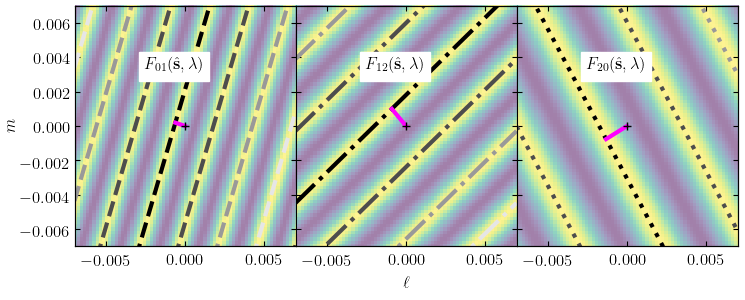

/lustre/aoc/users/nthyagar/projects/CPhaseGeom/figures/fringe_phase_illustration.pdf


In [25]:
ls = ['--', '-.', ':']
fig, axs = PLT.subplots(ncols=3, nrows=1, squeeze=True, sharex=True, sharey=True, figsize=(7.45,3))
for fringe_ind in range(uvvect.shape[0]):
    axs[fringe_ind].pcolorfast(lvect-0.5*dl, mvect-0.5*dm, skyfringes_img[fringe_ind,:-1,:-1].real, cmap='viridis', alpha=0.5)
    for harmonic_ind, harmonic in enumerate(harmonic_num):
        axs[fringe_ind].plot(lvect, skyfringes_lines_m[fringe_ind,harmonic_ind,:], ls=ls[fringe_ind], lw=3, color=str(0.3*NP.abs(harmonic)))
    axs[fringe_ind].plot(NP.asarray([origin[0,0], NP.roll(skyvis_origin_perp_intersection_opp_fringe, -1, axis=0)[fringe_ind,0]]), NP.asarray([origin[0,1], NP.roll(skyvis_origin_perp_intersection_opp_fringe, -1, axis=0)[fringe_ind,1]]), ls='-', lw=3, color='magenta')
    axs[fringe_ind].plot(0, 0, ls='none', marker='+', ms=6, color='black')
    axs[fringe_ind].set_xlim(-0.007,0.007)
    axs[fringe_ind].set_ylim(-0.007,0.007)
#     axs[fringe_ind].set_aspect('equal')
    axs[fringe_ind].tick_params(bottom=True, top=True, left=True, right=True)

axs[0].text(0.45, 0.75, r'$F_{01}(\hat{\mathbf{s}},\lambda)$', ha='center', va='center', transform=axs[0].transAxes, fontsize=12, color='black', backgroundcolor='white')
axs[1].text(0.45, 0.75, r'$F_{12}(\hat{\mathbf{s}},\lambda)$', ha='center', va='center', transform=axs[1].transAxes, fontsize=12, color='black', backgroundcolor='white')
axs[2].text(0.45, 0.75, r'$F_{20}(\hat{\mathbf{s}},\lambda)$', ha='center', va='center', transform=axs[2].transAxes, fontsize=12, color='black', backgroundcolor='white')

fig.subplots_adjust(hspace=0, wspace=0)
fig.subplots_adjust(left=0.1, right=0.99, top=0.98, bottom=0.18)

big_ax = fig.add_subplot(111)
big_ax.set_facecolor('none') # matplotlib.__version__ >= 2.0.0
# big_ax.set_axis_bgcolor('none') # matplotlib.__version__ < 2.0.0
big_ax.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
big_ax.set_xticks([])
big_ax.set_yticks([])
big_ax.set_xlabel(r'$\ell$', weight='medium', labelpad=20)
big_ax.set_ylabel(r'$m$', weight='medium', labelpad=40)

PLT.savefig(figdir+'fringe_phase_illustration.pdf', bbox_inches=0)
print(figdir+'fringe_phase_illustration.pdf')

In [26]:
# ls = ['--', '-.', ':']
# fig, axs = PLT.subplots(ncols=3, nrows=1, squeeze=True, sharex=True, sharey=True, figsize=(7.45,3))
# for fringe_ind in range(uvvect.shape[0]):
#     axs[fringe_ind].pcolorfast(lvect-0.5*dl, mvect-0.5*dm, skyfringes_img[fringe_ind,:-1,:-1].real, cmap='viridis', alpha=0.5)
#     for harmonic_ind, harmonic in enumerate(harmonic_num):
#         axs[fringe_ind].plot(lvect, skyfringes_lines_m[fringe_ind,harmonic_ind,:], ls=ls[fringe_ind], lw=3, color=str(0.3*NP.abs(harmonic)))
#     axs[fringe_ind].plot(NP.asarray([origin[0,0], NP.roll(skyvis_origin_perp_intersection_opp_fringe, -1, axis=0)[fringe_ind,0]]), NP.asarray([origin[0,1], NP.roll(skyvis_origin_perp_intersection_opp_fringe, -1, axis=0)[fringe_ind,1]]), ls='-', lw=3, color='magenta')
#     axs[fringe_ind].plot(0, 0, ls='none', marker='+', ms=6, color='black')
#     axs[fringe_ind].set_xlim(-0.007,0.007)
#     axs[fringe_ind].set_ylim(-0.007,0.007)
# #     axs[fringe_ind].set_aspect('equal')
#     axs[fringe_ind].tick_params(bottom=True, top=True, left=True, right=True)

# axs[0].text(0.45, 0.75, r'$F_{12}(\hat{\mathbf{s}},\lambda)$', ha='center', va='center', transform=axs[0].transAxes, fontsize=10, color='black', backgroundcolor='white')
# axs[1].text(0.45, 0.75, r'$F_{23}(\hat{\mathbf{s}},\lambda)$', ha='center', va='center', transform=axs[1].transAxes, fontsize=10, color='black', backgroundcolor='white')
# axs[2].text(0.45, 0.75, r'$F_{31}(\hat{\mathbf{s}},\lambda)$', ha='center', va='center', transform=axs[2].transAxes, fontsize=10, color='black', backgroundcolor='white')

# fig.subplots_adjust(hspace=0, wspace=0)
# fig.subplots_adjust(left=0.1, right=0.99, top=0.98, bottom=0.18)

# big_ax = fig.add_subplot(111)
# big_ax.set_facecolor('none') # matplotlib.__version__ >= 2.0.0
# # big_ax.set_axis_bgcolor('none') # matplotlib.__version__ < 2.0.0
# big_ax.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
# big_ax.set_xticks([])
# big_ax.set_yticks([])
# big_ax.set_xlabel(r'$l$', fontsize=10, weight='medium', labelpad=20)
# big_ax.set_ylabel(r'$m$', fontsize=10, weight='medium', labelpad=40)

# PLT.savefig(figdir+'fringe_phase_illustration.pdf', bbox_inches=0)
# print(figdir+'fringe_phase_illustration.pdf')

# Plot a detailed illustration of closure phase with all ideal fringes

<IPython.core.display.Javascript object>


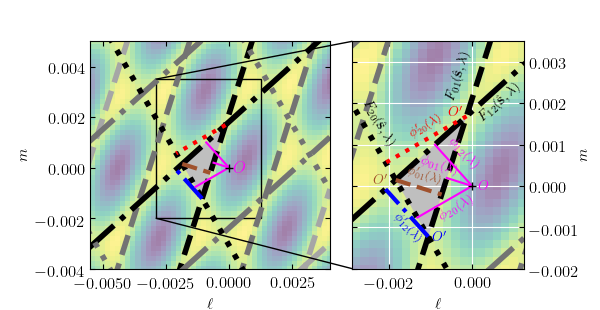

/lustre/aoc/users/nthyagar/projects/CPhaseGeom/figures/closure_phase_detailed_illustration.pdf


In [28]:
fig = PLT.figure(figsize=(6,3.1))
ax = fig.add_axes([0.15,0,0.4,1])
img = ax.pcolorfast(lvect-0.5*dl, mvect-0.5*dm, net_skyfringes_img[:-1,:-1].real, cmap='viridis', alpha=0.5)
ax.fill(skyvis_points_raveled[:,0], skyvis_points_raveled[:,1], fc='0.75')
ax.plot(lvect, skyfringes_lines_m[0,maxharmonics,:], ls='--', lw=4, color='black')
ax.plot(lvect, skyfringes_lines_m[0,maxharmonics+1,:], ls='--', lw=4, color='0.45')
ax.plot(lvect, skyfringes_lines_m[0,maxharmonics+2,:], ls='--', lw=4, color='0.65')
ax.plot(lvect, skyfringes_lines_m[0,maxharmonics-1,:], ls='--', lw=4, color='0.45')
ax.plot(lvect, skyfringes_lines_m[0,maxharmonics-2,:], ls='--', lw=4, color='0.65')
ax.plot(lvect, skyfringes_lines_m[1,maxharmonics,:], ls='-.', lw=4, color='black')
ax.plot(lvect, skyfringes_lines_m[1,maxharmonics+1,:], ls='-.', lw=4, color='0.45')
ax.plot(lvect, skyfringes_lines_m[1,maxharmonics+2,:], ls='-.', lw=4, color='0.65')
ax.plot(lvect, skyfringes_lines_m[1,maxharmonics-1,:], ls='-.', lw=4, color='0.45')
ax.plot(lvect, skyfringes_lines_m[1,maxharmonics-2,:], ls='-.', lw=4, color='0.65')
ax.plot(lvect, skyfringes_lines_m[2,maxharmonics,:], ls=':', lw=4, color='black')
ax.plot(lvect, skyfringes_lines_m[2,maxharmonics+1,:], ls=':', lw=4, color='0.45')
ax.plot(lvect, skyfringes_lines_m[2,maxharmonics+2,:], ls=':', lw=4, color='0.65')
ax.plot(lvect, skyfringes_lines_m[2,maxharmonics-1,:], ls=':', lw=4, color='0.45')
ax.plot(lvect, skyfringes_lines_m[2,maxharmonics-2,:], ls=':', lw=4, color='0.65')
ax.plot(NP.asarray([skyvis_points_raveled[0,0], skyvis_perp_intersection_opp_fringe[0,0]]), NP.asarray([skyvis_points_raveled[0,1], skyvis_perp_intersection_opp_fringe[0,1]]), ls=':', lw=3, color='red')
ax.plot(NP.asarray([skyvis_points_raveled[1,0], skyvis_perp_intersection_opp_fringe[1,0]]), NP.asarray([skyvis_points_raveled[1,1], skyvis_perp_intersection_opp_fringe[1,1]]), ls='--', lw=3, color='sienna')
ax.plot(NP.asarray([skyvis_points_raveled[2,0], skyvis_perp_intersection_opp_fringe[2,0]]), NP.asarray([skyvis_points_raveled[2,1], skyvis_perp_intersection_opp_fringe[2,1]]), ls='-.', lw=3, color='blue')
ax.plot(NP.asarray([origin[0,0], skyvis_origin_perp_intersection_opp_fringe[0,0]]), NP.asarray([origin[0,1], skyvis_origin_perp_intersection_opp_fringe[0,1]]), ls='-', lw=1.5, color='magenta')
ax.plot(NP.asarray([origin[1,0], skyvis_origin_perp_intersection_opp_fringe[1,0]]), NP.asarray([origin[1,1], skyvis_origin_perp_intersection_opp_fringe[1,1]]), ls='-', lw=1.5, color='magenta')
ax.plot(NP.asarray([origin[2,0], skyvis_origin_perp_intersection_opp_fringe[2,0]]), NP.asarray([origin[2,1], skyvis_origin_perp_intersection_opp_fringe[2,1]]), ls='-', lw=1.5, color='magenta')
ax.plot(0, 0, ls='none', marker='+', ms=6, color='black')
ax.text(0.00015, 0, r'$O$', ha='left', va='center', color='magenta', fontsize=12, weight='extra bold')
ax.tick_params(bottom=True, top=True, left=True, right=True)
ax.set_xlim(-0.0055,0.004)
ax.set_ylim(-0.004,0.005)
ax.set_aspect('equal')
# ax.grid(which='both', color='white')
ax.set_xlabel(r'$\ell$', weight='medium', fontsize=11)
ax.set_ylabel(r'$m$', weight='medium', fontsize=11)

axins = fig.add_axes([0.45,0,0.45,1])
# Manually set the position and relative size of the inset axes within ax1
inpos = InsetPosition(ax, [1.05,0.0,0.8,1.0])
axins.set_axes_locator(inpos)
# Mark the region corresponding to the inset axes on ax1 and draw lines
# in black linking the two axes.
mark_inset(ax, axins, loc1=2, loc2=3, fc='none', ec='black')

axins.pcolorfast(lvect-0.5*dl, mvect-0.5*dm, net_skyfringes_img[:-1,:-1].real, cmap='viridis', alpha=0.5)
axins.fill(skyvis_points_raveled[:,0], skyvis_points_raveled[:,1], fc='0.75')
axins.plot(lvect, skyfringes_lines_m[0,maxharmonics,:], ls='--', lw=4, color='black')
axins.plot(lvect, skyfringes_lines_m[0,maxharmonics+1,:], ls='--', lw=4, color='0.45')
axins.plot(lvect, skyfringes_lines_m[0,maxharmonics+2,:], ls='--', lw=4, color='0.65')
axins.plot(lvect, skyfringes_lines_m[0,maxharmonics-1,:], ls='--', lw=4, color='0.45')
axins.plot(lvect, skyfringes_lines_m[0,maxharmonics-2,:], ls='--', lw=4, color='0.65')
axins.plot(lvect, skyfringes_lines_m[1,maxharmonics,:], ls='-.', lw=4, color='black')
axins.plot(lvect, skyfringes_lines_m[1,maxharmonics+1,:], ls='-.', lw=4, color='0.45')
axins.plot(lvect, skyfringes_lines_m[1,maxharmonics+2,:], ls='-.', lw=4, color='0.65')
axins.plot(lvect, skyfringes_lines_m[1,maxharmonics-1,:], ls='-.', lw=4, color='0.45')
axins.plot(lvect, skyfringes_lines_m[1,maxharmonics-2,:], ls='-.', lw=4, color='0.65')
axins.plot(lvect, skyfringes_lines_m[2,maxharmonics,:], ls=':', lw=4, color='black')
axins.plot(lvect, skyfringes_lines_m[2,maxharmonics+1,:], ls=':', lw=4, color='0.45')
axins.plot(lvect, skyfringes_lines_m[2,maxharmonics+2,:], ls=':', lw=4, color='0.65')
axins.plot(lvect, skyfringes_lines_m[2,maxharmonics-1,:], ls=':', lw=4, color='0.45')
axins.plot(lvect, skyfringes_lines_m[2,maxharmonics-2,:], ls=':', lw=4, color='0.65')
axins.text(-6.5e-4, 2e-3, r'$F_{01}(\hat{\mathbf{s}},\lambda)$', ha='left', va='bottom', transform=axins.transData, fontsize=10, color='black', rotation=NP.degrees(NP.arctan(fringe_slopes[0])))
axins.text(1e-4, 2e-3, r'$F_{12}(\hat{\mathbf{s}},\lambda)$', ha='left', va='center', transform=axins.transData, fontsize=10, color='black', rotation=NP.degrees(NP.arctan(fringe_slopes[1])))
axins.text(-2.75e-3, 2.1e-3, r'$F_{20}(\hat{\mathbf{s}},\lambda)$', ha='left', va='top', transform=axins.transData, fontsize=10, color='black', rotation=NP.degrees(NP.arctan(fringe_slopes[2])))

axins.plot(NP.asarray([skyvis_points_raveled[0,0], skyvis_perp_intersection_opp_fringe[0,0]]), NP.asarray([skyvis_points_raveled[0,1], skyvis_perp_intersection_opp_fringe[0,1]]), ls=':', lw=3, color='red')
axins.plot(NP.asarray([skyvis_points_raveled[1,0], skyvis_perp_intersection_opp_fringe[1,0]]), NP.asarray([skyvis_points_raveled[1,1], skyvis_perp_intersection_opp_fringe[1,1]]), ls='--', lw=3, color='sienna')
axins.plot(NP.asarray([skyvis_points_raveled[2,0], skyvis_perp_intersection_opp_fringe[2,0]]), NP.asarray([skyvis_points_raveled[2,1], skyvis_perp_intersection_opp_fringe[2,1]]), ls='-.', lw=3, color='blue')
axins.text(0.5*(skyvis_points_raveled[0,0]+skyvis_perp_intersection_opp_fringe[0,0]), 3e-4+0.5*(skyvis_points_raveled[0,1]+skyvis_perp_intersection_opp_fringe[0,1]), r'$\phi_{20}^\prime(\lambda)$', ha='center', va='center', transform=axins.transData, fontsize=9, color='red', rotation=NP.degrees(NP.arctan(perp_fringe_slopes_roll1[0])))
axins.text(0.45*(skyvis_points_raveled[1,0]+skyvis_perp_intersection_opp_fringe[1,0]), 2.5e-4+0.5*(skyvis_points_raveled[1,1]+skyvis_perp_intersection_opp_fringe[1,1]), r'$\phi_{01}^\prime(\lambda)$', ha='center', va='center', transform=axins.transData, fontsize=9, color='sienna', rotation=NP.degrees(NP.arctan(perp_fringe_slopes_roll1[1])))
axins.text(0.5*(skyvis_points_raveled[2,0]+skyvis_perp_intersection_opp_fringe[2,0]), -4e-4+0.5*(skyvis_points_raveled[2,1]+skyvis_perp_intersection_opp_fringe[2,1]), r'$\phi_{12}^\prime(\lambda)$', ha='center', va='center', transform=axins.transData, fontsize=9, color='blue', rotation=NP.degrees(NP.arctan(perp_fringe_slopes_roll1[2])))

axins.plot(NP.asarray([origin[0,0], skyvis_origin_perp_intersection_opp_fringe[0,0]]), NP.asarray([origin[0,1], skyvis_origin_perp_intersection_opp_fringe[0,1]]), ls='-', lw=1.5, color='magenta')
axins.plot(NP.asarray([origin[1,0], skyvis_origin_perp_intersection_opp_fringe[1,0]]), NP.asarray([origin[1,1], skyvis_origin_perp_intersection_opp_fringe[1,1]]), ls='-', lw=1.5, color='magenta')
axins.plot(NP.asarray([origin[2,0], skyvis_origin_perp_intersection_opp_fringe[2,0]]), NP.asarray([origin[2,1], skyvis_origin_perp_intersection_opp_fringe[2,1]]), ls='-', lw=1.5, color='magenta')
axins.text(0.65*skyvis_origin_perp_intersection_opp_fringe[0,0], 2e-4+0.5*skyvis_origin_perp_intersection_opp_fringe[0,1], r'$\phi_{20}(\lambda)$', ha='left', va='top', transform=axins.transData, fontsize=10, color='magenta', rotation=NP.degrees(NP.arctan(perp_fringe_slopes_roll1[0])))
axins.text(0.5*skyvis_origin_perp_intersection_opp_fringe[1,0], 0.5e-4+0.5*skyvis_origin_perp_intersection_opp_fringe[1,1], r'$\phi_{01}(\lambda)$', ha='right', va='bottom', transform=axins.transData, fontsize=10, color='magenta', rotation=NP.degrees(NP.arctan(perp_fringe_slopes_roll1[1])))
axins.text(0.25*skyvis_origin_perp_intersection_opp_fringe[2,0], 2.5e-4+0.5*skyvis_origin_perp_intersection_opp_fringe[2,1], r'$\phi_{12}(\lambda)$', ha='center', va='center', transform=axins.transData, fontsize=10, color='magenta', rotation=NP.degrees(NP.arctan(perp_fringe_slopes_roll1[2])))

axins.plot(0, 0, ls='none', marker='+', ms=6, color='black')
axins.text(0.00015, 0, r'$O$', ha='left', va='center', color='magenta', fontsize=10, weight='extra bold')
axins.text(-1e-4+skyvis_points_raveled[0,0], 1e-4+skyvis_points_raveled[0,1], r'$O^\prime$', ha='right', va='center', color='red', fontsize=10, weight='extra bold')
axins.text(-0.0002+skyvis_points_raveled[1,0], skyvis_points_raveled[1,1], r'$O^\prime$', ha='right', va='center', color='sienna', fontsize=10, weight='extra bold')
axins.text(0.0001+skyvis_points_raveled[2,0], skyvis_points_raveled[2,1], r'$O^\prime$', ha='left', va='center', color='blue', fontsize=10, weight='extra bold')

axins.set_xlim(-0.0029,0.00125)
axins.set_ylim(-0.002,0.0035)
axins.set_aspect('equal')
axins.yaxis.tick_right()
axins.set_xlabel(r'$\ell$', weight='medium', fontsize=11)
axins.set_ylabel(r'$m$', weight='medium', fontsize=11, labelpad=-2.5)
axins.yaxis.set_label_position('right')
axins.grid(which='both', color='white')
axins.tick_params(bottom=True, top=True, left=True, right=True)

PLT.savefig(figdir+'closure_phase_detailed_illustration.pdf', bbox_inches=0)
print(figdir+'closure_phase_detailed_illustration.pdf')

In [35]:
# fig = PLT.figure(figsize=(6,3.1))
# ax = fig.add_axes([0.15,0,0.4,1])
# img = ax.pcolorfast(lvect-0.5*dl, mvect-0.5*dm, net_skyfringes_img[:-1,:-1].real, cmap='viridis', alpha=0.5)
# ax.fill(skyvis_points_raveled[:,0], skyvis_points_raveled[:,1], fc='0.75')
# ax.plot(lvect, skyfringes_lines_m[0,maxharmonics,:], ls='--', lw=4, color='black')
# ax.plot(lvect, skyfringes_lines_m[0,maxharmonics+1,:], ls='--', lw=4, color='0.45')
# ax.plot(lvect, skyfringes_lines_m[0,maxharmonics+2,:], ls='--', lw=4, color='0.65')
# ax.plot(lvect, skyfringes_lines_m[0,maxharmonics-1,:], ls='--', lw=4, color='0.45')
# ax.plot(lvect, skyfringes_lines_m[0,maxharmonics-2,:], ls='--', lw=4, color='0.65')
# ax.plot(lvect, skyfringes_lines_m[1,maxharmonics,:], ls='-.', lw=4, color='black')
# ax.plot(lvect, skyfringes_lines_m[1,maxharmonics+1,:], ls='-.', lw=4, color='0.45')
# ax.plot(lvect, skyfringes_lines_m[1,maxharmonics+2,:], ls='-.', lw=4, color='0.65')
# ax.plot(lvect, skyfringes_lines_m[1,maxharmonics-1,:], ls='-.', lw=4, color='0.45')
# ax.plot(lvect, skyfringes_lines_m[1,maxharmonics-2,:], ls='-.', lw=4, color='0.65')
# ax.plot(lvect, skyfringes_lines_m[2,maxharmonics,:], ls=':', lw=4, color='black')
# ax.plot(lvect, skyfringes_lines_m[2,maxharmonics+1,:], ls=':', lw=4, color='0.45')
# ax.plot(lvect, skyfringes_lines_m[2,maxharmonics+2,:], ls=':', lw=4, color='0.65')
# ax.plot(lvect, skyfringes_lines_m[2,maxharmonics-1,:], ls=':', lw=4, color='0.45')
# ax.plot(lvect, skyfringes_lines_m[2,maxharmonics-2,:], ls=':', lw=4, color='0.65')
# ax.plot(NP.asarray([skyvis_points_raveled[0,0], skyvis_perp_intersection_opp_fringe[0,0]]), NP.asarray([skyvis_points_raveled[0,1], skyvis_perp_intersection_opp_fringe[0,1]]), ls=':', lw=3, color='red')
# ax.plot(NP.asarray([skyvis_points_raveled[1,0], skyvis_perp_intersection_opp_fringe[1,0]]), NP.asarray([skyvis_points_raveled[1,1], skyvis_perp_intersection_opp_fringe[1,1]]), ls='--', lw=3, color='darkgreen')
# ax.plot(NP.asarray([skyvis_points_raveled[2,0], skyvis_perp_intersection_opp_fringe[2,0]]), NP.asarray([skyvis_points_raveled[2,1], skyvis_perp_intersection_opp_fringe[2,1]]), ls='-.', lw=3, color='blue')
# ax.plot(NP.asarray([origin[0,0], skyvis_origin_perp_intersection_opp_fringe[0,0]]), NP.asarray([origin[0,1], skyvis_origin_perp_intersection_opp_fringe[0,1]]), ls='-', lw=1.5, color='magenta')
# ax.plot(NP.asarray([origin[1,0], skyvis_origin_perp_intersection_opp_fringe[1,0]]), NP.asarray([origin[1,1], skyvis_origin_perp_intersection_opp_fringe[1,1]]), ls='-', lw=1.5, color='magenta')
# ax.plot(NP.asarray([origin[2,0], skyvis_origin_perp_intersection_opp_fringe[2,0]]), NP.asarray([origin[2,1], skyvis_origin_perp_intersection_opp_fringe[2,1]]), ls='-', lw=1.5, color='magenta')
# ax.plot(0, 0, ls='none', marker='+', ms=6, color='black')
# ax.text(0.00015, 0, r'$O$', ha='left', va='center', color='magenta', fontsize=12, weight='extra bold')
# ax.tick_params(bottom=True, top=True, left=True, right=True)
# ax.set_xlim(-0.0055,0.004)
# ax.set_ylim(-0.004,0.005)
# ax.set_aspect('equal')
# # ax.grid(which='both', color='white')
# ax.set_xlabel(r'$l$', weight='medium', fontsize=10)
# ax.set_ylabel(r'$m$', weight='medium', fontsize=10)

# axins = fig.add_axes([0.45,0,0.45,1])
# # Manually set the position and relative size of the inset axes within ax1
# inpos = InsetPosition(ax, [1.05,0.0,0.8,1.0])
# axins.set_axes_locator(inpos)
# # Mark the region corresponding to the inset axes on ax1 and draw lines
# # in black linking the two axes.
# mark_inset(ax, axins, loc1=2, loc2=3, fc='none', ec='black')

# axins.pcolorfast(lvect-0.5*dl, mvect-0.5*dm, net_skyfringes_img[:-1,:-1].real, cmap='viridis', alpha=0.5)
# axins.fill(skyvis_points_raveled[:,0], skyvis_points_raveled[:,1], fc='0.75')
# axins.plot(lvect, skyfringes_lines_m[0,maxharmonics,:], ls='--', lw=4, color='black')
# axins.plot(lvect, skyfringes_lines_m[0,maxharmonics+1,:], ls='--', lw=4, color='0.45')
# axins.plot(lvect, skyfringes_lines_m[0,maxharmonics+2,:], ls='--', lw=4, color='0.65')
# axins.plot(lvect, skyfringes_lines_m[0,maxharmonics-1,:], ls='--', lw=4, color='0.45')
# axins.plot(lvect, skyfringes_lines_m[0,maxharmonics-2,:], ls='--', lw=4, color='0.65')
# axins.plot(lvect, skyfringes_lines_m[1,maxharmonics,:], ls='-.', lw=4, color='black')
# axins.plot(lvect, skyfringes_lines_m[1,maxharmonics+1,:], ls='-.', lw=4, color='0.45')
# axins.plot(lvect, skyfringes_lines_m[1,maxharmonics+2,:], ls='-.', lw=4, color='0.65')
# axins.plot(lvect, skyfringes_lines_m[1,maxharmonics-1,:], ls='-.', lw=4, color='0.45')
# axins.plot(lvect, skyfringes_lines_m[1,maxharmonics-2,:], ls='-.', lw=4, color='0.65')
# axins.plot(lvect, skyfringes_lines_m[2,maxharmonics,:], ls=':', lw=4, color='black')
# axins.plot(lvect, skyfringes_lines_m[2,maxharmonics+1,:], ls=':', lw=4, color='0.45')
# axins.plot(lvect, skyfringes_lines_m[2,maxharmonics+2,:], ls=':', lw=4, color='0.65')
# axins.plot(lvect, skyfringes_lines_m[2,maxharmonics-1,:], ls=':', lw=4, color='0.45')
# axins.plot(lvect, skyfringes_lines_m[2,maxharmonics-2,:], ls=':', lw=4, color='0.65')
# axins.text(-6.5e-4, 2e-3, r'$F_{12}(\hat{\mathbf{s}},\lambda)$', ha='left', va='bottom', transform=axins.transData, fontsize=10, color='black', rotation=NP.degrees(NP.arctan(fringe_slopes[0])))
# axins.text(1e-4, 2e-3, r'$F_{23}(\hat{\mathbf{s}},\lambda)$', ha='left', va='center', transform=axins.transData, fontsize=10, color='black', rotation=NP.degrees(NP.arctan(fringe_slopes[1])))
# axins.text(-2.75e-3, 2.1e-3, r'$F_{31}(\hat{\mathbf{s}},\lambda)$', ha='left', va='top', transform=axins.transData, fontsize=10, color='black', rotation=NP.degrees(NP.arctan(fringe_slopes[2])))

# axins.plot(NP.asarray([skyvis_points_raveled[0,0], skyvis_perp_intersection_opp_fringe[0,0]]), NP.asarray([skyvis_points_raveled[0,1], skyvis_perp_intersection_opp_fringe[0,1]]), ls=':', lw=3, color='red')
# axins.plot(NP.asarray([skyvis_points_raveled[1,0], skyvis_perp_intersection_opp_fringe[1,0]]), NP.asarray([skyvis_points_raveled[1,1], skyvis_perp_intersection_opp_fringe[1,1]]), ls='--', lw=3, color='darkgreen')
# axins.plot(NP.asarray([skyvis_points_raveled[2,0], skyvis_perp_intersection_opp_fringe[2,0]]), NP.asarray([skyvis_points_raveled[2,1], skyvis_perp_intersection_opp_fringe[2,1]]), ls='-.', lw=3, color='blue')
# axins.text(0.5*(skyvis_points_raveled[0,0]+skyvis_perp_intersection_opp_fringe[0,0]), 3e-4+0.5*(skyvis_points_raveled[0,1]+skyvis_perp_intersection_opp_fringe[0,1]), r'$\phi_{31}^\prime(\lambda)$', ha='center', va='center', transform=axins.transData, fontsize=9, color='red', rotation=NP.degrees(NP.arctan(perp_fringe_slopes_roll1[0])))
# axins.text(0.45*(skyvis_points_raveled[1,0]+skyvis_perp_intersection_opp_fringe[1,0]), 2.5e-4+0.5*(skyvis_points_raveled[1,1]+skyvis_perp_intersection_opp_fringe[1,1]), r'$\phi_{12}^\prime(\lambda)$', ha='center', va='center', transform=axins.transData, fontsize=9, color='darkgreen', rotation=NP.degrees(NP.arctan(perp_fringe_slopes_roll1[1])))
# axins.text(0.5*(skyvis_points_raveled[2,0]+skyvis_perp_intersection_opp_fringe[2,0]), -4e-4+0.5*(skyvis_points_raveled[2,1]+skyvis_perp_intersection_opp_fringe[2,1]), r'$\phi_{23}^\prime(\lambda)$', ha='center', va='center', transform=axins.transData, fontsize=9, color='blue', rotation=NP.degrees(NP.arctan(perp_fringe_slopes_roll1[2])))

# axins.plot(NP.asarray([origin[0,0], skyvis_origin_perp_intersection_opp_fringe[0,0]]), NP.asarray([origin[0,1], skyvis_origin_perp_intersection_opp_fringe[0,1]]), ls='-', lw=1.5, color='magenta')
# axins.plot(NP.asarray([origin[1,0], skyvis_origin_perp_intersection_opp_fringe[1,0]]), NP.asarray([origin[1,1], skyvis_origin_perp_intersection_opp_fringe[1,1]]), ls='-', lw=1.5, color='magenta')
# axins.plot(NP.asarray([origin[2,0], skyvis_origin_perp_intersection_opp_fringe[2,0]]), NP.asarray([origin[2,1], skyvis_origin_perp_intersection_opp_fringe[2,1]]), ls='-', lw=1.5, color='magenta')
# axins.text(0.65*skyvis_origin_perp_intersection_opp_fringe[0,0], 2e-4+0.5*skyvis_origin_perp_intersection_opp_fringe[0,1], r'$\phi_{31}(\lambda)$', ha='left', va='top', transform=axins.transData, fontsize=10, color='magenta', rotation=NP.degrees(NP.arctan(perp_fringe_slopes_roll1[0])))
# axins.text(0.5*skyvis_origin_perp_intersection_opp_fringe[1,0], 0.5e-4+0.5*skyvis_origin_perp_intersection_opp_fringe[1,1], r'$\phi_{12}(\lambda)$', ha='right', va='bottom', transform=axins.transData, fontsize=10, color='magenta', rotation=NP.degrees(NP.arctan(perp_fringe_slopes_roll1[1])))
# axins.text(0.25*skyvis_origin_perp_intersection_opp_fringe[2,0], 2.5e-4+0.5*skyvis_origin_perp_intersection_opp_fringe[2,1], r'$\phi_{23}(\lambda)$', ha='center', va='center', transform=axins.transData, fontsize=10, color='magenta', rotation=NP.degrees(NP.arctan(perp_fringe_slopes_roll1[2])))

# axins.plot(0, 0, ls='none', marker='+', ms=6, color='black')
# axins.text(0.00015, 0, r'$O$', ha='left', va='center', color='magenta', fontsize=10, weight='extra bold')
# axins.text(-1e-4+skyvis_points_raveled[0,0], 1e-4+skyvis_points_raveled[0,1], r'$O^\prime$', ha='right', va='center', color='red', fontsize=10, weight='extra bold')
# axins.text(-0.0002+skyvis_points_raveled[1,0], skyvis_points_raveled[1,1], r'$O^\prime$', ha='right', va='center', color='darkgreen', fontsize=10, weight='extra bold')
# axins.text(0.0001+skyvis_points_raveled[2,0], skyvis_points_raveled[2,1], r'$O^\prime$', ha='left', va='center', color='blue', fontsize=10, weight='extra bold')

# axins.set_xlim(-0.0029,0.00125)
# axins.set_ylim(-0.002,0.0035)
# axins.set_aspect('equal')
# axins.yaxis.tick_right()
# axins.set_xlabel(r'$l$', weight='medium', fontsize=10)
# axins.set_ylabel(r'$m$', weight='medium', fontsize=10, labelpad=-2.5)
# axins.yaxis.set_label_position('right')
# axins.grid(which='both', color='white')
# axins.tick_params(bottom=True, top=True, left=True, right=True)

# PLT.savefig(figdir+'closure_phase_detailed_illustration.pdf', bbox_inches=0)
# print(figdir+'closure_phase_detailed_illustration.pdf')

# Plot a simple illustration of closure phase with all ideal fringes

<IPython.core.display.Javascript object>


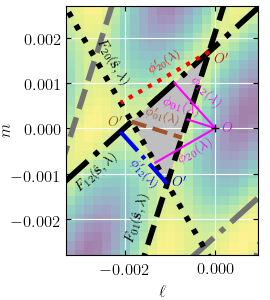

/lustre/aoc/users/nthyagar/projects/CPhaseGeom/figures/closure_phase_illustration.pdf


In [31]:
fig = PLT.figure(figsize=(2.7,3))
ax = fig.add_subplot(111)
ax.pcolorfast(lvect-0.5*dl, mvect-0.5*dm, net_skyfringes_img[:-1,:-1].real, cmap='viridis', alpha=0.5)
ax.fill(skyvis_points_raveled[:,0], skyvis_points_raveled[:,1], fc='0.75')
ax.plot(lvect, skyfringes_lines_m[0,maxharmonics,:], ls='--', lw=4, color='black')
ax.plot(lvect, skyfringes_lines_m[0,maxharmonics+1,:], ls='--', lw=4, color='0.45')
ax.plot(lvect, skyfringes_lines_m[0,maxharmonics+2,:], ls='--', lw=4, color='0.65')
ax.plot(lvect, skyfringes_lines_m[0,maxharmonics-1,:], ls='--', lw=4, color='0.45')
ax.plot(lvect, skyfringes_lines_m[0,maxharmonics-2,:], ls='--', lw=4, color='0.65')
ax.plot(lvect, skyfringes_lines_m[1,maxharmonics,:], ls='-.', lw=4, color='black')
ax.plot(lvect, skyfringes_lines_m[1,maxharmonics+1,:], ls='-.', lw=4, color='0.45')
ax.plot(lvect, skyfringes_lines_m[1,maxharmonics+2,:], ls='-.', lw=4, color='0.65')
ax.plot(lvect, skyfringes_lines_m[1,maxharmonics-1,:], ls='-.', lw=4, color='0.45')
ax.plot(lvect, skyfringes_lines_m[1,maxharmonics-2,:], ls='-.', lw=4, color='0.65')
ax.plot(lvect, skyfringes_lines_m[2,maxharmonics,:], ls=':', lw=4, color='black')
ax.plot(lvect, skyfringes_lines_m[2,maxharmonics+1,:], ls=':', lw=4, color='0.45')
ax.plot(lvect, skyfringes_lines_m[2,maxharmonics+2,:], ls=':', lw=4, color='0.65')
ax.plot(lvect, skyfringes_lines_m[2,maxharmonics-1,:], ls=':', lw=4, color='0.45')
ax.plot(lvect, skyfringes_lines_m[2,maxharmonics-2,:], ls=':', lw=4, color='0.65')
ax.text(-0.002, -0.0026, r'$F_{01}(\hat{\mathbf{s}},\lambda)$', ha='left', va='bottom', transform=ax.transData, fontsize=10, color='black', rotation=NP.degrees(NP.arctan(fringe_slopes[0])))
ax.text(-0.0026, -0.001, r'$F_{12}(\hat{\mathbf{s}},\lambda)$', ha='center', va='center', transform=ax.transData, fontsize=10, color='black', rotation=NP.degrees(NP.arctan(fringe_slopes[1])))
ax.text(-0.0027, 0.002, r'$F_{20}(\hat{\mathbf{s}},\lambda)$', ha='left', va='top', transform=ax.transData, fontsize=10, color='black', rotation=NP.degrees(NP.arctan(fringe_slopes[2])))

ax.plot(NP.asarray([skyvis_points_raveled[0,0], skyvis_perp_intersection_opp_fringe[0,0]]), NP.asarray([skyvis_points_raveled[0,1], skyvis_perp_intersection_opp_fringe[0,1]]), ls=':', lw=3, color='red')
ax.plot(NP.asarray([skyvis_points_raveled[1,0], skyvis_perp_intersection_opp_fringe[1,0]]), NP.asarray([skyvis_points_raveled[1,1], skyvis_perp_intersection_opp_fringe[1,1]]), ls='--', lw=3, color='sienna')
ax.plot(NP.asarray([skyvis_points_raveled[2,0], skyvis_perp_intersection_opp_fringe[2,0]]), NP.asarray([skyvis_points_raveled[2,1], skyvis_perp_intersection_opp_fringe[2,1]]), ls='-.', lw=3, color='blue')
ax.text(0.5*(skyvis_points_raveled[0,0]+skyvis_perp_intersection_opp_fringe[0,0]), 3e-4+0.5*(skyvis_points_raveled[0,1]+skyvis_perp_intersection_opp_fringe[0,1]), r'$\phi_{20}^\prime(\lambda)$', ha='center', va='center', transform=ax.transData, fontsize=9, color='red', rotation=NP.degrees(NP.arctan(perp_fringe_slopes_roll1[0])))
ax.text(0.45*(skyvis_points_raveled[1,0]+skyvis_perp_intersection_opp_fringe[1,0]), 2.5e-4+0.5*(skyvis_points_raveled[1,1]+skyvis_perp_intersection_opp_fringe[1,1]), r'$\phi_{01}^\prime(\lambda)$', ha='center', va='center', transform=ax.transData, fontsize=9, color='sienna', rotation=NP.degrees(NP.arctan(perp_fringe_slopes_roll1[1])))
ax.text(0.5*(skyvis_points_raveled[2,0]+skyvis_perp_intersection_opp_fringe[2,0]), -4e-4+0.5*(skyvis_points_raveled[2,1]+skyvis_perp_intersection_opp_fringe[2,1]), r'$\phi_{12}^\prime(\lambda)$', ha='center', va='center', transform=ax.transData, fontsize=9, color='blue', rotation=NP.degrees(NP.arctan(perp_fringe_slopes_roll1[2])))

ax.plot(NP.asarray([origin[0,0], skyvis_origin_perp_intersection_opp_fringe[0,0]]), NP.asarray([origin[0,1], skyvis_origin_perp_intersection_opp_fringe[0,1]]), ls='-', lw=1.5, color='magenta')
ax.plot(NP.asarray([origin[1,0], skyvis_origin_perp_intersection_opp_fringe[1,0]]), NP.asarray([origin[1,1], skyvis_origin_perp_intersection_opp_fringe[1,1]]), ls='-', lw=1.5, color='magenta')
ax.plot(NP.asarray([origin[2,0], skyvis_origin_perp_intersection_opp_fringe[2,0]]), NP.asarray([origin[2,1], skyvis_origin_perp_intersection_opp_fringe[2,1]]), ls='-', lw=1.5, color='magenta')
ax.text(0.65*skyvis_origin_perp_intersection_opp_fringe[0,0], 2e-4+0.5*skyvis_origin_perp_intersection_opp_fringe[0,1], r'$\phi_{20}(\lambda)$', ha='left', va='top', transform=ax.transData, fontsize=10, color='magenta', rotation=NP.degrees(NP.arctan(perp_fringe_slopes_roll1[0])))
ax.text(0.5*skyvis_origin_perp_intersection_opp_fringe[1,0], 0.5e-4+0.5*skyvis_origin_perp_intersection_opp_fringe[1,1], r'$\phi_{01}(\lambda)$', ha='right', va='bottom', transform=ax.transData, fontsize=10, color='magenta', rotation=NP.degrees(NP.arctan(perp_fringe_slopes_roll1[1])))
ax.text(0.25*skyvis_origin_perp_intersection_opp_fringe[2,0], 2.5e-4+0.5*skyvis_origin_perp_intersection_opp_fringe[2,1], r'$\phi_{12}(\lambda)$', ha='center', va='center', transform=ax.transData, fontsize=10, color='magenta', rotation=NP.degrees(NP.arctan(perp_fringe_slopes_roll1[2])))

ax.plot(0, 0, ls='none', marker='+', ms=6, color='black')
ax.text(1.5e-4, 0, r'$O$', ha='left', va='center', color='magenta', fontsize=10, weight='extra bold')
ax.text(1e-4+skyvis_points_raveled[0,0], skyvis_points_raveled[0,1], r'$O^\prime$', ha='left', va='top', color='red', fontsize=10, weight='extra bold')
ax.text(-2e-4+skyvis_points_raveled[1,0], skyvis_points_raveled[1,1], r'$O^\prime$', ha='right', va='center', color='sienna', fontsize=10, weight='extra bold')
ax.text(1e-4+skyvis_points_raveled[2,0], 2e-4+skyvis_points_raveled[2,1], r'$O^\prime$', ha='left', va='top', color='blue', fontsize=10, weight='extra bold')

# ax.set_xlim(-0.0029,0.00125)
# ax.set_ylim(-0.002,0.0035)
ax.set_xlim(-0.0033,0.00095)
ax.set_ylim(-0.0028,0.0027)
ax.set_aspect('equal')
ax.yaxis.tick_left()
ax.set_xlabel(r'$\ell$', weight='medium', fontsize=12)
ax.set_ylabel(r'$m$', weight='medium', fontsize=12, labelpad=-2.5)
ax.yaxis.set_label_position('left')
ax.grid(which='both', color='white')
ax.tick_params(bottom=True, top=True, left=True, right=True)

fig.subplots_adjust(left=0.21, right=0.99, bottom=0.15, top=0.98)

PLT.savefig(figdir+'closure_phase_illustration.pdf', bbox_inches=0)
print(figdir+'closure_phase_illustration.pdf')

In [38]:
# fig = PLT.figure(figsize=(2.7,3))
# ax = fig.add_subplot(111)
# ax.pcolorfast(lvect-0.5*dl, mvect-0.5*dm, net_skyfringes_img[:-1,:-1].real, cmap='viridis', alpha=0.5)
# ax.fill(skyvis_points_raveled[:,0], skyvis_points_raveled[:,1], fc='0.75')
# ax.plot(lvect, skyfringes_lines_m[0,maxharmonics,:], ls='--', lw=4, color='black')
# ax.plot(lvect, skyfringes_lines_m[0,maxharmonics+1,:], ls='--', lw=4, color='0.45')
# ax.plot(lvect, skyfringes_lines_m[0,maxharmonics+2,:], ls='--', lw=4, color='0.65')
# ax.plot(lvect, skyfringes_lines_m[0,maxharmonics-1,:], ls='--', lw=4, color='0.45')
# ax.plot(lvect, skyfringes_lines_m[0,maxharmonics-2,:], ls='--', lw=4, color='0.65')
# ax.plot(lvect, skyfringes_lines_m[1,maxharmonics,:], ls='-.', lw=4, color='black')
# ax.plot(lvect, skyfringes_lines_m[1,maxharmonics+1,:], ls='-.', lw=4, color='0.45')
# ax.plot(lvect, skyfringes_lines_m[1,maxharmonics+2,:], ls='-.', lw=4, color='0.65')
# ax.plot(lvect, skyfringes_lines_m[1,maxharmonics-1,:], ls='-.', lw=4, color='0.45')
# ax.plot(lvect, skyfringes_lines_m[1,maxharmonics-2,:], ls='-.', lw=4, color='0.65')
# ax.plot(lvect, skyfringes_lines_m[2,maxharmonics,:], ls=':', lw=4, color='black')
# ax.plot(lvect, skyfringes_lines_m[2,maxharmonics+1,:], ls=':', lw=4, color='0.45')
# ax.plot(lvect, skyfringes_lines_m[2,maxharmonics+2,:], ls=':', lw=4, color='0.65')
# ax.plot(lvect, skyfringes_lines_m[2,maxharmonics-1,:], ls=':', lw=4, color='0.45')
# ax.plot(lvect, skyfringes_lines_m[2,maxharmonics-2,:], ls=':', lw=4, color='0.65')
# ax.text(-0.002, -0.0026, r'$F_{12}(\hat{\mathbf{s}},\lambda)$', ha='left', va='bottom', transform=ax.transData, fontsize=10, color='black', rotation=NP.degrees(NP.arctan(fringe_slopes[0])))
# ax.text(-0.0026, -0.001, r'$F_{23}(\hat{\mathbf{s}},\lambda)$', ha='center', va='center', transform=ax.transData, fontsize=10, color='black', rotation=NP.degrees(NP.arctan(fringe_slopes[1])))
# ax.text(-0.0027, 0.002, r'$F_{31}(\hat{\mathbf{s}},\lambda)$', ha='left', va='top', transform=ax.transData, fontsize=10, color='black', rotation=NP.degrees(NP.arctan(fringe_slopes[2])))

# ax.plot(NP.asarray([skyvis_points_raveled[0,0], skyvis_perp_intersection_opp_fringe[0,0]]), NP.asarray([skyvis_points_raveled[0,1], skyvis_perp_intersection_opp_fringe[0,1]]), ls=':', lw=3, color='red')
# ax.plot(NP.asarray([skyvis_points_raveled[1,0], skyvis_perp_intersection_opp_fringe[1,0]]), NP.asarray([skyvis_points_raveled[1,1], skyvis_perp_intersection_opp_fringe[1,1]]), ls='--', lw=3, color='darkgreen')
# ax.plot(NP.asarray([skyvis_points_raveled[2,0], skyvis_perp_intersection_opp_fringe[2,0]]), NP.asarray([skyvis_points_raveled[2,1], skyvis_perp_intersection_opp_fringe[2,1]]), ls='-.', lw=3, color='blue')
# ax.text(0.5*(skyvis_points_raveled[0,0]+skyvis_perp_intersection_opp_fringe[0,0]), 3e-4+0.5*(skyvis_points_raveled[0,1]+skyvis_perp_intersection_opp_fringe[0,1]), r'$\phi_{31}^\prime(\lambda)$', ha='center', va='center', transform=ax.transData, fontsize=9, color='red', rotation=NP.degrees(NP.arctan(perp_fringe_slopes_roll1[0])))
# ax.text(0.45*(skyvis_points_raveled[1,0]+skyvis_perp_intersection_opp_fringe[1,0]), 2.5e-4+0.5*(skyvis_points_raveled[1,1]+skyvis_perp_intersection_opp_fringe[1,1]), r'$\phi_{12}^\prime(\lambda)$', ha='center', va='center', transform=ax.transData, fontsize=9, color='darkgreen', rotation=NP.degrees(NP.arctan(perp_fringe_slopes_roll1[1])))
# ax.text(0.5*(skyvis_points_raveled[2,0]+skyvis_perp_intersection_opp_fringe[2,0]), -4e-4+0.5*(skyvis_points_raveled[2,1]+skyvis_perp_intersection_opp_fringe[2,1]), r'$\phi_{23}^\prime(\lambda)$', ha='center', va='center', transform=ax.transData, fontsize=9, color='blue', rotation=NP.degrees(NP.arctan(perp_fringe_slopes_roll1[2])))

# ax.plot(NP.asarray([origin[0,0], skyvis_origin_perp_intersection_opp_fringe[0,0]]), NP.asarray([origin[0,1], skyvis_origin_perp_intersection_opp_fringe[0,1]]), ls='-', lw=1.5, color='magenta')
# ax.plot(NP.asarray([origin[1,0], skyvis_origin_perp_intersection_opp_fringe[1,0]]), NP.asarray([origin[1,1], skyvis_origin_perp_intersection_opp_fringe[1,1]]), ls='-', lw=1.5, color='magenta')
# ax.plot(NP.asarray([origin[2,0], skyvis_origin_perp_intersection_opp_fringe[2,0]]), NP.asarray([origin[2,1], skyvis_origin_perp_intersection_opp_fringe[2,1]]), ls='-', lw=1.5, color='magenta')
# ax.text(0.65*skyvis_origin_perp_intersection_opp_fringe[0,0], 2e-4+0.5*skyvis_origin_perp_intersection_opp_fringe[0,1], r'$\phi_{31}(\lambda)$', ha='left', va='top', transform=ax.transData, fontsize=10, color='magenta', rotation=NP.degrees(NP.arctan(perp_fringe_slopes_roll1[0])))
# ax.text(0.5*skyvis_origin_perp_intersection_opp_fringe[1,0], 0.5e-4+0.5*skyvis_origin_perp_intersection_opp_fringe[1,1], r'$\phi_{12}(\lambda)$', ha='right', va='bottom', transform=ax.transData, fontsize=10, color='magenta', rotation=NP.degrees(NP.arctan(perp_fringe_slopes_roll1[1])))
# ax.text(0.25*skyvis_origin_perp_intersection_opp_fringe[2,0], 2.5e-4+0.5*skyvis_origin_perp_intersection_opp_fringe[2,1], r'$\phi_{23}(\lambda)$', ha='center', va='center', transform=ax.transData, fontsize=10, color='magenta', rotation=NP.degrees(NP.arctan(perp_fringe_slopes_roll1[2])))

# ax.plot(0, 0, ls='none', marker='+', ms=6, color='black')
# ax.text(1.5e-4, 0, r'$O$', ha='left', va='center', color='magenta', fontsize=10, weight='extra bold')
# ax.text(1e-4+skyvis_points_raveled[0,0], skyvis_points_raveled[0,1], r'$O^\prime$', ha='left', va='top', color='red', fontsize=10, weight='extra bold')
# ax.text(-1e-4+skyvis_points_raveled[1,0], skyvis_points_raveled[1,1], r'$O^\prime$', ha='right', va='center', color='darkgreen', fontsize=10, weight='extra bold')
# ax.text(1e-4+skyvis_points_raveled[2,0], 2e-4+skyvis_points_raveled[2,1], r'$O^\prime$', ha='left', va='top', color='blue', fontsize=10, weight='extra bold')

# # ax.set_xlim(-0.0029,0.00125)
# # ax.set_ylim(-0.002,0.0035)
# ax.set_xlim(-0.0033,0.00095)
# ax.set_ylim(-0.0028,0.0027)
# ax.set_aspect('equal')
# ax.yaxis.tick_left()
# ax.set_xlabel(r'$l$', weight='medium', fontsize=10)
# ax.set_ylabel(r'$m$', weight='medium', fontsize=10, labelpad=-2.5)
# ax.yaxis.set_label_position('left')
# ax.grid(which='both', color='white')
# ax.tick_params(bottom=True, top=True, left=True, right=True)

# fig.subplots_adjust(left=0.21, right=0.99, bottom=0.15, top=0.98)

# PLT.savefig(figdir+'closure_phase_illustration.pdf', bbox_inches=0)
# print(figdir+'closure_phase_illustration.pdf')

# Plot an illustration of closure phase with ideal, uncalibrated, and translated fringes

<IPython.core.display.Javascript object>


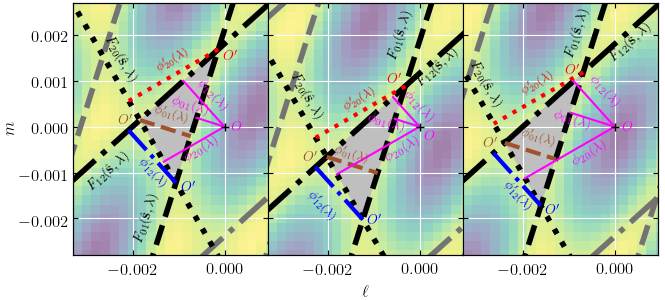

/lustre/aoc/users/nthyagar/projects/CPhaseGeom/figures/closure_phase_ideal_uncal_trans.pdf


In [34]:
fig, axs = PLT.subplots(nrows=1, ncols=3, squeeze=1, sharex=True, sharey=True, figsize=(6.65,3))

########### Ideal calibrated fringes ###########

axs[0].pcolorfast(lvect-0.5*dl, mvect-0.5*dm, net_skyfringes_img[:-1,:-1].real, cmap='viridis', alpha=0.5)
axs[0].fill(skyvis_points_raveled[:,0], skyvis_points_raveled[:,1], fc='0.75')
axs[0].plot(lvect, skyfringes_lines_m[0,maxharmonics,:], ls='--', lw=4, color='black')
axs[0].plot(lvect, skyfringes_lines_m[0,maxharmonics+1,:], ls='--', lw=4, color='0.45')
axs[0].plot(lvect, skyfringes_lines_m[0,maxharmonics+2,:], ls='--', lw=4, color='0.65')
axs[0].plot(lvect, skyfringes_lines_m[0,maxharmonics-1,:], ls='--', lw=4, color='0.45')
axs[0].plot(lvect, skyfringes_lines_m[0,maxharmonics-2,:], ls='--', lw=4, color='0.65')
axs[0].plot(lvect, skyfringes_lines_m[1,maxharmonics,:], ls='-.', lw=4, color='black')
axs[0].plot(lvect, skyfringes_lines_m[1,maxharmonics+1,:], ls='-.', lw=4, color='0.45')
axs[0].plot(lvect, skyfringes_lines_m[1,maxharmonics+2,:], ls='-.', lw=4, color='0.65')
axs[0].plot(lvect, skyfringes_lines_m[1,maxharmonics-1,:], ls='-.', lw=4, color='0.45')
axs[0].plot(lvect, skyfringes_lines_m[1,maxharmonics-2,:], ls='-.', lw=4, color='0.65')
axs[0].plot(lvect, skyfringes_lines_m[2,maxharmonics,:], ls=':', lw=4, color='black')
axs[0].plot(lvect, skyfringes_lines_m[2,maxharmonics+1,:], ls=':', lw=4, color='0.45')
axs[0].plot(lvect, skyfringes_lines_m[2,maxharmonics+2,:], ls=':', lw=4, color='0.65')
axs[0].plot(lvect, skyfringes_lines_m[2,maxharmonics-1,:], ls=':', lw=4, color='0.45')
axs[0].plot(lvect, skyfringes_lines_m[2,maxharmonics-2,:], ls=':', lw=4, color='0.65')
axs[0].text(-0.002, -0.0026, r'$F_{01}(\hat{\mathbf{s}},\lambda)$', ha='left', va='bottom', transform=axs[0].transData, fontsize=10, color='black', rotation=NP.degrees(NP.arctan(fringe_slopes[0])))
axs[0].text(-0.0025, -0.001, r'$F_{12}(\hat{\mathbf{s}},\lambda)$', ha='center', va='center', transform=axs[0].transData, fontsize=10, color='black', rotation=NP.degrees(NP.arctan(fringe_slopes[1])))
axs[0].text(-0.0027, 0.002, r'$F_{20}(\hat{\mathbf{s}},\lambda)$', ha='left', va='top', transform=axs[0].transData, fontsize=10, color='black', rotation=NP.degrees(NP.arctan(fringe_slopes[2])))

axs[0].plot(NP.asarray([skyvis_points_raveled[0,0], skyvis_perp_intersection_opp_fringe[0,0]]), NP.asarray([skyvis_points_raveled[0,1], skyvis_perp_intersection_opp_fringe[0,1]]), ls=':', lw=3, color='red')
axs[0].plot(NP.asarray([skyvis_points_raveled[1,0], skyvis_perp_intersection_opp_fringe[1,0]]), NP.asarray([skyvis_points_raveled[1,1], skyvis_perp_intersection_opp_fringe[1,1]]), ls='--', lw=3, color='sienna')
axs[0].plot(NP.asarray([skyvis_points_raveled[2,0], skyvis_perp_intersection_opp_fringe[2,0]]), NP.asarray([skyvis_points_raveled[2,1], skyvis_perp_intersection_opp_fringe[2,1]]), ls='-.', lw=3, color='blue')
axs[0].text(0.5*(skyvis_points_raveled[0,0]+skyvis_perp_intersection_opp_fringe[0,0]), 3e-4+0.5*(skyvis_points_raveled[0,1]+skyvis_perp_intersection_opp_fringe[0,1]), r'$\phi_{20}^\prime(\lambda)$', ha='center', va='center', transform=axs[0].transData, fontsize=9, color='red', rotation=NP.degrees(NP.arctan(perp_fringe_slopes_roll1[0])))
axs[0].text(0.45*(skyvis_points_raveled[1,0]+skyvis_perp_intersection_opp_fringe[1,0]), 2.5e-4+0.5*(skyvis_points_raveled[1,1]+skyvis_perp_intersection_opp_fringe[1,1]), r'$\phi_{01}^\prime(\lambda)$', ha='center', va='center', transform=axs[0].transData, fontsize=9, color='sienna', rotation=NP.degrees(NP.arctan(perp_fringe_slopes_roll1[1])))
axs[0].text(0.5*(skyvis_points_raveled[2,0]+skyvis_perp_intersection_opp_fringe[2,0]), -4e-4+0.5*(skyvis_points_raveled[2,1]+skyvis_perp_intersection_opp_fringe[2,1]), r'$\phi_{12}^\prime(\lambda)$', ha='center', va='center', transform=axs[0].transData, fontsize=9, color='blue', rotation=NP.degrees(NP.arctan(perp_fringe_slopes_roll1[2])))

axs[0].plot(NP.asarray([origin[0,0], skyvis_origin_perp_intersection_opp_fringe[0,0]]), NP.asarray([origin[0,1], skyvis_origin_perp_intersection_opp_fringe[0,1]]), ls='-', lw=1.5, color='magenta')
axs[0].plot(NP.asarray([origin[1,0], skyvis_origin_perp_intersection_opp_fringe[1,0]]), NP.asarray([origin[1,1], skyvis_origin_perp_intersection_opp_fringe[1,1]]), ls='-', lw=1.5, color='magenta')
axs[0].plot(NP.asarray([origin[2,0], skyvis_origin_perp_intersection_opp_fringe[2,0]]), NP.asarray([origin[2,1], skyvis_origin_perp_intersection_opp_fringe[2,1]]), ls='-', lw=1.5, color='magenta')
axs[0].text(0.7*skyvis_origin_perp_intersection_opp_fringe[0,0], 2e-4+0.5*skyvis_origin_perp_intersection_opp_fringe[0,1], r'$\phi_{20}(\lambda)$', ha='left', va='top', transform=axs[0].transData, fontsize=10, color='magenta', rotation=NP.degrees(NP.arctan(perp_fringe_slopes_roll1[0])))
axs[0].text(0.5*skyvis_origin_perp_intersection_opp_fringe[1,0], 0.5e-4+0.5*skyvis_origin_perp_intersection_opp_fringe[1,1], r'$\phi_{01}(\lambda)$', ha='right', va='bottom', transform=axs[0].transData, fontsize=10, color='magenta', rotation=NP.degrees(NP.arctan(perp_fringe_slopes_roll1[1])))
axs[0].text(0.3*skyvis_origin_perp_intersection_opp_fringe[2,0], 1.5e-4+0.5*skyvis_origin_perp_intersection_opp_fringe[2,1], r'$\phi_{12}(\lambda)$', ha='center', va='center', transform=axs[0].transData, fontsize=10, color='magenta', rotation=NP.degrees(NP.arctan(perp_fringe_slopes_roll1[2])))

axs[0].plot(0, 0, ls='none', marker='+', ms=6, color='black')
axs[0].text(0.00015, 0, r'$O$', ha='left', va='center', color='magenta', fontsize=10, weight='extra bold')
axs[0].text(0.0001+skyvis_points_raveled[0,0], skyvis_points_raveled[0,1], r'$O^\prime$', ha='left', va='top', color='red', fontsize=10, weight='extra bold')
axs[0].text(-0.00016+skyvis_points_raveled[1,0], skyvis_points_raveled[1,1], r'$O^\prime$', ha='right', va='center', color='sienna', fontsize=10, weight='extra bold')
axs[0].text(0.0001+skyvis_points_raveled[2,0], -0.0001+skyvis_points_raveled[2,1], r'$O^\prime$', ha='left', va='center', color='blue', fontsize=10, weight='extra bold')

axs[0].set_xlim(-0.0033,0.00095)
axs[0].set_ylim(-0.0028,0.0027)
axs[0].set_aspect('equal')
axs[0].grid(which='both', color='white')
axs[0].tick_params(bottom=True, top=True, left=True, right=True)

########### Uncalibrated fringes ############

axs[1].pcolorfast(lvect-0.5*dl, mvect-0.5*dm, net_measfringes_img[:-1,:-1].real, cmap='viridis', alpha=0.5)
axs[1].fill(measvis_points_raveled[:,0], measvis_points_raveled[:,1], fc='0.75')
axs[1].plot(lvect, measfringes_lines_m[0,maxharmonics,:], ls='--', lw=4, color='black')
axs[1].plot(lvect, measfringes_lines_m[0,maxharmonics+1,:], ls='--', lw=4, color='0.45')
axs[1].plot(lvect, measfringes_lines_m[0,maxharmonics+2,:], ls='--', lw=4, color='0.65')
axs[1].plot(lvect, measfringes_lines_m[0,maxharmonics-1,:], ls='--', lw=4, color='0.45')
axs[1].plot(lvect, measfringes_lines_m[0,maxharmonics-2,:], ls='--', lw=4, color='0.65')
axs[1].plot(lvect, measfringes_lines_m[1,maxharmonics,:], ls='-.', lw=4, color='black')
axs[1].plot(lvect, measfringes_lines_m[1,maxharmonics+1,:], ls='-.', lw=4, color='0.45')
axs[1].plot(lvect, measfringes_lines_m[1,maxharmonics+2,:], ls='-.', lw=4, color='0.65')
axs[1].plot(lvect, measfringes_lines_m[1,maxharmonics-1,:], ls='-.', lw=4, color='0.45')
axs[1].plot(lvect, measfringes_lines_m[1,maxharmonics-2,:], ls='-.', lw=4, color='0.65')
axs[1].plot(lvect, measfringes_lines_m[2,maxharmonics,:], ls=':', lw=4, color='black')
axs[1].plot(lvect, measfringes_lines_m[2,maxharmonics+1,:], ls=':', lw=4, color='0.45')
axs[1].plot(lvect, measfringes_lines_m[2,maxharmonics+2,:], ls=':', lw=4, color='0.65')
axs[1].plot(lvect, measfringes_lines_m[2,maxharmonics-1,:], ls=':', lw=4, color='0.45')
axs[1].plot(lvect, measfringes_lines_m[2,maxharmonics-2,:], ls=':', lw=4, color='0.65')
axs[1].text(-7e-4, 1.4e-3, r'$F_{01}(\hat{\mathbf{s}},\lambda)$', ha='left', va='bottom', transform=axs[1].transData, fontsize=10, color='black', rotation=NP.degrees(NP.arctan(fringe_slopes[0])))
axs[1].text(-1e-4, 1.75e-3, r'$F_{12}(\hat{\mathbf{s}},\lambda)$', ha='left', va='top', transform=axs[1].transData, fontsize=10, color='black', rotation=NP.degrees(NP.arctan(fringe_slopes[1])))
axs[1].text(-2.9e-3, 1.2e-3, r'$F_{20}(\hat{\mathbf{s}},\lambda)$', ha='left', va='top', transform=axs[1].transData, fontsize=10, color='black', rotation=NP.degrees(NP.arctan(fringe_slopes[2])))

axs[1].plot(NP.asarray([measvis_points_raveled[0,0], measvis_perp_intersection_opp_fringe[0,0]]), NP.asarray([measvis_points_raveled[0,1], measvis_perp_intersection_opp_fringe[0,1]]), ls=':', lw=3, color='red')
axs[1].plot(NP.asarray([measvis_points_raveled[1,0], measvis_perp_intersection_opp_fringe[1,0]]), NP.asarray([measvis_points_raveled[1,1], measvis_perp_intersection_opp_fringe[1,1]]), ls='--', lw=3, color='sienna')
axs[1].plot(NP.asarray([measvis_points_raveled[2,0], measvis_perp_intersection_opp_fringe[2,0]]), NP.asarray([measvis_points_raveled[2,1], measvis_perp_intersection_opp_fringe[2,1]]), ls='-.', lw=3, color='blue')
axs[1].text(0.5*(measvis_points_raveled[0,0]+measvis_perp_intersection_opp_fringe[0,0]), 2.5e-4+0.5*(measvis_points_raveled[0,1]+measvis_perp_intersection_opp_fringe[0,1]), r'$\phi_{20}^\prime(\lambda)$', ha='center', va='center', transform=axs[1].transData, fontsize=9, color='red', rotation=NP.degrees(NP.arctan(perp_fringe_slopes_roll1[0])))
axs[1].text(0.45*(measvis_points_raveled[1,0]+transvis_perp_intersection_opp_fringe[1,0]), 2e-4+0.5*(measvis_points_raveled[1,1]+measvis_perp_intersection_opp_fringe[1,1]), r'$\phi_{01}^\prime(\lambda)$', ha='center', va='center', transform=axs[1].transData, fontsize=9, color='sienna', rotation=NP.degrees(NP.arctan(perp_fringe_slopes_roll1[1])))
axs[1].text(-2e-4+0.5*(measvis_points_raveled[2,0]+transvis_perp_intersection_opp_fringe[2,0]), -3e-4+0.5*(measvis_points_raveled[2,1]+measvis_perp_intersection_opp_fringe[2,1]), r'$\phi_{12}^\prime(\lambda)$', ha='center', va='center', transform=axs[1].transData, fontsize=9, color='blue', rotation=NP.degrees(NP.arctan(perp_fringe_slopes_roll1[2])))

axs[1].plot(NP.asarray([origin[0,0], measvis_origin_perp_intersection_opp_fringe[0,0]]), NP.asarray([origin[0,1], measvis_origin_perp_intersection_opp_fringe[0,1]]), ls='-', lw=1.5, color='magenta')
axs[1].plot(NP.asarray([origin[1,0], measvis_origin_perp_intersection_opp_fringe[1,0]]), NP.asarray([origin[1,1], measvis_origin_perp_intersection_opp_fringe[1,1]]), ls='-', lw=1.5, color='magenta')
axs[1].plot(NP.asarray([origin[2,0], measvis_origin_perp_intersection_opp_fringe[2,0]]), NP.asarray([origin[2,1], measvis_origin_perp_intersection_opp_fringe[2,1]]), ls='-', lw=1.5, color='magenta')
axs[1].text(1e-4+0.5*measvis_origin_perp_intersection_opp_fringe[0,0], 0.5*measvis_origin_perp_intersection_opp_fringe[0,1], r'$\phi_{20}(\lambda)$', ha='left', va='center', transform=axs[1].transData, fontsize=10, color='magenta', rotation=NP.degrees(NP.arctan(perp_fringe_slopes_roll1[0])))
axs[1].text(0.5*measvis_origin_perp_intersection_opp_fringe[1,0], 2.3e-4+0.5*measvis_origin_perp_intersection_opp_fringe[1,1], r'$\phi_{01}(\lambda)$', ha='right', va='top', transform=axs[1].transData, fontsize=10, color='magenta', rotation=NP.degrees(NP.arctan(perp_fringe_slopes_roll1[1])))
axs[1].text(1e-4+0.25*measvis_origin_perp_intersection_opp_fringe[2,0], 1e-4+0.5*measvis_origin_perp_intersection_opp_fringe[2,1], r'$\phi_{12}(\lambda)$', ha='center', va='center', transform=axs[1].transData, fontsize=10, color='magenta', rotation=NP.degrees(NP.arctan(perp_fringe_slopes_roll1[2])))

axs[1].plot(0, 0, ls='none', marker='+', ms=6, color='black')
axs[1].text(1e-4, -2e-4, r'$O$', ha='left', va='center', color='magenta', fontsize=10, weight='extra bold')
axs[1].text(-1e-4+measvis_points_raveled[0,0], measvis_points_raveled[0,1], r'$O^\prime$', ha='right', va='bottom', color='red', fontsize=10, weight='extra bold')
axs[1].text(-2e-4+measvis_points_raveled[1,0], measvis_points_raveled[1,1], r'$O^\prime$', ha='right', va='center', color='sienna', fontsize=10, weight='extra bold')
axs[1].text(1e-4+measvis_points_raveled[2,0], measvis_points_raveled[2,1], r'$O^\prime$', ha='left', va='center', color='blue', fontsize=10, weight='extra bold')

axs[1].set_xlim(-0.0033,0.00095)
axs[1].set_ylim(-0.0028,0.0027)
axs[1].set_aspect('equal')
axs[1].grid(which='both', color='white')
axs[1].tick_params(bottom=True, top=True, left=True, right=True)

########### Translated fringes ############

axs[2].pcolorfast(lvect-0.5*dl, mvect-0.5*dm, net_transfringes_img[:-1,:-1].real, cmap='viridis', alpha=0.5)
axs[2].fill(transvis_points_raveled[:,0], transvis_points_raveled[:,1], fc='0.75')
axs[2].plot(lvect, transfringes_lines_m[0,maxharmonics,:], ls='--', lw=4, color='black')
axs[2].plot(lvect, transfringes_lines_m[0,maxharmonics+1,:], ls='--', lw=4, color='0.45')
axs[2].plot(lvect, transfringes_lines_m[0,maxharmonics+2,:], ls='--', lw=4, color='0.65')
axs[2].plot(lvect, transfringes_lines_m[0,maxharmonics-1,:], ls='--', lw=4, color='0.45')
axs[2].plot(lvect, transfringes_lines_m[0,maxharmonics-2,:], ls='--', lw=4, color='0.65')
axs[2].plot(lvect, transfringes_lines_m[1,maxharmonics,:], ls='-.', lw=4, color='black')
axs[2].plot(lvect, transfringes_lines_m[1,maxharmonics+1,:], ls='-.', lw=4, color='0.45')
axs[2].plot(lvect, transfringes_lines_m[1,maxharmonics+2,:], ls='-.', lw=4, color='0.65')
axs[2].plot(lvect, transfringes_lines_m[1,maxharmonics-1,:], ls='-.', lw=4, color='0.45')
axs[2].plot(lvect, transfringes_lines_m[1,maxharmonics-2,:], ls='-.', lw=4, color='0.65')
axs[2].plot(lvect, transfringes_lines_m[2,maxharmonics,:], ls=':', lw=4, color='black')
axs[2].plot(lvect, transfringes_lines_m[2,maxharmonics+1,:], ls=':', lw=4, color='0.45')
axs[2].plot(lvect, transfringes_lines_m[2,maxharmonics+2,:], ls=':', lw=4, color='0.65')
axs[2].plot(lvect, transfringes_lines_m[2,maxharmonics-1,:], ls=':', lw=4, color='0.45')
axs[2].plot(lvect, transfringes_lines_m[2,maxharmonics-2,:], ls=':', lw=4, color='0.65')

axs[2].text(-1.1e-3, 1.45e-3, r'$F_{01}(\hat{\mathbf{s}},\lambda)$', ha='left', va='bottom', transform=axs[2].transData, fontsize=10, color='black', rotation=NP.degrees(NP.arctan(fringe_slopes[0])))
axs[2].text(-1.5e-4, 2.3e-3, r'$F_{12}(\hat{\mathbf{s}},\lambda)$', ha='left', va='top', transform=axs[2].transData, fontsize=10, color='black', rotation=NP.degrees(NP.arctan(fringe_slopes[1])))
axs[2].text(-3.25e-3, 1.45e-3, r'$F_{20}(\hat{\mathbf{s}},\lambda)$', ha='left', va='top', transform=axs[2].transData, fontsize=10, color='black', rotation=NP.degrees(NP.arctan(fringe_slopes[2])))

axs[2].plot(NP.asarray([transvis_points_raveled[0,0], transvis_perp_intersection_opp_fringe[0,0]]), NP.asarray([transvis_points_raveled[0,1], transvis_perp_intersection_opp_fringe[0,1]]), ls=':', lw=3, color='red')
axs[2].plot(NP.asarray([transvis_points_raveled[1,0], transvis_perp_intersection_opp_fringe[1,0]]), NP.asarray([transvis_points_raveled[1,1], transvis_perp_intersection_opp_fringe[1,1]]), ls='--', lw=3, color='sienna')
axs[2].plot(NP.asarray([transvis_points_raveled[2,0], transvis_perp_intersection_opp_fringe[2,0]]), NP.asarray([transvis_points_raveled[2,1], transvis_perp_intersection_opp_fringe[2,1]]), ls='-.', lw=3, color='blue')
axs[2].text(0.5*(transvis_points_raveled[0,0]+transvis_perp_intersection_opp_fringe[0,0]), 3e-4+0.5*(transvis_points_raveled[0,1]+transvis_perp_intersection_opp_fringe[0,1]), r'$\phi_{20}^\prime(\lambda)$', ha='center', va='center', transform=axs[2].transData, fontsize=9, color='red', rotation=NP.degrees(NP.arctan(perp_fringe_slopes_roll1[0])))
axs[2].text(0.45*(transvis_points_raveled[1,0]+transvis_perp_intersection_opp_fringe[1,0]), 2.5e-4+0.5*(transvis_points_raveled[1,1]+transvis_perp_intersection_opp_fringe[1,1]), r'$\phi_{01}^\prime(\lambda)$', ha='center', va='center', transform=axs[2].transData, fontsize=9, color='sienna', rotation=NP.degrees(NP.arctan(perp_fringe_slopes_roll1[1])))
axs[2].text(0.5*(transvis_points_raveled[2,0]+transvis_perp_intersection_opp_fringe[2,0]), -4e-4+0.5*(transvis_points_raveled[2,1]+transvis_perp_intersection_opp_fringe[2,1]), r'$\phi_{12}^\prime(\lambda)$', ha='center', va='center', transform=axs[2].transData, fontsize=9, color='blue', rotation=NP.degrees(NP.arctan(perp_fringe_slopes_roll1[2])))

axs[2].plot(NP.asarray([origin[0,0], transvis_origin_perp_intersection_opp_fringe[0,0]]), NP.asarray([origin[0,1], transvis_origin_perp_intersection_opp_fringe[0,1]]), ls='-', lw=1.5, color='magenta')
axs[2].plot(NP.asarray([origin[1,0], transvis_origin_perp_intersection_opp_fringe[1,0]]), NP.asarray([origin[1,1], transvis_origin_perp_intersection_opp_fringe[1,1]]), ls='-', lw=1.5, color='magenta')
axs[2].plot(NP.asarray([origin[2,0], transvis_origin_perp_intersection_opp_fringe[2,0]]), NP.asarray([origin[2,1], transvis_origin_perp_intersection_opp_fringe[2,1]]), ls='-', lw=1.5, color='magenta')
axs[2].text(0.5*transvis_origin_perp_intersection_opp_fringe[0,0], 3e-4+0.5*transvis_origin_perp_intersection_opp_fringe[0,1], r'$\phi_{20}(\lambda)$', ha='left', va='top', transform=axs[2].transData, fontsize=10, color='magenta', rotation=NP.degrees(NP.arctan(perp_fringe_slopes_roll1[0])))
axs[2].text(0.5*transvis_origin_perp_intersection_opp_fringe[1,0], 2.3e-4+0.5*transvis_origin_perp_intersection_opp_fringe[1,1], r'$\phi_{01}(\lambda)$', ha='right', va='top', transform=axs[2].transData, fontsize=10, color='magenta', rotation=NP.degrees(NP.arctan(perp_fringe_slopes_roll1[1])))
axs[2].text(0.25*transvis_origin_perp_intersection_opp_fringe[2,0], 2.5e-4+0.5*transvis_origin_perp_intersection_opp_fringe[2,1], r'$\phi_{12}(\lambda)$', ha='center', va='center', transform=axs[2].transData, fontsize=10, color='magenta', rotation=NP.degrees(NP.arctan(perp_fringe_slopes_roll1[2])))

axs[2].plot(0, 0, ls='none', marker='+', ms=6, color='black')
axs[2].text(0.00015, 0, r'$O$', ha='left', va='center', color='magenta', fontsize=10, weight='extra bold')
axs[2].text(-0.0001+transvis_points_raveled[0,0], -1e-4+transvis_points_raveled[0,1], r'$O^\prime$', ha='right', va='bottom', color='red', fontsize=10, weight='extra bold')
axs[2].text(-0.00016+transvis_points_raveled[1,0], transvis_points_raveled[1,1], r'$O^\prime$', ha='right', va='center', color='sienna', fontsize=10, weight='extra bold')
axs[2].text(0.0001+transvis_points_raveled[2,0], -0.0001+transvis_points_raveled[2,1], r'$O^\prime$', ha='left', va='center', color='blue', fontsize=10, weight='extra bold')

axs[2].set_xlim(-0.0033,0.00095)
axs[2].set_ylim(-0.0028,0.0027)
axs[2].set_aspect('equal')
axs[2].grid(which='both', color='white')
axs[2].tick_params(bottom=True, top=True, left=True, right=True)

fig.subplots_adjust(wspace=0, hspace=0)
fig.subplots_adjust(left=0.11, right=0.99, bottom=0.15, top=0.99)

big_ax = fig.add_subplot(111)
big_ax.set_facecolor('none') # matplotlib.__version__ >= 2.0.0
# big_ax.set_axis_bgcolor('none') # matplotlib.__version__ < 2.0.0
big_ax.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
big_ax.set_xticks([])
big_ax.set_yticks([])
big_ax.set_xlabel(r'$\ell$', fontsize=12, weight='medium', labelpad=20)
big_ax.set_ylabel(r'$m$', fontsize=12, weight='medium', labelpad=40)

PLT.savefig(figdir+'closure_phase_ideal_uncal_trans.pdf', bbox_inches=0)
print(figdir+'closure_phase_ideal_uncal_trans.pdf')

In [41]:
# fig, axs = PLT.subplots(nrows=1, ncols=3, squeeze=1, sharex=True, sharey=True, figsize=(6.65,3))

# ########### Ideal calibrated fringes ###########

# axs[0].pcolorfast(lvect-0.5*dl, mvect-0.5*dm, net_skyfringes_img[:-1,:-1].real, cmap='viridis', alpha=0.5)
# axs[0].fill(skyvis_points_raveled[:,0], skyvis_points_raveled[:,1], fc='0.75')
# axs[0].plot(lvect, skyfringes_lines_m[0,maxharmonics,:], ls='--', lw=4, color='black')
# axs[0].plot(lvect, skyfringes_lines_m[0,maxharmonics+1,:], ls='--', lw=4, color='0.45')
# axs[0].plot(lvect, skyfringes_lines_m[0,maxharmonics+2,:], ls='--', lw=4, color='0.65')
# axs[0].plot(lvect, skyfringes_lines_m[0,maxharmonics-1,:], ls='--', lw=4, color='0.45')
# axs[0].plot(lvect, skyfringes_lines_m[0,maxharmonics-2,:], ls='--', lw=4, color='0.65')
# axs[0].plot(lvect, skyfringes_lines_m[1,maxharmonics,:], ls='-.', lw=4, color='black')
# axs[0].plot(lvect, skyfringes_lines_m[1,maxharmonics+1,:], ls='-.', lw=4, color='0.45')
# axs[0].plot(lvect, skyfringes_lines_m[1,maxharmonics+2,:], ls='-.', lw=4, color='0.65')
# axs[0].plot(lvect, skyfringes_lines_m[1,maxharmonics-1,:], ls='-.', lw=4, color='0.45')
# axs[0].plot(lvect, skyfringes_lines_m[1,maxharmonics-2,:], ls='-.', lw=4, color='0.65')
# axs[0].plot(lvect, skyfringes_lines_m[2,maxharmonics,:], ls=':', lw=4, color='black')
# axs[0].plot(lvect, skyfringes_lines_m[2,maxharmonics+1,:], ls=':', lw=4, color='0.45')
# axs[0].plot(lvect, skyfringes_lines_m[2,maxharmonics+2,:], ls=':', lw=4, color='0.65')
# axs[0].plot(lvect, skyfringes_lines_m[2,maxharmonics-1,:], ls=':', lw=4, color='0.45')
# axs[0].plot(lvect, skyfringes_lines_m[2,maxharmonics-2,:], ls=':', lw=4, color='0.65')
# axs[0].text(-0.002, -0.0026, r'$F_{12}(\hat{\mathbf{s}},\lambda)$', ha='left', va='bottom', transform=axs[0].transData, fontsize=10, color='black', rotation=NP.degrees(NP.arctan(fringe_slopes[0])))
# axs[0].text(-0.0025, -0.001, r'$F_{23}(\hat{\mathbf{s}},\lambda)$', ha='center', va='center', transform=axs[0].transData, fontsize=10, color='black', rotation=NP.degrees(NP.arctan(fringe_slopes[1])))
# axs[0].text(-0.0027, 0.002, r'$F_{31}(\hat{\mathbf{s}},\lambda)$', ha='left', va='top', transform=axs[0].transData, fontsize=10, color='black', rotation=NP.degrees(NP.arctan(fringe_slopes[2])))

# axs[0].plot(NP.asarray([skyvis_points_raveled[0,0], skyvis_perp_intersection_opp_fringe[0,0]]), NP.asarray([skyvis_points_raveled[0,1], skyvis_perp_intersection_opp_fringe[0,1]]), ls=':', lw=3, color='red')
# axs[0].plot(NP.asarray([skyvis_points_raveled[1,0], skyvis_perp_intersection_opp_fringe[1,0]]), NP.asarray([skyvis_points_raveled[1,1], skyvis_perp_intersection_opp_fringe[1,1]]), ls='--', lw=3, color='darkgreen')
# axs[0].plot(NP.asarray([skyvis_points_raveled[2,0], skyvis_perp_intersection_opp_fringe[2,0]]), NP.asarray([skyvis_points_raveled[2,1], skyvis_perp_intersection_opp_fringe[2,1]]), ls='-.', lw=3, color='blue')
# axs[0].text(0.5*(skyvis_points_raveled[0,0]+skyvis_perp_intersection_opp_fringe[0,0]), 3e-4+0.5*(skyvis_points_raveled[0,1]+skyvis_perp_intersection_opp_fringe[0,1]), r'$\phi_{31}^\prime(\lambda)$', ha='center', va='center', transform=axs[0].transData, fontsize=9, color='red', rotation=NP.degrees(NP.arctan(perp_fringe_slopes_roll1[0])))
# axs[0].text(0.45*(skyvis_points_raveled[1,0]+skyvis_perp_intersection_opp_fringe[1,0]), 2.5e-4+0.5*(skyvis_points_raveled[1,1]+skyvis_perp_intersection_opp_fringe[1,1]), r'$\phi_{12}^\prime(\lambda)$', ha='center', va='center', transform=axs[0].transData, fontsize=9, color='darkgreen', rotation=NP.degrees(NP.arctan(perp_fringe_slopes_roll1[1])))
# axs[0].text(0.5*(skyvis_points_raveled[2,0]+skyvis_perp_intersection_opp_fringe[2,0]), -4e-4+0.5*(skyvis_points_raveled[2,1]+skyvis_perp_intersection_opp_fringe[2,1]), r'$\phi_{23}^\prime(\lambda)$', ha='center', va='center', transform=axs[0].transData, fontsize=9, color='blue', rotation=NP.degrees(NP.arctan(perp_fringe_slopes_roll1[2])))

# axs[0].plot(NP.asarray([origin[0,0], skyvis_origin_perp_intersection_opp_fringe[0,0]]), NP.asarray([origin[0,1], skyvis_origin_perp_intersection_opp_fringe[0,1]]), ls='-', lw=1.5, color='magenta')
# axs[0].plot(NP.asarray([origin[1,0], skyvis_origin_perp_intersection_opp_fringe[1,0]]), NP.asarray([origin[1,1], skyvis_origin_perp_intersection_opp_fringe[1,1]]), ls='-', lw=1.5, color='magenta')
# axs[0].plot(NP.asarray([origin[2,0], skyvis_origin_perp_intersection_opp_fringe[2,0]]), NP.asarray([origin[2,1], skyvis_origin_perp_intersection_opp_fringe[2,1]]), ls='-', lw=1.5, color='magenta')
# axs[0].text(0.7*skyvis_origin_perp_intersection_opp_fringe[0,0], 2e-4+0.5*skyvis_origin_perp_intersection_opp_fringe[0,1], r'$\phi_{31}(\lambda)$', ha='left', va='top', transform=axs[0].transData, fontsize=10, color='magenta', rotation=NP.degrees(NP.arctan(perp_fringe_slopes_roll1[0])))
# axs[0].text(0.5*skyvis_origin_perp_intersection_opp_fringe[1,0], 0.5e-4+0.5*skyvis_origin_perp_intersection_opp_fringe[1,1], r'$\phi_{12}(\lambda)$', ha='right', va='bottom', transform=axs[0].transData, fontsize=10, color='magenta', rotation=NP.degrees(NP.arctan(perp_fringe_slopes_roll1[1])))
# axs[0].text(0.3*skyvis_origin_perp_intersection_opp_fringe[2,0], 1.5e-4+0.5*skyvis_origin_perp_intersection_opp_fringe[2,1], r'$\phi_{23}(\lambda)$', ha='center', va='center', transform=axs[0].transData, fontsize=10, color='magenta', rotation=NP.degrees(NP.arctan(perp_fringe_slopes_roll1[2])))

# axs[0].plot(0, 0, ls='none', marker='+', ms=6, color='black')
# axs[0].text(0.00015, 0, r'$O$', ha='left', va='center', color='magenta', fontsize=10, weight='extra bold')
# axs[0].text(0.0001+skyvis_points_raveled[0,0], skyvis_points_raveled[0,1], r'$O^\prime$', ha='left', va='top', color='red', fontsize=10, weight='extra bold')
# axs[0].text(-0.00013+skyvis_points_raveled[1,0], skyvis_points_raveled[1,1], r'$O^\prime$', ha='right', va='center', color='darkgreen', fontsize=10, weight='extra bold')
# axs[0].text(0.0001+skyvis_points_raveled[2,0], -0.0001+skyvis_points_raveled[2,1], r'$O^\prime$', ha='left', va='center', color='blue', fontsize=10, weight='extra bold')

# axs[0].set_xlim(-0.0033,0.00095)
# axs[0].set_ylim(-0.0028,0.0027)
# axs[0].set_aspect('equal')
# axs[0].grid(which='both', color='white')
# axs[0].tick_params(bottom=True, top=True, left=True, right=True)

# ########### Uncalibrated fringes ############

# axs[1].pcolorfast(lvect-0.5*dl, mvect-0.5*dm, net_measfringes_img[:-1,:-1].real, cmap='viridis', alpha=0.5)
# axs[1].fill(measvis_points_raveled[:,0], measvis_points_raveled[:,1], fc='0.75')
# axs[1].plot(lvect, measfringes_lines_m[0,maxharmonics,:], ls='--', lw=4, color='black')
# axs[1].plot(lvect, measfringes_lines_m[0,maxharmonics+1,:], ls='--', lw=4, color='0.45')
# axs[1].plot(lvect, measfringes_lines_m[0,maxharmonics+2,:], ls='--', lw=4, color='0.65')
# axs[1].plot(lvect, measfringes_lines_m[0,maxharmonics-1,:], ls='--', lw=4, color='0.45')
# axs[1].plot(lvect, measfringes_lines_m[0,maxharmonics-2,:], ls='--', lw=4, color='0.65')
# axs[1].plot(lvect, measfringes_lines_m[1,maxharmonics,:], ls='-.', lw=4, color='black')
# axs[1].plot(lvect, measfringes_lines_m[1,maxharmonics+1,:], ls='-.', lw=4, color='0.45')
# axs[1].plot(lvect, measfringes_lines_m[1,maxharmonics+2,:], ls='-.', lw=4, color='0.65')
# axs[1].plot(lvect, measfringes_lines_m[1,maxharmonics-1,:], ls='-.', lw=4, color='0.45')
# axs[1].plot(lvect, measfringes_lines_m[1,maxharmonics-2,:], ls='-.', lw=4, color='0.65')
# axs[1].plot(lvect, measfringes_lines_m[2,maxharmonics,:], ls=':', lw=4, color='black')
# axs[1].plot(lvect, measfringes_lines_m[2,maxharmonics+1,:], ls=':', lw=4, color='0.45')
# axs[1].plot(lvect, measfringes_lines_m[2,maxharmonics+2,:], ls=':', lw=4, color='0.65')
# axs[1].plot(lvect, measfringes_lines_m[2,maxharmonics-1,:], ls=':', lw=4, color='0.45')
# axs[1].plot(lvect, measfringes_lines_m[2,maxharmonics-2,:], ls=':', lw=4, color='0.65')
# axs[1].text(-7e-4, 1.4e-3, r'$F_{12}(\hat{\mathbf{s}},\lambda)$', ha='left', va='bottom', transform=axs[1].transData, fontsize=10, color='black', rotation=NP.degrees(NP.arctan(fringe_slopes[0])))
# axs[1].text(-1e-4, 1.75e-3, r'$F_{23}(\hat{\mathbf{s}},\lambda)$', ha='left', va='top', transform=axs[1].transData, fontsize=10, color='black', rotation=NP.degrees(NP.arctan(fringe_slopes[1])))
# axs[1].text(-2.9e-3, 1.2e-3, r'$F_{31}(\hat{\mathbf{s}},\lambda)$', ha='left', va='top', transform=axs[1].transData, fontsize=10, color='black', rotation=NP.degrees(NP.arctan(fringe_slopes[2])))

# axs[1].plot(NP.asarray([measvis_points_raveled[0,0], measvis_perp_intersection_opp_fringe[0,0]]), NP.asarray([measvis_points_raveled[0,1], measvis_perp_intersection_opp_fringe[0,1]]), ls=':', lw=3, color='red')
# axs[1].plot(NP.asarray([measvis_points_raveled[1,0], measvis_perp_intersection_opp_fringe[1,0]]), NP.asarray([measvis_points_raveled[1,1], measvis_perp_intersection_opp_fringe[1,1]]), ls='--', lw=3, color='darkgreen')
# axs[1].plot(NP.asarray([measvis_points_raveled[2,0], measvis_perp_intersection_opp_fringe[2,0]]), NP.asarray([measvis_points_raveled[2,1], measvis_perp_intersection_opp_fringe[2,1]]), ls='-.', lw=3, color='blue')
# axs[1].text(0.5*(measvis_points_raveled[0,0]+measvis_perp_intersection_opp_fringe[0,0]), 2.5e-4+0.5*(measvis_points_raveled[0,1]+measvis_perp_intersection_opp_fringe[0,1]), r'$\phi_{31}^\prime(\lambda)$', ha='center', va='center', transform=axs[1].transData, fontsize=9, color='red', rotation=NP.degrees(NP.arctan(perp_fringe_slopes_roll1[0])))
# axs[1].text(0.45*(measvis_points_raveled[1,0]+transvis_perp_intersection_opp_fringe[1,0]), 2e-4+0.5*(measvis_points_raveled[1,1]+measvis_perp_intersection_opp_fringe[1,1]), r'$\phi_{12}^\prime(\lambda)$', ha='center', va='center', transform=axs[1].transData, fontsize=9, color='darkgreen', rotation=NP.degrees(NP.arctan(perp_fringe_slopes_roll1[1])))
# axs[1].text(-2e-4+0.5*(measvis_points_raveled[2,0]+transvis_perp_intersection_opp_fringe[2,0]), -3e-4+0.5*(measvis_points_raveled[2,1]+measvis_perp_intersection_opp_fringe[2,1]), r'$\phi_{23}^\prime(\lambda)$', ha='center', va='center', transform=axs[1].transData, fontsize=9, color='blue', rotation=NP.degrees(NP.arctan(perp_fringe_slopes_roll1[2])))

# axs[1].plot(NP.asarray([origin[0,0], measvis_origin_perp_intersection_opp_fringe[0,0]]), NP.asarray([origin[0,1], measvis_origin_perp_intersection_opp_fringe[0,1]]), ls='-', lw=1.5, color='magenta')
# axs[1].plot(NP.asarray([origin[1,0], measvis_origin_perp_intersection_opp_fringe[1,0]]), NP.asarray([origin[1,1], measvis_origin_perp_intersection_opp_fringe[1,1]]), ls='-', lw=1.5, color='magenta')
# axs[1].plot(NP.asarray([origin[2,0], measvis_origin_perp_intersection_opp_fringe[2,0]]), NP.asarray([origin[2,1], measvis_origin_perp_intersection_opp_fringe[2,1]]), ls='-', lw=1.5, color='magenta')
# axs[1].text(1e-4+0.5*measvis_origin_perp_intersection_opp_fringe[0,0], 0.5*measvis_origin_perp_intersection_opp_fringe[0,1], r'$\phi_{31}(\lambda)$', ha='left', va='center', transform=axs[1].transData, fontsize=10, color='magenta', rotation=NP.degrees(NP.arctan(perp_fringe_slopes_roll1[0])))
# axs[1].text(0.5*measvis_origin_perp_intersection_opp_fringe[1,0], 2.3e-4+0.5*measvis_origin_perp_intersection_opp_fringe[1,1], r'$\phi_{12}(\lambda)$', ha='right', va='top', transform=axs[1].transData, fontsize=10, color='magenta', rotation=NP.degrees(NP.arctan(perp_fringe_slopes_roll1[1])))
# axs[1].text(1e-4+0.25*measvis_origin_perp_intersection_opp_fringe[2,0], 1e-4+0.5*measvis_origin_perp_intersection_opp_fringe[2,1], r'$\phi_{23}(\lambda)$', ha='center', va='center', transform=axs[1].transData, fontsize=10, color='magenta', rotation=NP.degrees(NP.arctan(perp_fringe_slopes_roll1[2])))

# axs[1].plot(0, 0, ls='none', marker='+', ms=6, color='black')
# axs[1].text(1e-4, -2e-4, r'$O$', ha='left', va='center', color='magenta', fontsize=10, weight='extra bold')
# axs[1].text(-1e-4+measvis_points_raveled[0,0], measvis_points_raveled[0,1], r'$O^\prime$', ha='right', va='bottom', color='red', fontsize=10, weight='extra bold')
# axs[1].text(-1.5e-4+measvis_points_raveled[1,0], measvis_points_raveled[1,1], r'$O^\prime$', ha='right', va='center', color='darkgreen', fontsize=10, weight='extra bold')
# axs[1].text(1e-4+measvis_points_raveled[2,0], measvis_points_raveled[2,1], r'$O^\prime$', ha='left', va='center', color='blue', fontsize=10, weight='extra bold')

# axs[1].set_xlim(-0.0033,0.00095)
# axs[1].set_ylim(-0.0028,0.0027)
# axs[1].set_aspect('equal')
# axs[1].grid(which='both', color='white')
# axs[1].tick_params(bottom=True, top=True, left=True, right=True)

# ########### Translated fringes ############

# axs[2].pcolorfast(lvect-0.5*dl, mvect-0.5*dm, net_transfringes_img[:-1,:-1].real, cmap='viridis', alpha=0.5)
# axs[2].fill(transvis_points_raveled[:,0], transvis_points_raveled[:,1], fc='0.75')
# axs[2].plot(lvect, transfringes_lines_m[0,maxharmonics,:], ls='--', lw=4, color='black')
# axs[2].plot(lvect, transfringes_lines_m[0,maxharmonics+1,:], ls='--', lw=4, color='0.45')
# axs[2].plot(lvect, transfringes_lines_m[0,maxharmonics+2,:], ls='--', lw=4, color='0.65')
# axs[2].plot(lvect, transfringes_lines_m[0,maxharmonics-1,:], ls='--', lw=4, color='0.45')
# axs[2].plot(lvect, transfringes_lines_m[0,maxharmonics-2,:], ls='--', lw=4, color='0.65')
# axs[2].plot(lvect, transfringes_lines_m[1,maxharmonics,:], ls='-.', lw=4, color='black')
# axs[2].plot(lvect, transfringes_lines_m[1,maxharmonics+1,:], ls='-.', lw=4, color='0.45')
# axs[2].plot(lvect, transfringes_lines_m[1,maxharmonics+2,:], ls='-.', lw=4, color='0.65')
# axs[2].plot(lvect, transfringes_lines_m[1,maxharmonics-1,:], ls='-.', lw=4, color='0.45')
# axs[2].plot(lvect, transfringes_lines_m[1,maxharmonics-2,:], ls='-.', lw=4, color='0.65')
# axs[2].plot(lvect, transfringes_lines_m[2,maxharmonics,:], ls=':', lw=4, color='black')
# axs[2].plot(lvect, transfringes_lines_m[2,maxharmonics+1,:], ls=':', lw=4, color='0.45')
# axs[2].plot(lvect, transfringes_lines_m[2,maxharmonics+2,:], ls=':', lw=4, color='0.65')
# axs[2].plot(lvect, transfringes_lines_m[2,maxharmonics-1,:], ls=':', lw=4, color='0.45')
# axs[2].plot(lvect, transfringes_lines_m[2,maxharmonics-2,:], ls=':', lw=4, color='0.65')

# axs[2].text(-1.1e-3, 1.45e-3, r'$F_{12}(\hat{\mathbf{s}},\lambda)$', ha='left', va='bottom', transform=axs[2].transData, fontsize=10, color='black', rotation=NP.degrees(NP.arctan(fringe_slopes[0])))
# axs[2].text(-1.5e-4, 2.3e-3, r'$F_{23}(\hat{\mathbf{s}},\lambda)$', ha='left', va='top', transform=axs[2].transData, fontsize=10, color='black', rotation=NP.degrees(NP.arctan(fringe_slopes[1])))
# axs[2].text(-3.25e-3, 1.45e-3, r'$F_{31}(\hat{\mathbf{s}},\lambda)$', ha='left', va='top', transform=axs[2].transData, fontsize=10, color='black', rotation=NP.degrees(NP.arctan(fringe_slopes[2])))

# axs[2].plot(NP.asarray([transvis_points_raveled[0,0], transvis_perp_intersection_opp_fringe[0,0]]), NP.asarray([transvis_points_raveled[0,1], transvis_perp_intersection_opp_fringe[0,1]]), ls=':', lw=3, color='red')
# axs[2].plot(NP.asarray([transvis_points_raveled[1,0], transvis_perp_intersection_opp_fringe[1,0]]), NP.asarray([transvis_points_raveled[1,1], transvis_perp_intersection_opp_fringe[1,1]]), ls='--', lw=3, color='darkgreen')
# axs[2].plot(NP.asarray([transvis_points_raveled[2,0], transvis_perp_intersection_opp_fringe[2,0]]), NP.asarray([transvis_points_raveled[2,1], transvis_perp_intersection_opp_fringe[2,1]]), ls='-.', lw=3, color='blue')
# axs[2].text(0.5*(transvis_points_raveled[0,0]+transvis_perp_intersection_opp_fringe[0,0]), 3e-4+0.5*(transvis_points_raveled[0,1]+transvis_perp_intersection_opp_fringe[0,1]), r'$\phi_{31}^\prime(\lambda)$', ha='center', va='center', transform=axs[2].transData, fontsize=9, color='red', rotation=NP.degrees(NP.arctan(perp_fringe_slopes_roll1[0])))
# axs[2].text(0.45*(transvis_points_raveled[1,0]+transvis_perp_intersection_opp_fringe[1,0]), 2.5e-4+0.5*(transvis_points_raveled[1,1]+transvis_perp_intersection_opp_fringe[1,1]), r'$\phi_{12}^\prime(\lambda)$', ha='center', va='center', transform=axs[2].transData, fontsize=9, color='darkgreen', rotation=NP.degrees(NP.arctan(perp_fringe_slopes_roll1[1])))
# axs[2].text(0.5*(transvis_points_raveled[2,0]+transvis_perp_intersection_opp_fringe[2,0]), -4e-4+0.5*(transvis_points_raveled[2,1]+transvis_perp_intersection_opp_fringe[2,1]), r'$\phi_{23}^\prime(\lambda)$', ha='center', va='center', transform=axs[2].transData, fontsize=9, color='blue', rotation=NP.degrees(NP.arctan(perp_fringe_slopes_roll1[2])))

# axs[2].plot(NP.asarray([origin[0,0], transvis_origin_perp_intersection_opp_fringe[0,0]]), NP.asarray([origin[0,1], transvis_origin_perp_intersection_opp_fringe[0,1]]), ls='-', lw=1.5, color='magenta')
# axs[2].plot(NP.asarray([origin[1,0], transvis_origin_perp_intersection_opp_fringe[1,0]]), NP.asarray([origin[1,1], transvis_origin_perp_intersection_opp_fringe[1,1]]), ls='-', lw=1.5, color='magenta')
# axs[2].plot(NP.asarray([origin[2,0], transvis_origin_perp_intersection_opp_fringe[2,0]]), NP.asarray([origin[2,1], transvis_origin_perp_intersection_opp_fringe[2,1]]), ls='-', lw=1.5, color='magenta')
# axs[2].text(0.5*transvis_origin_perp_intersection_opp_fringe[0,0], 3e-4+0.5*transvis_origin_perp_intersection_opp_fringe[0,1], r'$\phi_{31}(\lambda)$', ha='left', va='top', transform=axs[2].transData, fontsize=10, color='magenta', rotation=NP.degrees(NP.arctan(perp_fringe_slopes_roll1[0])))
# axs[2].text(0.5*transvis_origin_perp_intersection_opp_fringe[1,0], 2.3e-4+0.5*transvis_origin_perp_intersection_opp_fringe[1,1], r'$\phi_{12}(\lambda)$', ha='right', va='top', transform=axs[2].transData, fontsize=10, color='magenta', rotation=NP.degrees(NP.arctan(perp_fringe_slopes_roll1[1])))
# axs[2].text(0.25*transvis_origin_perp_intersection_opp_fringe[2,0], 2.5e-4+0.5*transvis_origin_perp_intersection_opp_fringe[2,1], r'$\phi_{23}(\lambda)$', ha='center', va='center', transform=axs[2].transData, fontsize=10, color='magenta', rotation=NP.degrees(NP.arctan(perp_fringe_slopes_roll1[2])))

# axs[2].plot(0, 0, ls='none', marker='+', ms=6, color='black')
# axs[2].text(0.00015, 0, r'$O$', ha='left', va='center', color='magenta', fontsize=10, weight='extra bold')
# axs[2].text(-0.0001+transvis_points_raveled[0,0], -1e-4+transvis_points_raveled[0,1], r'$O^\prime$', ha='right', va='bottom', color='red', fontsize=10, weight='extra bold')
# axs[2].text(-0.00013+transvis_points_raveled[1,0], transvis_points_raveled[1,1], r'$O^\prime$', ha='right', va='center', color='darkgreen', fontsize=10, weight='extra bold')
# axs[2].text(0.0001+transvis_points_raveled[2,0], -0.0001+transvis_points_raveled[2,1], r'$O^\prime$', ha='left', va='center', color='blue', fontsize=10, weight='extra bold')

# axs[2].set_xlim(-0.0033,0.00095)
# axs[2].set_ylim(-0.0028,0.0027)
# axs[2].set_aspect('equal')
# axs[2].grid(which='both', color='white')
# axs[2].tick_params(bottom=True, top=True, left=True, right=True)

# fig.subplots_adjust(wspace=0, hspace=0)
# fig.subplots_adjust(left=0.11, right=0.99, bottom=0.15, top=0.99)

# big_ax = fig.add_subplot(111)
# big_ax.set_facecolor('none') # matplotlib.__version__ >= 2.0.0
# # big_ax.set_axis_bgcolor('none') # matplotlib.__version__ < 2.0.0
# big_ax.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
# big_ax.set_xticks([])
# big_ax.set_yticks([])
# big_ax.set_xlabel(r'$l$', fontsize=10, weight='medium', labelpad=20)
# big_ax.set_ylabel(r'$m$', fontsize=10, weight='medium', labelpad=40)

# PLT.savefig(figdir+'closure_phase_ideal_uncal_trans.pdf', bbox_inches=0)
# print(figdir+'closure_phase_ideal_uncal_trans.pdf')

# Plot an illustration of closure phase with uncalibrated and translated fringes

<IPython.core.display.Javascript object>


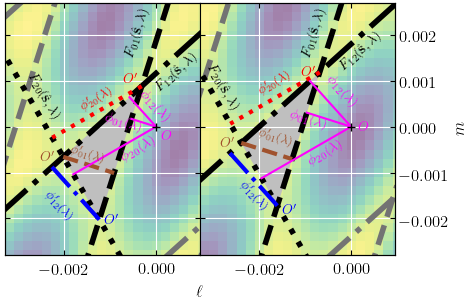

/lustre/aoc/users/nthyagar/projects/CPhaseGeom/figures/closure_phase_uncal_trans.pdf


In [38]:
fig, axs = PLT.subplots(nrows=1, ncols=2, squeeze=1, sharex=True, sharey=False, figsize=(4.7,3))

########### Uncalibrated fringes ############

axs[0].pcolorfast(lvect-0.5*dl, mvect-0.5*dm, net_measfringes_img[:-1,:-1].real, cmap='viridis', alpha=0.5)
axs[0].fill(measvis_points_raveled[:,0], measvis_points_raveled[:,1], fc='0.75')
axs[0].plot(lvect, measfringes_lines_m[0,maxharmonics,:], ls='--', lw=4, color='black')
axs[0].plot(lvect, measfringes_lines_m[0,maxharmonics+1,:], ls='--', lw=4, color='0.45')
axs[0].plot(lvect, measfringes_lines_m[0,maxharmonics+2,:], ls='--', lw=4, color='0.65')
axs[0].plot(lvect, measfringes_lines_m[0,maxharmonics-1,:], ls='--', lw=4, color='0.45')
axs[0].plot(lvect, measfringes_lines_m[0,maxharmonics-2,:], ls='--', lw=4, color='0.65')
axs[0].plot(lvect, measfringes_lines_m[1,maxharmonics,:], ls='-.', lw=4, color='black')
axs[0].plot(lvect, measfringes_lines_m[1,maxharmonics+1,:], ls='-.', lw=4, color='0.45')
axs[0].plot(lvect, measfringes_lines_m[1,maxharmonics+2,:], ls='-.', lw=4, color='0.65')
axs[0].plot(lvect, measfringes_lines_m[1,maxharmonics-1,:], ls='-.', lw=4, color='0.45')
axs[0].plot(lvect, measfringes_lines_m[1,maxharmonics-2,:], ls='-.', lw=4, color='0.65')
axs[0].plot(lvect, measfringes_lines_m[2,maxharmonics,:], ls=':', lw=4, color='black')
axs[0].plot(lvect, measfringes_lines_m[2,maxharmonics+1,:], ls=':', lw=4, color='0.45')
axs[0].plot(lvect, measfringes_lines_m[2,maxharmonics+2,:], ls=':', lw=4, color='0.65')
axs[0].plot(lvect, measfringes_lines_m[2,maxharmonics-1,:], ls=':', lw=4, color='0.45')
axs[0].plot(lvect, measfringes_lines_m[2,maxharmonics-2,:], ls=':', lw=4, color='0.65')
axs[0].text(-7e-4, 1.45e-3, r'$F_{01}(\hat{\mathbf{s}},\lambda)$', ha='left', va='bottom', transform=axs[0].transData, fontsize=10, color='black', rotation=NP.degrees(NP.arctan(fringe_slopes[0])))
axs[0].text(-0.5e-4, 1.65e-3, r'$F_{12}(\hat{\mathbf{s}},\lambda)$', ha='left', va='top', transform=axs[0].transData, fontsize=10, color='black', rotation=NP.degrees(NP.arctan(fringe_slopes[1])))
axs[0].text(-2.9e-3, 1.2e-3, r'$F_{20}(\hat{\mathbf{s}},\lambda)$', ha='left', va='top', transform=axs[0].transData, fontsize=10, color='black', rotation=NP.degrees(NP.arctan(fringe_slopes[2])))

axs[0].plot(NP.asarray([measvis_points_raveled[0,0], measvis_perp_intersection_opp_fringe[0,0]]), NP.asarray([measvis_points_raveled[0,1], measvis_perp_intersection_opp_fringe[0,1]]), ls=':', lw=3, color='red')
axs[0].plot(NP.asarray([measvis_points_raveled[1,0], measvis_perp_intersection_opp_fringe[1,0]]), NP.asarray([measvis_points_raveled[1,1], measvis_perp_intersection_opp_fringe[1,1]]), ls='--', lw=3, color='sienna')
axs[0].plot(NP.asarray([measvis_points_raveled[2,0], measvis_perp_intersection_opp_fringe[2,0]]), NP.asarray([measvis_points_raveled[2,1], measvis_perp_intersection_opp_fringe[2,1]]), ls='-.', lw=3, color='blue')
axs[0].text(0.5*(measvis_points_raveled[0,0]+measvis_perp_intersection_opp_fringe[0,0]), 2.5e-4+0.5*(measvis_points_raveled[0,1]+measvis_perp_intersection_opp_fringe[0,1]), r'$\phi_{20}^\prime(\lambda)$', ha='center', va='center', transform=axs[0].transData, fontsize=9, color='red', rotation=NP.degrees(NP.arctan(perp_fringe_slopes_roll1[0])))
axs[0].text(0.45*(measvis_points_raveled[1,0]+transvis_perp_intersection_opp_fringe[1,0]), 2e-4+0.5*(measvis_points_raveled[1,1]+measvis_perp_intersection_opp_fringe[1,1]), r'$\phi_{01}^\prime(\lambda)$', ha='center', va='center', transform=axs[0].transData, fontsize=9, color='sienna', rotation=NP.degrees(NP.arctan(perp_fringe_slopes_roll1[1])))
axs[0].text(-2e-4+0.5*(measvis_points_raveled[2,0]+transvis_perp_intersection_opp_fringe[2,0]), -3e-4+0.5*(measvis_points_raveled[2,1]+measvis_perp_intersection_opp_fringe[2,1]), r'$\phi_{12}^\prime(\lambda)$', ha='center', va='center', transform=axs[0].transData, fontsize=9, color='blue', rotation=NP.degrees(NP.arctan(perp_fringe_slopes_roll1[2])))

axs[0].plot(NP.asarray([origin[0,0], measvis_origin_perp_intersection_opp_fringe[0,0]]), NP.asarray([origin[0,1], measvis_origin_perp_intersection_opp_fringe[0,1]]), ls='-', lw=1.5, color='magenta')
axs[0].plot(NP.asarray([origin[1,0], measvis_origin_perp_intersection_opp_fringe[1,0]]), NP.asarray([origin[1,1], measvis_origin_perp_intersection_opp_fringe[1,1]]), ls='-', lw=1.5, color='magenta')
axs[0].plot(NP.asarray([origin[2,0], measvis_origin_perp_intersection_opp_fringe[2,0]]), NP.asarray([origin[2,1], measvis_origin_perp_intersection_opp_fringe[2,1]]), ls='-', lw=1.5, color='magenta')
axs[0].text(1e-4+0.5*measvis_origin_perp_intersection_opp_fringe[0,0], 0.5*measvis_origin_perp_intersection_opp_fringe[0,1], r'$\phi_{20}(\lambda)$', ha='left', va='center', transform=axs[0].transData, fontsize=10, color='magenta', rotation=NP.degrees(NP.arctan(perp_fringe_slopes_roll1[0])))
axs[0].text(0.5*measvis_origin_perp_intersection_opp_fringe[1,0], 2.3e-4+0.5*measvis_origin_perp_intersection_opp_fringe[1,1], r'$\phi_{01}(\lambda)$', ha='right', va='top', transform=axs[0].transData, fontsize=10, color='magenta', rotation=NP.degrees(NP.arctan(perp_fringe_slopes_roll1[1])))
axs[0].text(1e-4+0.25*measvis_origin_perp_intersection_opp_fringe[2,0], 1e-4+0.5*measvis_origin_perp_intersection_opp_fringe[2,1], r'$\phi_{12}(\lambda)$', ha='center', va='center', transform=axs[0].transData, fontsize=10, color='magenta', rotation=NP.degrees(NP.arctan(perp_fringe_slopes_roll1[2])))

axs[0].plot(0, 0, ls='none', marker='+', ms=6, color='black')
axs[0].text(1e-4, -2e-4, r'$O$', ha='left', va='center', color='magenta', fontsize=10, weight='extra bold')
axs[0].text(-1e-4+measvis_points_raveled[0,0], measvis_points_raveled[0,1], r'$O^\prime$', ha='right', va='bottom', color='red', fontsize=10, weight='extra bold')
axs[0].text(-2e-4+measvis_points_raveled[1,0], measvis_points_raveled[1,1], r'$O^\prime$', ha='right', va='center', color='sienna', fontsize=10, weight='extra bold')
axs[0].text(1e-4+measvis_points_raveled[2,0], measvis_points_raveled[2,1], r'$O^\prime$', ha='left', va='center', color='blue', fontsize=10, weight='extra bold')

axs[0].set_xlim(-0.0033,0.00095)
axs[0].set_ylim(-0.0028,0.0027)
axs[0].set_aspect('equal')
yticklocs = axs[0].get_yticks()
yticklabels = [item.get_text() for item in axs[0].get_yticklabels()]
empty_string_labels = ['']*len(yticklabels)
axs[0].set_yticklabels(empty_string_labels)
axs[0].grid(which='both', color='white')
axs[0].tick_params(bottom=True, top=True, left=True, right=True)
axs[0].tick_params(labelbottom=True, labeltop=False, labelleft=False, labelright=True)

########### Translated fringes ############

axs[1].pcolorfast(lvect-0.5*dl, mvect-0.5*dm, net_transfringes_img[:-1,:-1].real, cmap='viridis', alpha=0.5)
axs[1].fill(transvis_points_raveled[:,0], transvis_points_raveled[:,1], fc='0.75')
axs[1].plot(lvect, transfringes_lines_m[0,maxharmonics,:], ls='--', lw=4, color='black')
axs[1].plot(lvect, transfringes_lines_m[0,maxharmonics+1,:], ls='--', lw=4, color='0.45')
axs[1].plot(lvect, transfringes_lines_m[0,maxharmonics+2,:], ls='--', lw=4, color='0.65')
axs[1].plot(lvect, transfringes_lines_m[0,maxharmonics-1,:], ls='--', lw=4, color='0.45')
axs[1].plot(lvect, transfringes_lines_m[0,maxharmonics-2,:], ls='--', lw=4, color='0.65')
axs[1].plot(lvect, transfringes_lines_m[1,maxharmonics,:], ls='-.', lw=4, color='black')
axs[1].plot(lvect, transfringes_lines_m[1,maxharmonics+1,:], ls='-.', lw=4, color='0.45')
axs[1].plot(lvect, transfringes_lines_m[1,maxharmonics+2,:], ls='-.', lw=4, color='0.65')
axs[1].plot(lvect, transfringes_lines_m[1,maxharmonics-1,:], ls='-.', lw=4, color='0.45')
axs[1].plot(lvect, transfringes_lines_m[1,maxharmonics-2,:], ls='-.', lw=4, color='0.65')
axs[1].plot(lvect, transfringes_lines_m[2,maxharmonics,:], ls=':', lw=4, color='black')
axs[1].plot(lvect, transfringes_lines_m[2,maxharmonics+1,:], ls=':', lw=4, color='0.45')
axs[1].plot(lvect, transfringes_lines_m[2,maxharmonics+2,:], ls=':', lw=4, color='0.65')
axs[1].plot(lvect, transfringes_lines_m[2,maxharmonics-1,:], ls=':', lw=4, color='0.45')
axs[1].plot(lvect, transfringes_lines_m[2,maxharmonics-2,:], ls=':', lw=4, color='0.65')

axs[1].text(-1.1e-3, 1.45e-3, r'$F_{01}(\hat{\mathbf{s}},\lambda)$', ha='left', va='bottom', transform=axs[1].transData, fontsize=10, color='black', rotation=NP.degrees(NP.arctan(fringe_slopes[0])))
axs[1].text(-3e-4, 2.1e-3, r'$F_{12}(\hat{\mathbf{s}},\lambda)$', ha='left', va='top', transform=axs[1].transData, fontsize=10, color='black', rotation=NP.degrees(NP.arctan(fringe_slopes[1])))
axs[1].text(-3.25e-3, 1.4e-3, r'$F_{20}(\hat{\mathbf{s}},\lambda)$', ha='left', va='top', transform=axs[1].transData, fontsize=10, color='black', rotation=NP.degrees(NP.arctan(fringe_slopes[2])))

axs[1].plot(NP.asarray([transvis_points_raveled[0,0], transvis_perp_intersection_opp_fringe[0,0]]), NP.asarray([transvis_points_raveled[0,1], transvis_perp_intersection_opp_fringe[0,1]]), ls=':', lw=3, color='red')
axs[1].plot(NP.asarray([transvis_points_raveled[1,0], transvis_perp_intersection_opp_fringe[1,0]]), NP.asarray([transvis_points_raveled[1,1], transvis_perp_intersection_opp_fringe[1,1]]), ls='--', lw=3, color='sienna')
axs[1].plot(NP.asarray([transvis_points_raveled[2,0], transvis_perp_intersection_opp_fringe[2,0]]), NP.asarray([transvis_points_raveled[2,1], transvis_perp_intersection_opp_fringe[2,1]]), ls='-.', lw=3, color='blue')
axs[1].text(0.5*(transvis_points_raveled[0,0]+transvis_perp_intersection_opp_fringe[0,0]), 3e-4+0.5*(transvis_points_raveled[0,1]+transvis_perp_intersection_opp_fringe[0,1]), r'$\phi_{20}^\prime(\lambda)$', ha='center', va='center', transform=axs[1].transData, fontsize=9, color='red', rotation=NP.degrees(NP.arctan(perp_fringe_slopes_roll1[0])))
axs[1].text(0.45*(transvis_points_raveled[1,0]+transvis_perp_intersection_opp_fringe[1,0]), 2.5e-4+0.5*(transvis_points_raveled[1,1]+transvis_perp_intersection_opp_fringe[1,1]), r'$\phi_{01}^\prime(\lambda)$', ha='center', va='center', transform=axs[1].transData, fontsize=9, color='sienna', rotation=NP.degrees(NP.arctan(perp_fringe_slopes_roll1[1])))
axs[1].text(0.5*(transvis_points_raveled[2,0]+transvis_perp_intersection_opp_fringe[2,0]), -4e-4+0.5*(transvis_points_raveled[2,1]+transvis_perp_intersection_opp_fringe[2,1]), r'$\phi_{12}^\prime(\lambda)$', ha='center', va='center', transform=axs[1].transData, fontsize=9, color='blue', rotation=NP.degrees(NP.arctan(perp_fringe_slopes_roll1[2])))

axs[1].plot(NP.asarray([origin[0,0], transvis_origin_perp_intersection_opp_fringe[0,0]]), NP.asarray([origin[0,1], transvis_origin_perp_intersection_opp_fringe[0,1]]), ls='-', lw=1.5, color='magenta')
axs[1].plot(NP.asarray([origin[1,0], transvis_origin_perp_intersection_opp_fringe[1,0]]), NP.asarray([origin[1,1], transvis_origin_perp_intersection_opp_fringe[1,1]]), ls='-', lw=1.5, color='magenta')
axs[1].plot(NP.asarray([origin[2,0], transvis_origin_perp_intersection_opp_fringe[2,0]]), NP.asarray([origin[2,1], transvis_origin_perp_intersection_opp_fringe[2,1]]), ls='-', lw=1.5, color='magenta')
axs[1].text(0.5*transvis_origin_perp_intersection_opp_fringe[0,0], 3e-4+0.5*transvis_origin_perp_intersection_opp_fringe[0,1], r'$\phi_{20}(\lambda)$', ha='left', va='top', transform=axs[1].transData, fontsize=10, color='magenta', rotation=NP.degrees(NP.arctan(perp_fringe_slopes_roll1[0])))
axs[1].text(0.5*transvis_origin_perp_intersection_opp_fringe[1,0], 2.3e-4+0.5*transvis_origin_perp_intersection_opp_fringe[1,1], r'$\phi_{01}(\lambda)$', ha='right', va='top', transform=axs[1].transData, fontsize=10, color='magenta', rotation=NP.degrees(NP.arctan(perp_fringe_slopes_roll1[1])))
axs[1].text(0.25*transvis_origin_perp_intersection_opp_fringe[2,0], 2.5e-4+0.5*transvis_origin_perp_intersection_opp_fringe[2,1], r'$\phi_{12}(\lambda)$', ha='center', va='center', transform=axs[1].transData, fontsize=10, color='magenta', rotation=NP.degrees(NP.arctan(perp_fringe_slopes_roll1[2])))

axs[1].plot(0, 0, ls='none', marker='+', ms=6, color='black')
axs[1].text(0.00015, 0, r'$O$', ha='left', va='center', color='magenta', fontsize=10, weight='extra bold')
axs[1].text(-0.0001+transvis_points_raveled[0,0], transvis_points_raveled[0,1], r'$O^\prime$', ha='right', va='center', color='red', fontsize=10, weight='extra bold')
axs[1].text(-0.00016+transvis_points_raveled[1,0], transvis_points_raveled[1,1], r'$O^\prime$', ha='right', va='center', color='sienna', fontsize=10, weight='extra bold')
axs[1].text(0.0001+transvis_points_raveled[2,0], -0.0001+transvis_points_raveled[2,1], r'$O^\prime$', ha='left', va='center', color='blue', fontsize=10, weight='extra bold')

axs[1].set_xlim(-0.0033,0.00095)
axs[1].set_ylim(-0.0028,0.0027)
axs[1].set_aspect('equal')
axs[1].yaxis.tick_right()
axs[1].yaxis.set_label_position('right')
axs[1].grid(which='both', color='white')
axs[1].tick_params(bottom=True, top=True, left=True, right=True)
axs[1].tick_params(labelbottom=True, labeltop=False, labelleft=False, labelright=True)

fig.subplots_adjust(wspace=0, hspace=0)
fig.subplots_adjust(left=0.01, right=0.84, bottom=0.15, top=0.99)

big_ax = fig.add_subplot(111)
big_ax.set_facecolor('none') # matplotlib.__version__ >= 2.0.0
# big_ax.set_axis_bgcolor('none') # matplotlib.__version__ < 2.0.0
big_ax.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
big_ax.set_xticks([])
big_ax.set_yticks([])
big_ax.set_xlabel(r'$\ell$', fontsize=12, weight='medium', labelpad=20)
big_ax.set_ylabel(r'$m$', fontsize=12, weight='medium', labelpad=40)
big_ax.yaxis.set_label_position('right')

PLT.savefig(figdir+'closure_phase_uncal_trans.pdf', bbox_inches=0)
print(figdir+'closure_phase_uncal_trans.pdf')

In [ ]:
# fig, axs = PLT.subplots(nrows=1, ncols=2, squeeze=1, sharex=True, sharey=False, figsize=(4.7,3))

# ########### Uncalibrated fringes ############

# axs[0].pcolorfast(lvect-0.5*dl, mvect-0.5*dm, net_measfringes_img[:-1,:-1].real, cmap='viridis', alpha=0.5)
# axs[0].fill(measvis_points_raveled[:,0], measvis_points_raveled[:,1], fc='0.75')
# axs[0].plot(lvect, measfringes_lines_m[0,maxharmonics,:], ls='--', lw=4, color='black')
# axs[0].plot(lvect, measfringes_lines_m[0,maxharmonics+1,:], ls='--', lw=4, color='0.45')
# axs[0].plot(lvect, measfringes_lines_m[0,maxharmonics+2,:], ls='--', lw=4, color='0.65')
# axs[0].plot(lvect, measfringes_lines_m[0,maxharmonics-1,:], ls='--', lw=4, color='0.45')
# axs[0].plot(lvect, measfringes_lines_m[0,maxharmonics-2,:], ls='--', lw=4, color='0.65')
# axs[0].plot(lvect, measfringes_lines_m[1,maxharmonics,:], ls='-.', lw=4, color='black')
# axs[0].plot(lvect, measfringes_lines_m[1,maxharmonics+1,:], ls='-.', lw=4, color='0.45')
# axs[0].plot(lvect, measfringes_lines_m[1,maxharmonics+2,:], ls='-.', lw=4, color='0.65')
# axs[0].plot(lvect, measfringes_lines_m[1,maxharmonics-1,:], ls='-.', lw=4, color='0.45')
# axs[0].plot(lvect, measfringes_lines_m[1,maxharmonics-2,:], ls='-.', lw=4, color='0.65')
# axs[0].plot(lvect, measfringes_lines_m[2,maxharmonics,:], ls=':', lw=4, color='black')
# axs[0].plot(lvect, measfringes_lines_m[2,maxharmonics+1,:], ls=':', lw=4, color='0.45')
# axs[0].plot(lvect, measfringes_lines_m[2,maxharmonics+2,:], ls=':', lw=4, color='0.65')
# axs[0].plot(lvect, measfringes_lines_m[2,maxharmonics-1,:], ls=':', lw=4, color='0.45')
# axs[0].plot(lvect, measfringes_lines_m[2,maxharmonics-2,:], ls=':', lw=4, color='0.65')
# axs[0].text(-7e-4, 1.45e-3, r'$F_{12}(\hat{\mathbf{s}},\lambda)$', ha='left', va='bottom', transform=axs[0].transData, fontsize=10, color='black', rotation=NP.degrees(NP.arctan(fringe_slopes[0])))
# axs[0].text(-1.5e-4, 1.75e-3, r'$F_{23}(\hat{\mathbf{s}},\lambda)$', ha='left', va='top', transform=axs[0].transData, fontsize=10, color='black', rotation=NP.degrees(NP.arctan(fringe_slopes[1])))
# axs[0].text(-2.9e-3, 1.2e-3, r'$F_{31}(\hat{\mathbf{s}},\lambda)$', ha='left', va='top', transform=axs[0].transData, fontsize=10, color='black', rotation=NP.degrees(NP.arctan(fringe_slopes[2])))

# axs[0].plot(NP.asarray([measvis_points_raveled[0,0], measvis_perp_intersection_opp_fringe[0,0]]), NP.asarray([measvis_points_raveled[0,1], measvis_perp_intersection_opp_fringe[0,1]]), ls=':', lw=3, color='red')
# axs[0].plot(NP.asarray([measvis_points_raveled[1,0], measvis_perp_intersection_opp_fringe[1,0]]), NP.asarray([measvis_points_raveled[1,1], measvis_perp_intersection_opp_fringe[1,1]]), ls='--', lw=3, color='darkgreen')
# axs[0].plot(NP.asarray([measvis_points_raveled[2,0], measvis_perp_intersection_opp_fringe[2,0]]), NP.asarray([measvis_points_raveled[2,1], measvis_perp_intersection_opp_fringe[2,1]]), ls='-.', lw=3, color='blue')
# axs[0].text(0.5*(measvis_points_raveled[0,0]+measvis_perp_intersection_opp_fringe[0,0]), 2.5e-4+0.5*(measvis_points_raveled[0,1]+measvis_perp_intersection_opp_fringe[0,1]), r'$\phi_{31}^\prime(\lambda)$', ha='center', va='center', transform=axs[0].transData, fontsize=9, color='red', rotation=NP.degrees(NP.arctan(perp_fringe_slopes_roll1[0])))
# axs[0].text(0.45*(measvis_points_raveled[1,0]+transvis_perp_intersection_opp_fringe[1,0]), 2e-4+0.5*(measvis_points_raveled[1,1]+measvis_perp_intersection_opp_fringe[1,1]), r'$\phi_{12}^\prime(\lambda)$', ha='center', va='center', transform=axs[0].transData, fontsize=9, color='darkgreen', rotation=NP.degrees(NP.arctan(perp_fringe_slopes_roll1[1])))
# axs[0].text(-2e-4+0.5*(measvis_points_raveled[2,0]+transvis_perp_intersection_opp_fringe[2,0]), -3e-4+0.5*(measvis_points_raveled[2,1]+measvis_perp_intersection_opp_fringe[2,1]), r'$\phi_{23}^\prime(\lambda)$', ha='center', va='center', transform=axs[0].transData, fontsize=9, color='blue', rotation=NP.degrees(NP.arctan(perp_fringe_slopes_roll1[2])))

# axs[0].plot(NP.asarray([origin[0,0], measvis_origin_perp_intersection_opp_fringe[0,0]]), NP.asarray([origin[0,1], measvis_origin_perp_intersection_opp_fringe[0,1]]), ls='-', lw=1.5, color='magenta')
# axs[0].plot(NP.asarray([origin[1,0], measvis_origin_perp_intersection_opp_fringe[1,0]]), NP.asarray([origin[1,1], measvis_origin_perp_intersection_opp_fringe[1,1]]), ls='-', lw=1.5, color='magenta')
# axs[0].plot(NP.asarray([origin[2,0], measvis_origin_perp_intersection_opp_fringe[2,0]]), NP.asarray([origin[2,1], measvis_origin_perp_intersection_opp_fringe[2,1]]), ls='-', lw=1.5, color='magenta')
# axs[0].text(1e-4+0.5*measvis_origin_perp_intersection_opp_fringe[0,0], 0.5*measvis_origin_perp_intersection_opp_fringe[0,1], r'$\phi_{31}(\lambda)$', ha='left', va='center', transform=axs[0].transData, fontsize=10, color='magenta', rotation=NP.degrees(NP.arctan(perp_fringe_slopes_roll1[0])))
# axs[0].text(0.5*measvis_origin_perp_intersection_opp_fringe[1,0], 2.3e-4+0.5*measvis_origin_perp_intersection_opp_fringe[1,1], r'$\phi_{12}(\lambda)$', ha='right', va='top', transform=axs[0].transData, fontsize=10, color='magenta', rotation=NP.degrees(NP.arctan(perp_fringe_slopes_roll1[1])))
# axs[0].text(1e-4+0.25*measvis_origin_perp_intersection_opp_fringe[2,0], 1e-4+0.5*measvis_origin_perp_intersection_opp_fringe[2,1], r'$\phi_{23}(\lambda)$', ha='center', va='center', transform=axs[0].transData, fontsize=10, color='magenta', rotation=NP.degrees(NP.arctan(perp_fringe_slopes_roll1[2])))

# axs[0].plot(0, 0, ls='none', marker='+', ms=6, color='black')
# axs[0].text(1e-4, -2e-4, r'$O$', ha='left', va='center', color='magenta', fontsize=10, weight='extra bold')
# axs[0].text(-1e-4+measvis_points_raveled[0,0], measvis_points_raveled[0,1], r'$O^\prime$', ha='right', va='bottom', color='red', fontsize=10, weight='extra bold')
# axs[0].text(-1.5e-4+measvis_points_raveled[1,0], measvis_points_raveled[1,1], r'$O^\prime$', ha='right', va='center', color='darkgreen', fontsize=10, weight='extra bold')
# axs[0].text(1e-4+measvis_points_raveled[2,0], measvis_points_raveled[2,1], r'$O^\prime$', ha='left', va='center', color='blue', fontsize=10, weight='extra bold')

# axs[0].set_xlim(-0.0033,0.00095)
# axs[0].set_ylim(-0.0028,0.0027)
# axs[0].set_aspect('equal')
# yticklocs = axs[0].get_yticks()
# yticklabels = [item.get_text() for item in axs[0].get_yticklabels()]
# empty_string_labels = ['']*len(yticklabels)
# axs[0].set_yticklabels(empty_string_labels)
# axs[0].grid(which='both', color='white')
# axs[0].tick_params(bottom=True, top=True, left=True, right=True)
# axs[0].tick_params(labelbottom=True, labeltop=False, labelleft=False, labelright=True)

# ########### Translated fringes ############

# axs[1].pcolorfast(lvect-0.5*dl, mvect-0.5*dm, net_transfringes_img[:-1,:-1].real, cmap='viridis', alpha=0.5)
# axs[1].fill(transvis_points_raveled[:,0], transvis_points_raveled[:,1], fc='0.75')
# axs[1].plot(lvect, transfringes_lines_m[0,maxharmonics,:], ls='--', lw=4, color='black')
# axs[1].plot(lvect, transfringes_lines_m[0,maxharmonics+1,:], ls='--', lw=4, color='0.45')
# axs[1].plot(lvect, transfringes_lines_m[0,maxharmonics+2,:], ls='--', lw=4, color='0.65')
# axs[1].plot(lvect, transfringes_lines_m[0,maxharmonics-1,:], ls='--', lw=4, color='0.45')
# axs[1].plot(lvect, transfringes_lines_m[0,maxharmonics-2,:], ls='--', lw=4, color='0.65')
# axs[1].plot(lvect, transfringes_lines_m[1,maxharmonics,:], ls='-.', lw=4, color='black')
# axs[1].plot(lvect, transfringes_lines_m[1,maxharmonics+1,:], ls='-.', lw=4, color='0.45')
# axs[1].plot(lvect, transfringes_lines_m[1,maxharmonics+2,:], ls='-.', lw=4, color='0.65')
# axs[1].plot(lvect, transfringes_lines_m[1,maxharmonics-1,:], ls='-.', lw=4, color='0.45')
# axs[1].plot(lvect, transfringes_lines_m[1,maxharmonics-2,:], ls='-.', lw=4, color='0.65')
# axs[1].plot(lvect, transfringes_lines_m[2,maxharmonics,:], ls=':', lw=4, color='black')
# axs[1].plot(lvect, transfringes_lines_m[2,maxharmonics+1,:], ls=':', lw=4, color='0.45')
# axs[1].plot(lvect, transfringes_lines_m[2,maxharmonics+2,:], ls=':', lw=4, color='0.65')
# axs[1].plot(lvect, transfringes_lines_m[2,maxharmonics-1,:], ls=':', lw=4, color='0.45')
# axs[1].plot(lvect, transfringes_lines_m[2,maxharmonics-2,:], ls=':', lw=4, color='0.65')

# axs[1].text(-1.1e-3, 1.45e-3, r'$F_{12}(\hat{\mathbf{s}},\lambda)$', ha='left', va='bottom', transform=axs[1].transData, fontsize=10, color='black', rotation=NP.degrees(NP.arctan(fringe_slopes[0])))
# axs[1].text(-3e-4, 2.1e-3, r'$F_{23}(\hat{\mathbf{s}},\lambda)$', ha='left', va='top', transform=axs[1].transData, fontsize=10, color='black', rotation=NP.degrees(NP.arctan(fringe_slopes[1])))
# axs[1].text(-3.25e-3, 1.4e-3, r'$F_{31}(\hat{\mathbf{s}},\lambda)$', ha='left', va='top', transform=axs[1].transData, fontsize=10, color='black', rotation=NP.degrees(NP.arctan(fringe_slopes[2])))

# axs[1].plot(NP.asarray([transvis_points_raveled[0,0], transvis_perp_intersection_opp_fringe[0,0]]), NP.asarray([transvis_points_raveled[0,1], transvis_perp_intersection_opp_fringe[0,1]]), ls=':', lw=3, color='red')
# axs[1].plot(NP.asarray([transvis_points_raveled[1,0], transvis_perp_intersection_opp_fringe[1,0]]), NP.asarray([transvis_points_raveled[1,1], transvis_perp_intersection_opp_fringe[1,1]]), ls='--', lw=3, color='darkgreen')
# axs[1].plot(NP.asarray([transvis_points_raveled[2,0], transvis_perp_intersection_opp_fringe[2,0]]), NP.asarray([transvis_points_raveled[2,1], transvis_perp_intersection_opp_fringe[2,1]]), ls='-.', lw=3, color='blue')
# axs[1].text(0.5*(transvis_points_raveled[0,0]+transvis_perp_intersection_opp_fringe[0,0]), 3e-4+0.5*(transvis_points_raveled[0,1]+transvis_perp_intersection_opp_fringe[0,1]), r'$\phi_{31}^\prime(\lambda)$', ha='center', va='center', transform=axs[1].transData, fontsize=9, color='red', rotation=NP.degrees(NP.arctan(perp_fringe_slopes_roll1[0])))
# axs[1].text(0.45*(transvis_points_raveled[1,0]+transvis_perp_intersection_opp_fringe[1,0]), 2.5e-4+0.5*(transvis_points_raveled[1,1]+transvis_perp_intersection_opp_fringe[1,1]), r'$\phi_{12}^\prime(\lambda)$', ha='center', va='center', transform=axs[1].transData, fontsize=9, color='darkgreen', rotation=NP.degrees(NP.arctan(perp_fringe_slopes_roll1[1])))
# axs[1].text(0.5*(transvis_points_raveled[2,0]+transvis_perp_intersection_opp_fringe[2,0]), -4e-4+0.5*(transvis_points_raveled[2,1]+transvis_perp_intersection_opp_fringe[2,1]), r'$\phi_{23}^\prime(\lambda)$', ha='center', va='center', transform=axs[1].transData, fontsize=9, color='blue', rotation=NP.degrees(NP.arctan(perp_fringe_slopes_roll1[2])))

# axs[1].plot(NP.asarray([origin[0,0], transvis_origin_perp_intersection_opp_fringe[0,0]]), NP.asarray([origin[0,1], transvis_origin_perp_intersection_opp_fringe[0,1]]), ls='-', lw=1.5, color='magenta')
# axs[1].plot(NP.asarray([origin[1,0], transvis_origin_perp_intersection_opp_fringe[1,0]]), NP.asarray([origin[1,1], transvis_origin_perp_intersection_opp_fringe[1,1]]), ls='-', lw=1.5, color='magenta')
# axs[1].plot(NP.asarray([origin[2,0], transvis_origin_perp_intersection_opp_fringe[2,0]]), NP.asarray([origin[2,1], transvis_origin_perp_intersection_opp_fringe[2,1]]), ls='-', lw=1.5, color='magenta')
# axs[1].text(0.5*transvis_origin_perp_intersection_opp_fringe[0,0], 3e-4+0.5*transvis_origin_perp_intersection_opp_fringe[0,1], r'$\phi_{31}(\lambda)$', ha='left', va='top', transform=axs[1].transData, fontsize=10, color='magenta', rotation=NP.degrees(NP.arctan(perp_fringe_slopes_roll1[0])))
# axs[1].text(0.5*transvis_origin_perp_intersection_opp_fringe[1,0], 2.3e-4+0.5*transvis_origin_perp_intersection_opp_fringe[1,1], r'$\phi_{12}(\lambda)$', ha='right', va='top', transform=axs[1].transData, fontsize=10, color='magenta', rotation=NP.degrees(NP.arctan(perp_fringe_slopes_roll1[1])))
# axs[1].text(0.25*transvis_origin_perp_intersection_opp_fringe[2,0], 2.5e-4+0.5*transvis_origin_perp_intersection_opp_fringe[2,1], r'$\phi_{23}(\lambda)$', ha='center', va='center', transform=axs[1].transData, fontsize=10, color='magenta', rotation=NP.degrees(NP.arctan(perp_fringe_slopes_roll1[2])))

# axs[1].plot(0, 0, ls='none', marker='+', ms=6, color='black')
# axs[1].text(0.00015, 0, r'$O$', ha='left', va='center', color='magenta', fontsize=10, weight='extra bold')
# axs[1].text(-0.0001+transvis_points_raveled[0,0], transvis_points_raveled[0,1], r'$O^\prime$', ha='right', va='center', color='red', fontsize=10, weight='extra bold')
# axs[1].text(-0.00013+transvis_points_raveled[1,0], transvis_points_raveled[1,1], r'$O^\prime$', ha='right', va='center', color='darkgreen', fontsize=10, weight='extra bold')
# axs[1].text(0.0001+transvis_points_raveled[2,0], -0.0001+transvis_points_raveled[2,1], r'$O^\prime$', ha='left', va='center', color='blue', fontsize=10, weight='extra bold')

# axs[1].set_xlim(-0.0033,0.00095)
# axs[1].set_ylim(-0.0028,0.0027)
# axs[1].set_aspect('equal')
# axs[1].yaxis.tick_right()
# axs[1].yaxis.set_label_position('right')
# axs[1].grid(which='both', color='white')
# axs[1].tick_params(bottom=True, top=True, left=True, right=True)
# axs[1].tick_params(labelbottom=True, labeltop=False, labelleft=False, labelright=True)

# fig.subplots_adjust(wspace=0, hspace=0)
# fig.subplots_adjust(left=0.01, right=0.84, bottom=0.15, top=0.99)

# big_ax = fig.add_subplot(111)
# big_ax.set_facecolor('none') # matplotlib.__version__ >= 2.0.0
# # big_ax.set_axis_bgcolor('none') # matplotlib.__version__ < 2.0.0
# big_ax.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
# big_ax.set_xticks([])
# big_ax.set_yticks([])
# big_ax.set_xlabel(r'$l$', fontsize=10, weight='medium', labelpad=20)
# big_ax.set_ylabel(r'$m$', fontsize=10, weight='medium', labelpad=40)
# big_ax.yaxis.set_label_position('right')

# PLT.savefig(figdir+'closure_phase_uncal_trans.pdf', bbox_inches=0)
# print(figdir+'closure_phase_uncal_trans.pdf')

In [39]:
print(skyvis_points_raveled)

[[-0.00013541  0.00168745]
 [-0.00184835  0.00014581]
 [-0.0010604  -0.00122454]]


In [40]:
areatri_img_skyvis = GEOM.polygonArea2D(skyvis_points_raveled, absolute=False) 
areatri_img_measvis = GEOM.polygonArea2D(measvis_points_raveled, absolute=False)
areatri_aprtr = GEOM.polygonArea2D((antpos/wl).decompose().value, absolute=False)
cphase = NP.sum(skyvisphase) * U.rad

In [41]:
print(areatri_img_skyvis)
print(areatri_img_measvis)
print(areatri_aprtr)
print(cphase)

1.7810294547684326e-06
1.7810294547684333e-06
34410.43083900226
-3.11093165536 rad


In [42]:
print(16 * (NP.pi**2) * areatri_img_skyvis * areatri_aprtr / (cphase.si.value**2)) # Verify the area relation for ideal fringes
print(16 * (NP.pi**2) * areatri_img_measvis * areatri_aprtr / (cphase.si.value**2)) # Verify the area relation for uncalibrated fringes

1.0
1.0000000000000004


In [43]:
lmat_123 = NP.hstack((-skyvisphase[[0,1]].reshape(-1,1), uvvect[[0,1],1].decompose().value.reshape(-1,1)))
lmat_231 = NP.hstack((-skyvisphase[[1,2]].reshape(-1,1), uvvect[[1,2],1].decompose().value.reshape(-1,1)))
lmat_312 = NP.hstack((-skyvisphase[[2,0]].reshape(-1,1), uvvect[[2,0],1].decompose().value.reshape(-1,1)))

mmat_123 = NP.hstack((uvvect[[0,1],0].decompose().value.reshape(-1,1), -skyvisphase[[0,1]].reshape(-1,1)))
mmat_231 = NP.hstack((uvvect[[1,2],0].decompose().value.reshape(-1,1), -skyvisphase[[1,2]].reshape(-1,1)))
mmat_312 = NP.hstack((uvvect[[2,0],0].decompose().value.reshape(-1,1), -skyvisphase[[2,0]].reshape(-1,1)))

c_123 = (4*NP.pi**2) * LA.det(NP.hstack((uvvect[[0,1],0].decompose().value.reshape(-1,1), uvvect[[0,1],1].decompose().value.reshape(-1,1))))
c_231 = (4*NP.pi**2) * LA.det(NP.hstack((uvvect[[1,2],0].decompose().value.reshape(-1,1), uvvect[[1,2],1].decompose().value.reshape(-1,1))))
c_312 = (4*NP.pi**2) * LA.det(NP.hstack((uvvect[[2,0],0].decompose().value.reshape(-1,1), uvvect[[2,0],1].decompose().value.reshape(-1,1))))

In [44]:
lmat = NP.concatenate((lmat_123[NP.newaxis,...], lmat_231[NP.newaxis,...], lmat_312[NP.newaxis,...]), axis=0)
mmat = NP.concatenate((mmat_123[NP.newaxis,...], mmat_231[NP.newaxis,...], mmat_312[NP.newaxis,...]), axis=0)
cmat = NP.asarray([c_123, c_231, c_312])

lvals = 2*NP.pi*LA.det(lmat) / cmat
mvals = 2*NP.pi*LA.det(mmat) / cmat

lmverts = NP.hstack((lvals.reshape(-1,1), mvals.reshape(-1,1)))

In [45]:
print(lmverts)
print(skyvis_points_raveled) # Verify it is identical to lmverts derived independently

[[-0.00013541  0.00168745]
 [-0.00184835  0.00014581]
 [-0.0010604  -0.00122454]]
[[-0.00013541  0.00168745]
 [-0.00184835  0.00014581]
 [-0.0010604  -0.00122454]]


In [46]:
print(cmat)
print(cmat / (8*(NP.pi**2)*areatri_aprtr))

[2716938.71721598 2716938.71721598 2716938.71721598]
[1. 1. 1.]


In [47]:
antpos_area = GEOM.polygonArea2D(antpos, absolute=False)
print(antpos)
print(antpos_area)
print((antpos_area/wl**2).si)

[[  0.   2.]
 [ 85. -25.]
 [ 40.  25.]] m
1517.5 m2
34410.430839


# Work on 3C286 FITS image

In [48]:
# datadir_3c286 = datadir + '3C286/image/4min/'
datadir_3c286 = datadir + '3C286/image/20sec/'

## Read image information

In [49]:
# imgfilenames = {'bl-fringes': ['0913.fits', '0919.fits', '1319.fits'], 'triad-fringes': {'cal': '091319.fits', 'uncal': '091319u.fits'}}
imgfilenames = {'bl-fringes': {'cal': ['0913.fits', '0919.fits', '1319.fits'], 'uncal': ['0913u.fits', '0919u.fits', '1319u.fits'], 'blerr': ['0913cb.fits', '0919.fits', '1319.fits']}, 'triad-fringes': {'cal': '3fringecal.fits', 'uncal': '3fringeuncal.fits', 'blerr': '3fringeblerr.fits'}}
imghdrs = {}
imgdata = {}
for calkey in imgfilenames['bl-fringes']:
    for fname in imgfilenames['bl-fringes'][calkey]:
        try:
            with fits.open(datadir_3c286+fname, mode='readonly') as hdul:
                imghdrs[fname] = hdul[0].header
                imgdata[fname] = hdul[0].data
        except IOError as err:
            print(err)
    
for fname in imgfilenames['bl-fringes']['cal']:
    with fits.open(datadir_3c286+fname, mode='readonly') as hdul:
        imghdrs[fname] = hdul[0].header
        imgdata[fname] = hdul[0].data
with fits.open(datadir_3c286+imgfilenames['triad-fringes']['cal'], mode='readonly') as hdul:
    imghdrs[imgfilenames['triad-fringes']['cal']] = hdul[0].header
    imgdata[imgfilenames['triad-fringes']['cal']] = hdul[0].data
with fits.open(datadir_3c286+imgfilenames['triad-fringes']['uncal'], mode='readonly') as hdul:
    imghdrs[imgfilenames['triad-fringes']['uncal']] = hdul[0].header
    imgdata[imgfilenames['triad-fringes']['uncal']] = hdul[0].data
with fits.open(datadir_3c286+imgfilenames['triad-fringes']['blerr'], mode='readonly') as hdul:
    imghdrs[imgfilenames['triad-fringes']['blerr']] = hdul[0].header
    imgdata[imgfilenames['triad-fringes']['blerr']] = hdul[0].data

## Combine two fringes at a time

In [50]:
imgdata['two-fringes'] = {}
for calkey in imgfilenames['bl-fringes']:
    imgdata['two-fringes'][calkey] = {}
    for fnamei,fname in enumerate(imgfilenames['bl-fringes'][calkey]):
        fname_next = imgfilenames['bl-fringes'][calkey][(fnamei+1)%3]
        fkey_out = '{0}+{1}'.format(fname.split('.fits')[0], fname_next.split('.fits')[0])
        print('{0} + {1} --> {2}'.format(fname, fname_next, fkey_out))
        imgdata['two-fringes'][calkey][fkey_out] = imgdata[fname] + imgdata[fname_next]

0913u.fits + 0919u.fits --> 0913u+0919u
0919u.fits + 1319u.fits --> 0919u+1319u
1319u.fits + 0913u.fits --> 1319u+0913u
0913cb.fits + 0919.fits --> 0913cb+0919
0919.fits + 1319.fits --> 0919+1319
1319.fits + 0913cb.fits --> 1319+0913cb
0913.fits + 0919.fits --> 0913+0919
0919.fits + 1319.fits --> 0919+1319
1319.fits + 0913.fits --> 1319+0913


In [51]:
print(imgdata.keys())

['0919u.fits', '1319.fits', 'two-fringes', '0919.fits', '0913cb.fits', '3fringeblerr.fits', '0913u.fits', '0913.fits', '3fringecal.fits', '3fringeuncal.fits', '1319u.fits']


In [52]:
print(imgdata['two-fringes'].keys())
print(imgdata['two-fringes']['cal'].keys())

['uncal', 'blerr', 'cal']
['0913+0919', '0919+1319', '1319+0913']


# Plot the three calibrated fringes separately for 3C286

<IPython.core.display.Javascript object>


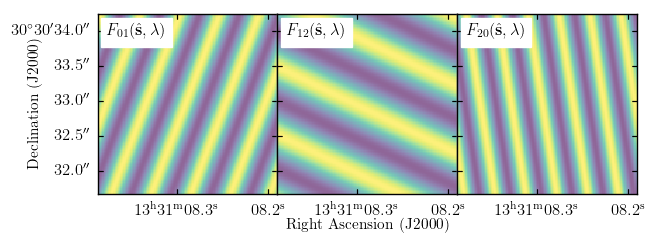

/lustre/aoc/users/nthyagar/projects/CPhaseGeom/figures/3C286_individual_cal_fringes.pdf


<IPython.core.display.Javascript object>


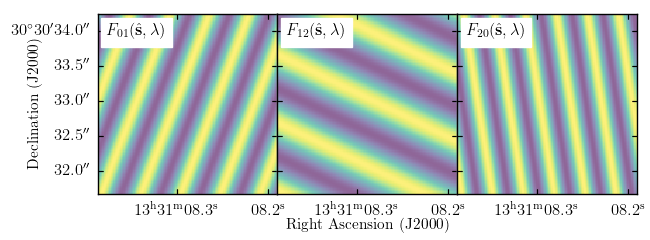

/lustre/aoc/users/nthyagar/projects/CPhaseGeom/figures/3C286_individual_uncal_fringes.pdf


<IPython.core.display.Javascript object>


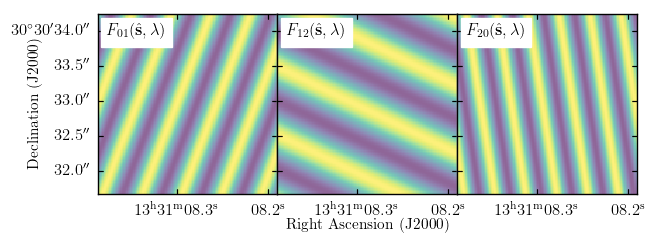

/lustre/aoc/users/nthyagar/projects/CPhaseGeom/figures/3C286_individual_blerr_fringes.pdf


In [54]:
fname = '0913.fits'
wcs = WCS(imghdrs[fname]).celestial
# center = wcs.all_world2pix(NP.asarray([wcs.wcs.crval[0], wcs.wcs.crval[1]]).reshape(-1,2), 0)

for calkey in ['cal', 'uncal', 'blerr']:
    fig, axs = PLT.subplots(nrows=1, ncols=3, squeeze=True, sharex=True, sharey=True, subplot_kw={'projection': wcs, 'aspect': 'equal'}, figsize=(6.5,2.4))
    for fnamei, fname in enumerate(imgfilenames['bl-fringes'][calkey]):
        wcs = WCS(imghdrs[fname]).celestial
        data = imgdata[fname].squeeze()
        center = wcs.all_world2pix(NP.asarray([wcs.wcs.crval[0], wcs.wcs.crval[1]]).reshape(-1,2), 0)
        axs[fnamei].imshow(data, origin='lower', cmap='viridis', interpolation='none', alpha=0.6)
    #     axs[fnamei].plot(wcs.wcs.crval[0]/15.0, wcs.wcs.crval[1], transform=axs[fnamei].transData, ls='none', marker='+', ms=8, color='black')
    #     axs[fnamei].scatter(wcs.wcs.crval[0], wcs.wcs.crval[1], transform=axs[fnamei].get_transform('world'), marker='+', s=16, color='black')
    #     axs[fnamei].scatter(center[0,0]-1, center[0,1], transform=axs[fnamei].get_transform('pixel'), marker='+', s=16, color='black')
#         axs[fnamei].text(center[0,0]-1, center[0,1], '+', transform=axs[fnamei].get_transform('pixel'), ha='center', va='center', fontsize=10, color='black')
#         axs[fnamei].text(center[0,0]-1, center[0,1], 'O', transform=axs[fnamei].get_transform('pixel'), ha='center', va='center', fontsize=10, color='magenta')
        lon = axs[fnamei].coords[0]
        lat = axs[fnamei].coords[1]
        lon.set_major_formatter('hh:mm:ss.s')
        lat.set_major_formatter('dd:mm:ss.s')
        lon.set_separator((r'$^\mathrm{h}$', r'$^\mathrm{m}$', r'$^\mathrm{s}$'))
        lat.set_separator((r'$^\circ$', r'$^\prime$', r'$^{\prime\prime}$'))    
        if fnamei > 0:
            lat.set_ticklabel_visible(False)

    axs[0].text(0.05, 0.95, r'$F_{01}(\hat{\mathbf{s}},\lambda)$', ha='left', va='top', transform=axs[0].transAxes, fontsize=12, color='black', backgroundcolor='white')
    axs[1].text(0.05, 0.95, r'$F_{12}(\hat{\mathbf{s}},\lambda)$', ha='left', va='top', transform=axs[1].transAxes, fontsize=12, color='black', backgroundcolor='white')
    axs[2].text(0.05, 0.95, r'$F_{20}(\hat{\mathbf{s}},\lambda)$', ha='left', va='top', transform=axs[2].transAxes, fontsize=12, color='black', backgroundcolor='white')

    fig.subplots_adjust(hspace=0, wspace=0)
    fig.subplots_adjust(left=0.15, right=0.98, bottom=0.15, top=0.98)

    big_ax = fig.add_subplot(111)
    big_ax.set_facecolor('none') # matplotlib.__version__ >= 2.0.0
    # big_ax.set_axis_bgcolor('none') # matplotlib.__version__ < 2.0.0
    big_ax.spines['right'].set_visible(False)
    big_ax.spines['top'].set_visible(False)
    big_ax.spines['left'].set_visible(False)
    big_ax.spines['bottom'].set_visible(False)
    big_ax.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
    big_ax.set_xticks([])
    big_ax.set_yticks([])
    big_ax.set_xlabel('Right Ascension (J2000)', fontsize=11, weight='medium', labelpad=10)
    big_ax.set_ylabel('Declination (J2000)', fontsize=11, weight='medium', labelpad=40)

#     PLT.savefig(figdir+'3C286_individual_{0}_fringes.pdf'.format(calkey), bbox_inches=0)
    print(figdir+'3C286_individual_{0}_fringes.pdf'.format(calkey))

In [ ]:
# fname = '0913.fits'
# wcs = WCS(imghdrs[fname]).celestial
# # center = wcs.all_world2pix(NP.asarray([wcs.wcs.crval[0], wcs.wcs.crval[1]]).reshape(-1,2), 0)

# for calkey in ['cal', 'uncal']:
#     fig, axs = PLT.subplots(nrows=1, ncols=3, squeeze=True, sharex=True, sharey=True, subplot_kw={'projection': wcs, 'aspect': 'equal'}, figsize=(6.5,2.4))
#     for fnamei, fname in enumerate(imgfilenames['bl-fringes'][calkey]):
#         wcs = WCS(imghdrs[fname]).celestial
#         data = imgdata[fname].squeeze()
#         center = wcs.all_world2pix(NP.asarray([wcs.wcs.crval[0], wcs.wcs.crval[1]]).reshape(-1,2), 0)
#         axs[fnamei].imshow(data, origin='lower', cmap='viridis', interpolation='none', alpha=0.6)
#     #     axs[fnamei].plot(wcs.wcs.crval[0]/15.0, wcs.wcs.crval[1], transform=axs[fnamei].transData, ls='none', marker='+', ms=8, color='black')
#     #     axs[fnamei].scatter(wcs.wcs.crval[0], wcs.wcs.crval[1], transform=axs[fnamei].get_transform('world'), marker='+', s=16, color='black')
#     #     axs[fnamei].scatter(center[0,0]-1, center[0,1], transform=axs[fnamei].get_transform('pixel'), marker='+', s=16, color='black')
# #         axs[fnamei].text(center[0,0]-1, center[0,1], '+', transform=axs[fnamei].get_transform('pixel'), ha='center', va='center', fontsize=10, color='black')
# #         axs[fnamei].text(center[0,0]-1, center[0,1], 'O', transform=axs[fnamei].get_transform('pixel'), ha='center', va='center', fontsize=10, color='magenta')
#         lon = axs[fnamei].coords[0]
#         lat = axs[fnamei].coords[1]
#         lon.set_major_formatter('hh:mm:ss.s')
#         lat.set_major_formatter('dd:mm:ss.s')
#         lon.set_separator((r'$^\mathrm{h}$', r'$^\mathrm{m}$', r'$^\mathrm{s}$'))
#         lat.set_separator((r'$^\circ$', r'$^\prime$', r'$^{\prime\prime}$'))    
#         if fnamei > 0:
#             lat.set_ticklabel_visible(False)

#     axs[0].text(0.05, 0.95, r'$F_{12}(\hat{\mathbf{s}},\lambda)$', ha='left', va='top', transform=axs[0].transAxes, fontsize=10, color='black', backgroundcolor='white')
#     axs[1].text(0.05, 0.95, r'$F_{23}(\hat{\mathbf{s}},\lambda)$', ha='left', va='top', transform=axs[1].transAxes, fontsize=10, color='black', backgroundcolor='white')
#     axs[2].text(0.05, 0.95, r'$F_{31}(\hat{\mathbf{s}},\lambda)$', ha='left', va='top', transform=axs[2].transAxes, fontsize=10, color='black', backgroundcolor='white')

#     fig.subplots_adjust(hspace=0, wspace=0)
#     fig.subplots_adjust(left=0.15, right=0.98, bottom=0.15, top=0.98)

#     big_ax = fig.add_subplot(111)
#     big_ax.set_facecolor('none') # matplotlib.__version__ >= 2.0.0
#     # big_ax.set_axis_bgcolor('none') # matplotlib.__version__ < 2.0.0
#     big_ax.spines['right'].set_visible(False)
#     big_ax.spines['top'].set_visible(False)
#     big_ax.spines['left'].set_visible(False)
#     big_ax.spines['bottom'].set_visible(False)
#     big_ax.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
#     big_ax.set_xticks([])
#     big_ax.set_yticks([])
#     big_ax.set_xlabel('Right Ascension (J2000)', fontsize=10, weight='medium', labelpad=10)
#     big_ax.set_ylabel('Declination (J2000)', fontsize=10, weight='medium', labelpad=40)

#     # PLT.savefig(figdir+'3C286_individual_{0}_fringes.pdf'.format(calkey), bbox_inches=0)
#     print(figdir+'3C286_individual_{0}_fringes.pdf'.format(calkey))

# Plot the three calibrated fringes together for 3C286 with and without calibration

<IPython.core.display.Javascript object>


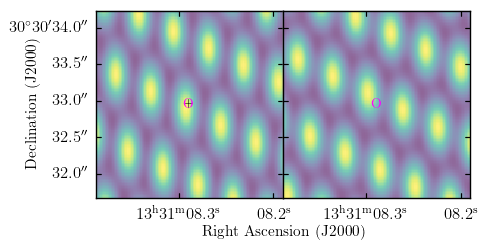

/lustre/aoc/users/nthyagar/projects/CPhaseGeom/figures/3C286_all_fringes.pdf


In [55]:
# fname = '0913.fits'
fname = '3fringecal.fits'
wcs = WCS(imghdrs[fname]).celestial
# center = wcs.all_world2pix(NP.asarray([wcs.wcs.crval[0], wcs.wcs.crval[1]]).reshape(-1,2), 0)

fig, axs = PLT.subplots(nrows=1, ncols=2, squeeze=True, sharex=True, sharey=True, subplot_kw={'projection': wcs, 'aspect': 'equal'}, figsize=(4.8,2.4))

for calind, calkey in enumerate(['cal', 'uncal']):
    fname = imgfilenames['triad-fringes'][calkey]
    wcs = WCS(imghdrs[fname]).celestial
    center = wcs.all_world2pix(NP.asarray([wcs.wcs.crval[0], wcs.wcs.crval[1]]).reshape(-1,2), 0)
    data = imgdata[fname].squeeze()
    axs[calind].imshow(data, origin='lower', cmap='viridis', interpolation='none', alpha=0.6)
#     axs[calind].plot(wcs.wcs.crval[0]/15.0, wcs.wcs.crval[1], transform=axs[calind].transData, ls='none', marker='+', ms=8, color='black')
#     axs[calind].scatter(wcs.wcs.crval[0], wcs.wcs.crval[1], transform=axs[calind].get_transform('world'), marker='+', s=16, color='black')
    if calkey == 'cal':
#         axs[calind].scatter(center[0,0]-1, center[0,1], transform=axs[calind].get_transform('pixel'), marker='+', s=16, color='black')
        axs[calind].text(center[0,0]-1, center[0,1], '+', transform=axs[calind].get_transform('pixel'), ha='center', va='center', fontsize=10, color='black')
        axs[calind].text(center[0,0]-1, center[0,1], 'O', transform=axs[calind].get_transform('pixel'), ha='center', va='center', fontsize=10, color='magenta')
    if calkey == 'uncal':
        axs[calind].text(center[0,0]-1, center[0,1], 'O', transform=axs[calind].get_transform('pixel'), ha='center', va='center', fontsize=10, color='magenta')
    lon = axs[calind].coords[0]
    lat = axs[calind].coords[1]
    lon.set_major_formatter('hh:mm:ss.s')
    lat.set_major_formatter('dd:mm:ss.s')
    lon.set_separator((r'$^\mathrm{h}$', r'$^\mathrm{m}$', r'$^\mathrm{s}$'))
    lat.set_separator((r'$^\circ$', r'$^\prime$', r'$^{\prime\prime}$'))    
    if calind > 0:
        lat.set_ticklabel_visible(False)

fig.subplots_adjust(hspace=0, wspace=0)
fig.subplots_adjust(left=0.2, right=0.98, bottom=0.15, top=0.98)

big_ax = fig.add_subplot(111)
big_ax.set_facecolor('none') # matplotlib.__version__ >= 2.0.0
# big_ax.set_axis_bgcolor('none') # matplotlib.__version__ < 2.0.0
big_ax.spines['right'].set_visible(False)
big_ax.spines['top'].set_visible(False)
big_ax.spines['left'].set_visible(False)
big_ax.spines['bottom'].set_visible(False)
big_ax.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
big_ax.set_xticks([])
big_ax.set_yticks([])
big_ax.set_xlabel('Right Ascension (J2000)', fontsize=11, weight='medium', labelpad=15)
big_ax.set_ylabel('Declination (J2000)', fontsize=11, weight='medium', labelpad=40)

# PLT.savefig(figdir+'3C286_all_fringes.pdf', bbox_inches=0)
print(figdir+'3C286_all_fringes.pdf')

# Plot the three calibrated two-fringe combinations for 3C286

<IPython.core.display.Javascript object>


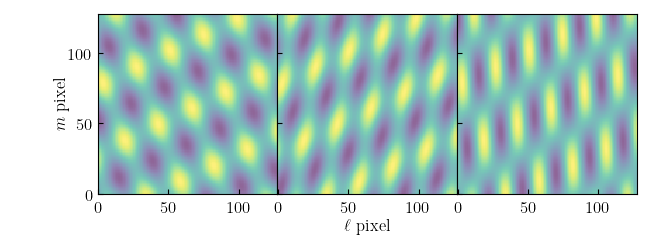

(0, '0913+0919')
/lustre/aoc/users/nthyagar/projects/CPhaseGeom/figures/3C286_individual_cal_two-fringes-0913+0919.pdf
(1, '0919+1319')
/lustre/aoc/users/nthyagar/projects/CPhaseGeom/figures/3C286_individual_cal_two-fringes-0919+1319.pdf
(2, '1319+0913')
/lustre/aoc/users/nthyagar/projects/CPhaseGeom/figures/3C286_individual_cal_two-fringes-1319+0913.pdf


/lustre/aoc/users/nthyagar/src/miniconda2/envs/PRISim-dev/lib/python2.7/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


<IPython.core.display.Javascript object>


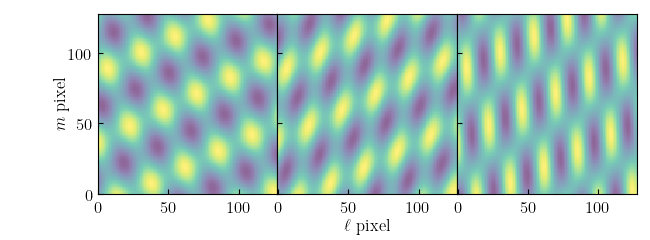

(0, '0913u+0919u')
/lustre/aoc/users/nthyagar/projects/CPhaseGeom/figures/3C286_individual_uncal_two-fringes-0913u+0919u.pdf
(1, '0919u+1319u')
/lustre/aoc/users/nthyagar/projects/CPhaseGeom/figures/3C286_individual_uncal_two-fringes-0919u+1319u.pdf
(2, '1319u+0913u')
/lustre/aoc/users/nthyagar/projects/CPhaseGeom/figures/3C286_individual_uncal_two-fringes-1319u+0913u.pdf


<IPython.core.display.Javascript object>


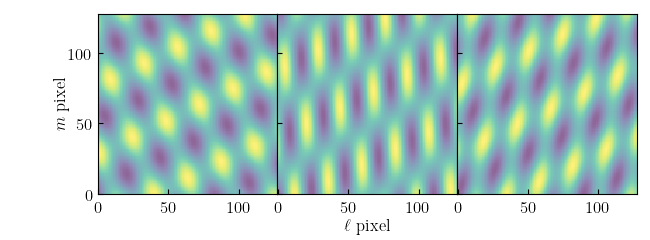

(0, '0913cb+0919')
/lustre/aoc/users/nthyagar/projects/CPhaseGeom/figures/3C286_individual_blerr_two-fringes-0913cb+0919.pdf
(1, '1319+0913cb')
/lustre/aoc/users/nthyagar/projects/CPhaseGeom/figures/3C286_individual_blerr_two-fringes-1319+0913cb.pdf
(2, '0919+1319')
/lustre/aoc/users/nthyagar/projects/CPhaseGeom/figures/3C286_individual_blerr_two-fringes-0919+1319.pdf


In [56]:
fname = '0913.fits'
wcs = WCS(imghdrs[fname]).celestial
center = wcs.all_world2pix(NP.asarray([wcs.wcs.crval[0], wcs.wcs.crval[1]]).reshape(-1,2), 0)

for calkey in ['cal', 'uncal', 'blerr']:
    fig, axs = PLT.subplots(nrows=1, ncols=3, squeeze=True, sharex=True, sharey=True, subplot_kw={'aspect': 'equal'}, figsize=(6.5,2.4))
    for fnamei, fname in enumerate(imgdata['two-fringes'][calkey]):
        print(fnamei, fname)
    #     fig, ax = PLT.subplots(nrows=1, ncols=1, squeeze=True, sharex=True, sharey=True, subplot_kw={'projection': wcs, 'aspect': 'equal'}, figsize=(2.4,2.4))

        data = imgdata['two-fringes'][calkey][fname].squeeze()[:,::-1] # Flip the x-axis (second axis in this case)
        axs[fnamei].imshow(data, origin='lower', cmap='viridis', interpolation='none', alpha=0.6)
    #     axs[fnamei].imshow(data, origin='lower', cmap='viridis', interpolation='none', alpha=0.6)

    #     axs[fnamei].text(center[0,0]-1, center[0,1], '+', transform=axs[fnamei].get_transform('pixel'), ha='center', va='center', fontsize=10, color='black')
    #     axs[fnamei].text(center[0,0]-1, center[0,1], 'O', transform=axs[fnamei].get_transform('pixel'), ha='center', va='center', fontsize=10, color='magenta')

    #     axs[fnamei].text(center[0,0]-1, center[0,1], 'O', transform=axs[fnamei].transData, ha='center', va='center', fontsize=10, color='magenta')

    #     lon = axs[fnamei].coords[0]
    #     lat = axs[fnamei].coords[1]
    #     lon.set_major_formatter('hh:mm:ss.s')
    #     lat.set_major_formatter('dd:mm:ss.s')
    #     lon.set_separator((r'$^\mathrm{h}$', r'$^\mathrm{m}$', r'$^\mathrm{s}$'))
    #     lat.set_separator((r'$^\circ$', r'$^\prime$', r'$^{\prime\prime}$'))    
    #     if fnamei > 0:
    #         lat.set_ticklabel_visible(False)

    #     axs[0].text(0.05, 0.95, r'$F_{12}(\hat{\mathbf{s}},\lambda)+F_{23}(\hat{\mathbf{s}},\lambda)$', ha='left', va='top', transform=axs[0].transAxes, fontsize=10, color='black', backgroundcolor='white')
    #     axs[1].text(0.05, 0.95, r'$F_{23}(\hat{\mathbf{s}},\lambda)+F_{31}(\hat{\mathbf{s}},\lambda)$', ha='left', va='top', transform=axs[1].transAxes, fontsize=10, color='black', backgroundcolor='white')
    #     axs[2].text(0.05, 0.95, r'$F_{31}(\hat{\mathbf{s}},\lambda)+F_{12}(\hat{\mathbf{s}},\lambda)$', ha='left', va='top', transform=axs[2].transAxes, fontsize=10, color='black', backgroundcolor='white')

        fig.subplots_adjust(hspace=0, wspace=0)
        fig.subplots_adjust(left=0.15, right=0.98, bottom=0.15, top=0.98)

        big_ax = fig.add_subplot(111)
        big_ax.set_facecolor('none') # matplotlib.__version__ >= 2.0.0
        # big_ax.set_axis_bgcolor('none') # matplotlib.__version__ < 2.0.0
        big_ax.spines['right'].set_visible(False)
        big_ax.spines['top'].set_visible(False)
        big_ax.spines['left'].set_visible(False)
        big_ax.spines['bottom'].set_visible(False)
        big_ax.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
        big_ax.set_xticks([])
        big_ax.set_yticks([])
        big_ax.set_xlabel(r'$\ell$ pixel', fontsize=12, weight='medium', labelpad=10)
        big_ax.set_ylabel(r'$m$ pixel', fontsize=12, weight='medium', labelpad=20)

        # PLT.savefig(figdir+'3C286_individual_{0}_two-fringes-{1}.pdf'.format(calkey, fname), bbox_inches=0)
        print(figdir+'3C286_individual_{0}_two-fringes-{1}.pdf'.format(calkey, fname))

In [90]:
print(wcs)

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---SIN'  'DEC--SIN'  
CRVAL : 202.7845332653  30.5091552377  
CRPIX : 65.0  65.0  
PC1_1 PC1_2  : 1.0  0.0  
PC2_1 PC2_2  : 0.0  1.0  
CDELT : -5.555555555556e-06  5.555555555556e-06  
NAXIS : 128  128  1  1


In [57]:
imghdrs['0919.fits']['NAXIS1']

128

In [58]:
wcs.wcs.crval

array([202.78453327,  30.50915524])

In [59]:
(wcs.wcs.crval - 13.5166666666666667* 15.0)/15 * 3600

array([ 8.28798367e+00, -4.13378027e+04])

In [60]:
wcs.wcs.crpix

array([65., 65.])

In [61]:
wcs.wcs.cunit

['deg', 'deg']

## Read visibility information

In [4]:
# visdir = '/lustre/aoc/users/nthyagar/projects/CPhaseGeom/data/3C286/UV/4min/'
# visfile = '3C286_RR_3fringe_4min.uvfits'
# visobj = UVData()
# visobj.read_uvfits(visdir+visfile)

visdir = '/lustre/aoc/users/nthyagar/projects/CPhaseGeom/data/3C286/UV/20sec/'
visfile = '3C286_snapshot_long_baseline.uvfits'
visobj = UVData()
visobj.read_uvfits(visdir+visfile)

time_array = visobj.time_array.reshape(visobj.Ntimes,visobj.Nbls)
unique_times = time_array[:,0]
nchan = visobj.freq_array.size
snap_visobj = visobj.select(times=unique_times[int(0.5*visobj.Ntimes)], inplace=False)

f0 = visobj.freq_array.ravel()[int(0.5*nchan)]
wl0 = (FCNST.c / (f0 * U.Hz)).to('m')
antpos_data, antid_data = snap_visobj.get_ENU_antpos()
antpos_data = antpos_data * U.m
blvect_data = NP.roll(antpos_data, -1, axis=0) - antpos_data
bll_data = NP.sqrt(NP.sum(blvect_data**2, axis=1))
uvvect_data = blvect_data / wl0
uvw_data = snap_visobj.uvw_array

fringe_slopes_data = -uvw_data[:,0] / uvw_data[:,1]

vis_snr = 4.4e3 / 33 # SNR on each visibility
phase_err = 1/vis_snr # in radians
pos_err = phase_err / (2 * NP.pi * NP.sqrt(NP.sum(uvw_data[:,:2]**2, axis=1)) / wl0.to('m').value) # in radians

# visdir = '/lustre/aoc/users/nthyagar/projects/CPhaseGeom/data/3C286/UV/20sec/'
# uncal_visfile = '3C286uncal.uvfits'
# cal_visfile = '3C286cal.uvfits'
# antids = [8, 12, 18]

# cal_visobj = UVData()
# cal_visobj.read_uvfits(visdir+cal_visfile)
# uncal_visobj = UVData()
# uncal_visobj.read_uvfits(visdir+uncal_visfile)
# nchan = uncal_visobj.freq_array.size
# f0 = uncal_visobj.freq_array.ravel()[int(0.5*nchan)]
# wl0 = (FCNST.c / (f0 * U.Hz)).to('m')
# antpos_data, antid_data = uncal_visobj.get_ENU_antpos()
# antpos_data = antpos_data * U.m
# blvect_data = NP.roll(antpos_data, -1, axis=0) - antpos_data
# bll_data = NP.sqrt(NP.sum(blvect_data**2, axis=1))
# uvvect_data = blvect_data / wl0

Telescope EVLA is not in known_telescopes.


In [5]:
print(nchan)
print(visobj.Nbls)
print(visobj.Ntimes)
print(antpos_data)
print(visobj.antenna_numbers)
print(visobj.antenna_names)
print(visobj.data_array.shape)
# print(visobj.freq_array.shape)
# print(visobj.time_array.shape)
# print(visobj.integration_time)
print(visobj.time_array.reshape(visobj.Ntimes,visobj.Nbls))
print(visobj.uvw_array.shape)
print(NP.sqrt(NP.sum(visobj.uvw_array[:,:2]**2, axis=1)))
print(visobj.polarization_array)
print(blvect_data)
print(bll_data)
print(uvvect_data.decompose())
print(NP.sqrt(NP.sum(uvvect_data**2, axis=1)).decompose().value)
print(1/NP.sqrt(NP.sum(uvvect_data**2, axis=1)).decompose().value)
# uncal_visobj.select(antenna_nums=antids)
print(zip(snap_visobj.ant_1_array, snap_visobj.ant_2_array))
print(snap_visobj.data_array.shape)
print(snap_visobj.uvw_array)
print(NP.sqrt(NP.sum(uvw_data[:,:2]**2, axis=1)))
print(1/NP.sqrt(NP.sum(uvvect_data[:,:2]**2, axis=1)))
print(fringe_slopes)
print(vis_snr)
print(phase_err)
print(NP.degrees(pos_err) * 3.6e3 * 1e3) # in mas

1
3
10
[[ 1.37241072e+03  4.57440030e+03 -6.43498604e+00]
 [-9.81263646e+03 -4.48496469e+03 -1.72075189e+01]
 [ 8.44022574e+03 -8.94356149e+01  2.36425048e+01]] m
[ 8 12 18]
['N16', 'W56', 'E40']
(30, 1, 1, 4)
[[2458733.28126156 2458733.28126156 2458733.28126156]
 [2458733.28128472 2458733.28128472 2458733.28128472]
 [2458733.28130788 2458733.28130788 2458733.28130788]
 [2458733.28133103 2458733.28133103 2458733.28133103]
 [2458733.28135416 2458733.28135416 2458733.28135416]
 [2458733.28137732 2458733.28137732 2458733.28137732]
 [2458733.28140047 2458733.28140047 2458733.28140047]
 [2458733.2814236  2458733.2814236  2458733.2814236 ]
 [2458733.28144675 2458733.28144675 2458733.28144675]
 [2458733.28146991 2458733.28146991 2458733.28146991]]
(30, 3)
[12387.176   7509.7036 15035.858  12388.036   7509.919  15037.255
 12388.898   7510.134  15038.651  12389.76    7510.348  15040.049
 12390.621   7510.5625 15041.444  12391.4795  7510.778  15042.84
 12392.342   7510.992  15044.235  12393.201 

NameError: name 'fringe_slopes' is not defined

In [129]:
xy_center = {}
xy_std = {}
xy_blc = {}
xy_trc = {}

xy_center['cal'] = {'0913+0919': NP.asarray([66.5, 60.5]), '0919+1319': NP.asarray([66.5, 60.5]), '1319+0913': NP.asarray([66.5, 60.5])}
xy_std['cal'] = {'0913+0919': NP.asarray([3.0, 6.0]), '0919+1319': NP.asarray([3.0, 6.0]), '1319+0913': NP.asarray([3.0, 6.0])}
xy_blc['cal'] = {'0913+0919': NP.asarray([56, 44]), '0919+1319': NP.asarray([55, 38]), '1319+0913': NP.asarray([55, 38])}
xy_trc['cal'] = {'0913+0919': NP.asarray([77, 77]), '0919+1319': NP.asarray([78, 83]), '1319+0913': NP.asarray([78, 83])}

xy_center['uncal'] = {'0913u+0919u': NP.asarray([70.0, 70.0]), '0919u+1319u': NP.asarray([70.0, 70.0]), '1319u+0913u': NP.asarray([70.0, 70.0])}
xy_std['uncal'] = {'0913u+0919u': NP.asarray([3.0, 6.0]), '0919u+1319u': NP.asarray([3.0, 6.0]), '1319u+0913u': NP.asarray([3.0, 6.0])}
xy_blc['uncal'] = {'0913u+0919u': NP.asarray([59, 51]), '0919u+1319u': NP.asarray([59, 51]), '1319u+0913u': NP.asarray([59, 51])}
xy_trc['uncal'] = {'0913u+0919u': NP.asarray([81, 89]), '0919u+1319u': NP.asarray([81, 89]), '1319u+0913u': NP.asarray([81, 89])}

xy_center['blerr'] = {'0913cb+0919': NP.asarray([71.0, 62.0]), '0919+1319': NP.asarray([66.5, 60.5]), '1319+0913cb': NP.asarray([68.0, 72.0])}
xy_std['blerr'] = {'0913cb+0919': NP.asarray([3.0, 6.0]), '0919+1319': NP.asarray([3.0, 6.0]), '1319+0913cb': NP.asarray([3.0, 6.0])}
xy_blc['blerr'] = {'0913cb+0919': NP.asarray([60, 46]), '0919+1319': NP.asarray([55, 38]), '1319+0913cb': NP.asarray([56, 50])}
xy_trc['blerr'] = {'0913cb+0919': NP.asarray([81, 79]), '0919+1319': NP.asarray([78, 83]), '1319+0913cb': NP.asarray([79, 95])}

print(xy_blc['cal'])
print(xy_trc['cal'])
print(xy_blc['uncal'])
print(xy_trc['uncal'])
print(xy_blc['blerr'])
print(xy_trc['blerr'])

{'0913+0919': array([56, 44]), '0919+1319': array([55, 38]), '1319+0913': array([55, 38])}
{'0913+0919': array([77, 77]), '0919+1319': array([78, 83]), '1319+0913': array([78, 83])}
{'0913u+0919u': array([59, 51]), '0919u+1319u': array([59, 51]), '1319u+0913u': array([59, 51])}
{'0913u+0919u': array([81, 89]), '0919u+1319u': array([81, 89]), '1319u+0913u': array([81, 89])}
{'0913cb+0919': array([60, 46]), '1319+0913cb': array([56, 50]), '0919+1319': array([55, 38])}
{'0913cb+0919': array([81, 79]), '1319+0913cb': array([79, 95]), '0919+1319': array([78, 83])}


In [130]:
astropy_lmfit_output = {}
astropy_lmfitter = fitting.LevMarLSQFitter()

for calkey in ['cal', 'uncal', 'blerr']:
    astropy_lmfit_output[calkey] = {}
    for fnamei, fname in enumerate(imgdata['two-fringes'][calkey]):
    #     print(xy_blc[fname][0], xy_trc[fname][0]+1)
    #     print(NP.arange(xy_blc[fname][0], xy_trc[fname][0]+1))
    #     print(NP.arange(xy_blc[fname][1], xy_trc[fname][1]+1))
        print(fname)
        xgrid, ygrid = NP.meshgrid(NP.arange(xy_blc[calkey][fname][0], xy_trc[calkey][fname][0]+1), NP.arange(xy_blc[calkey][fname][1], xy_trc[calkey][fname][1]+1))
        data_full = imgdata['two-fringes'][calkey][fname].squeeze()[:,::-1] 
        data_subset = data_full[xy_blc[calkey][fname][1]:xy_trc[calkey][fname][1]+1, xy_blc[calkey][fname][0]:xy_trc[calkey][fname][0]+1]
        g2d_model = models.Gaussian2D(x_mean=xy_center[calkey][fname][0], y_mean=xy_center[calkey][fname][1], x_stddev=xy_std[calkey][fname][0], y_stddev=xy_std[calkey][fname][1], theta=0.0)
        g2p = astropy_lmfitter(g2d_model, xgrid, ygrid, data_subset)
        astropy_lmfit_output[calkey][fname] = {}
        astropy_lmfit_output[calkey][fname]['data'] = NP.copy(data_subset)
        astropy_lmfit_output[calkey][fname]['parameters'] = {'amplitude': g2p.amplitude.value, 'x_center': g2p.x_mean.value, 'y_center': g2p.y_mean.value, 'x_std': g2p.x_stddev.value, 'y_std': g2p.y_stddev.value, 'theta': g2p.theta.value, }
        astropy_lmfit_output[calkey][fname]['modelfit'] = g2p(xgrid, ygrid)
        print(fname+': ', astropy_lmfit_output[calkey][fname]['parameters'])

0913+0919
('0913+0919: ', {'x_std': 4.55063030597578, 'y_std': 7.434786406827039, 'x_center': 66.39981132523327, 'amplitude': 9.989625876937037, 'theta': 0.36161761479677756, 'y_center': 60.68990569037199})
0919+1319
('0919+1319: ', {'x_std': 3.318080027950619, 'y_std': 9.21725899517596, 'x_center': 66.28559525967782, 'amplitude': 10.556603655003487, 'theta': -0.28955847778613725, 'y_center': 60.61065869270151})
1319+0913
('1319+0913: ', {'x_std': 2.75155972110493, 'y_std': 12.293355504483491, 'x_center': 66.3272935316513, 'amplitude': 10.02597202058405, 'theta': 0.04583637564930524, 'y_center': 60.918869626086504})
0913u+0919u
('0913u+0919u: ', {'x_std': 5.259348891036416, 'y_std': 6.376651366353596, 'x_center': 69.71271735508172, 'amplitude': 0.23314946784149226, 'theta': 0.3632279340153734, 'y_center': 70.97865775204487})
0919u+1319u
('0919u+1319u: ', {'x_std': 3.735507464524421, 'y_std': 8.856084563241447, 'x_center': 69.61623684157792, 'amplitude': 0.23649899498569915, 'theta': -0

<IPython.core.display.Javascript object>


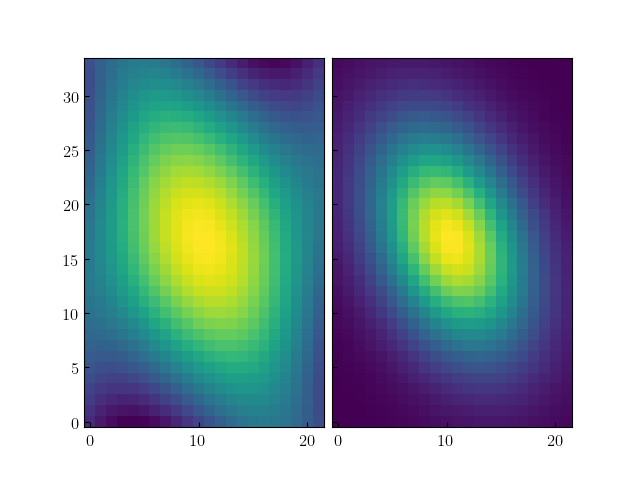

<IPython.core.display.Javascript object>


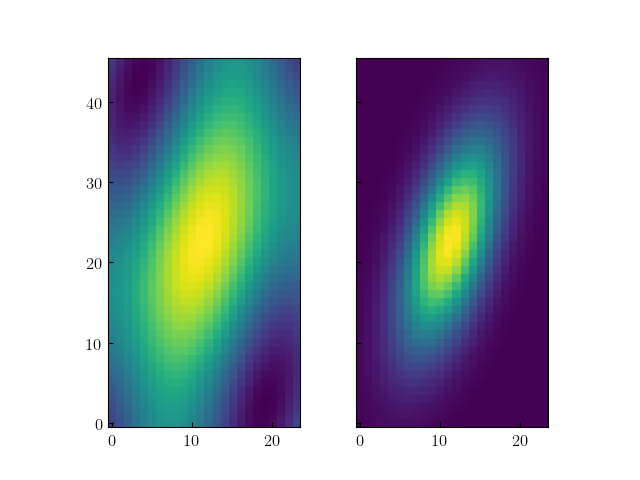

<IPython.core.display.Javascript object>


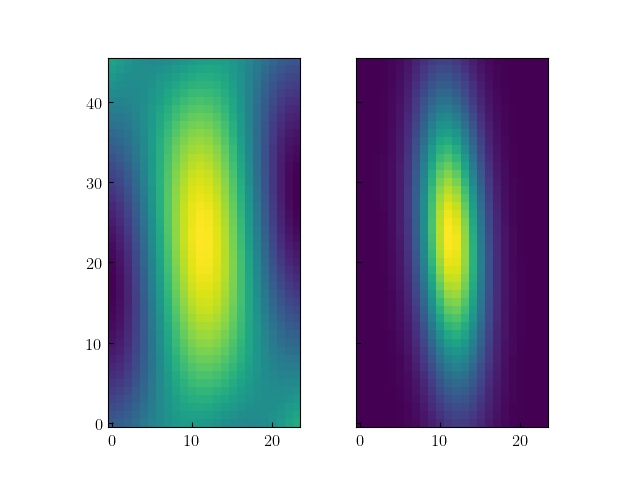

<IPython.core.display.Javascript object>


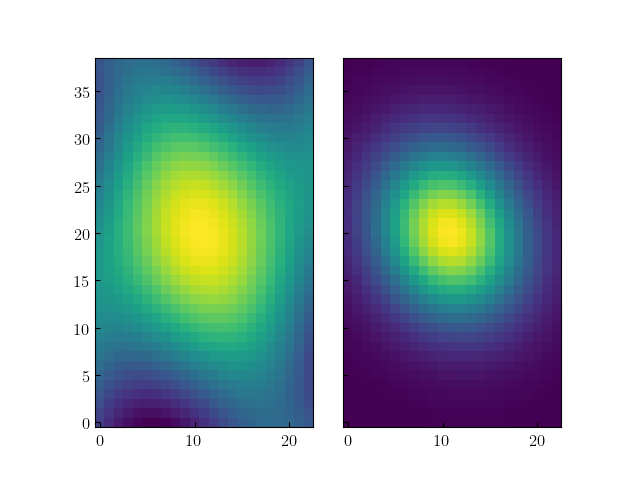

<IPython.core.display.Javascript object>


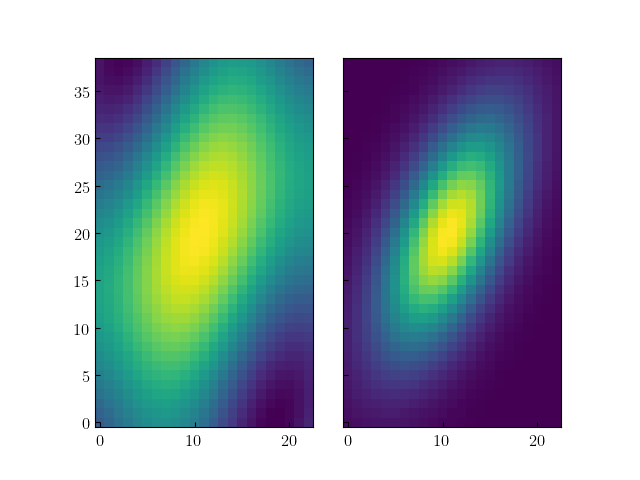

<IPython.core.display.Javascript object>


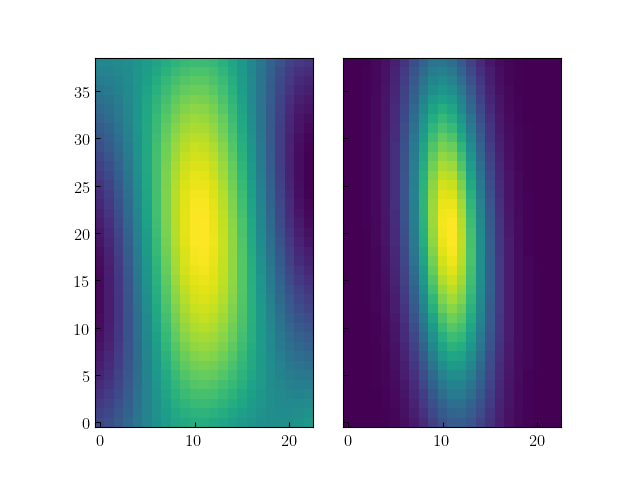

<IPython.core.display.Javascript object>


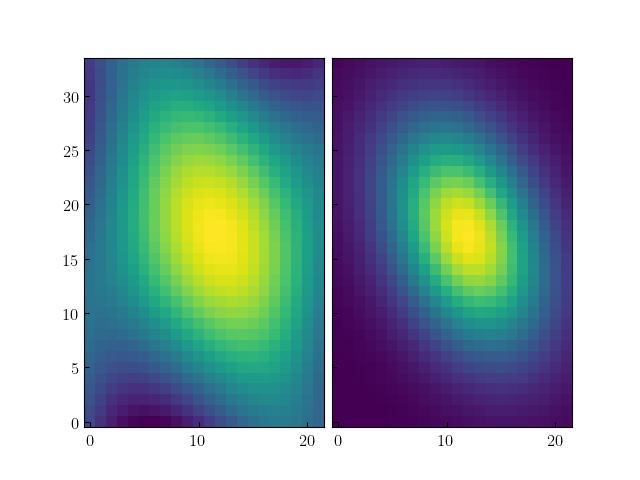

<IPython.core.display.Javascript object>


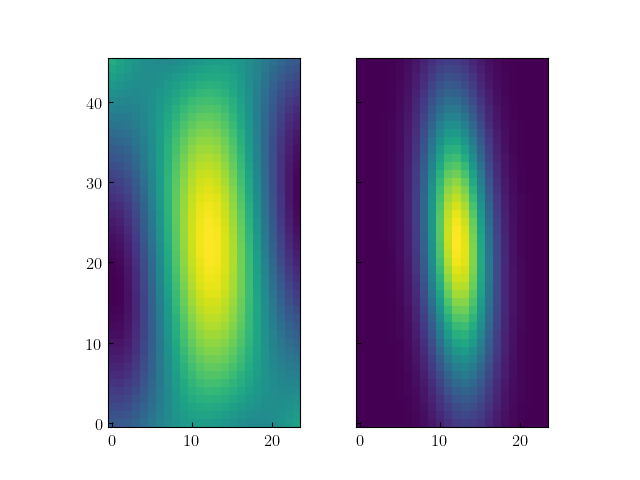

<IPython.core.display.Javascript object>


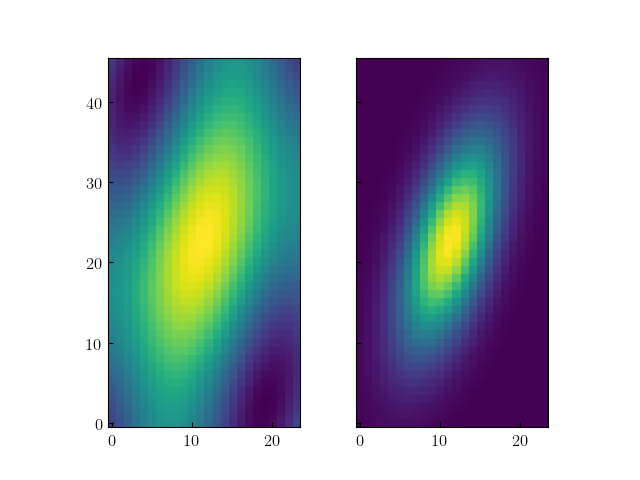

In [131]:
for calkey in ['cal', 'uncal', 'blerr']:
    for fnamei, fname in enumerate(imgdata['two-fringes'][calkey]):
        fig, axs = PLT.subplots(nrows=1, ncols=2, squeeze=True, sharex=True, sharey=True)
        axs[0].imshow(astropy_lmfit_output[calkey][fname]['data'], origin='lower')
        axs[1].imshow(astropy_lmfit_output[calkey][fname]['modelfit'], origin='lower')
        fig.subplots_adjust(hspace=0, wspace=0)

In [132]:
scipy_fit_output_1 = {}
for calkey in ['cal', 'uncal', 'blerr']:
    scipy_fit_output_1[calkey] = {}
    for fnamei, fname in enumerate(imgdata['two-fringes'][calkey]):
        xgrid, ygrid = NP.meshgrid(NP.arange(xy_blc[calkey][fname][0], xy_trc[calkey][fname][0]+1), NP.arange(xy_blc[calkey][fname][1], xy_trc[calkey][fname][1]+1))
        data_full = imgdata['two-fringes'][calkey][fname].squeeze()[:,::-1] 
        data_subset = data_full[xy_blc[calkey][fname][1]:xy_trc[calkey][fname][1]+1, xy_blc[calkey][fname][0]:xy_trc[calkey][fname][0]+1]
        initial_guess = (10.0, xy_center[calkey][fname][0], xy_center[calkey][fname][1], xy_std[calkey][fname][0], xy_std[calkey][fname][1], 0.0)    
        popt, pcov = OPT.curve_fit(gaussian2D_without_offset, (xgrid, ygrid), data_subset.ravel(), p0=initial_guess)
        scipy_fit_output_1[calkey][fname] = {}
        scipy_fit_output_1[calkey][fname]['data'] = NP.copy(data_subset)
        scipy_fit_output_1[calkey][fname]['parameters'] = {'amplitude': popt[0], 'x_center': popt[1], 'y_center': popt[2], 'x_std': popt[3], 'y_std': popt[4], 'theta': popt[5]}
        scipy_fit_output_1[calkey][fname]['covariance'] = NP.copy(pcov)
        scipy_fit_output_1[calkey][fname]['modelfit'] = gaussian2D_without_offset((xgrid, ygrid), scipy_fit_output_1[calkey][fname]['parameters']['amplitude'], scipy_fit_output_1[calkey][fname]['parameters']['x_center'], scipy_fit_output_1[calkey][fname]['parameters']['y_center'], scipy_fit_output_1[calkey][fname]['parameters']['x_std'], scipy_fit_output_1[calkey][fname]['parameters']['y_std'], scipy_fit_output_1[calkey][fname]['parameters']['theta']).reshape(xgrid.shape)
        print('-----{0}-----'.format(fname))
        print('    Optimum values:    ', popt)
        print('    Diagstd:    ', NP.sqrt(NP.diagonal(pcov)))
        print('    Covariance:    ', pcov[1:3,1:3])   

-----0913+0919-----
('    Optimum values:    ', array([ 9.98978655, 66.39981171, 60.68990823,  4.55053918,  7.43469448,
       -0.36165335]))
('    Diagstd:    ', array([0.18850448, 0.09405616, 0.13355706, 0.08759084, 0.1431722 ,
       0.02656066]))
('    Covariance:    ', array([[ 0.00884656, -0.00407383],
       [-0.00407383,  0.01783749]]))
-----0919+1319-----
('    Optimum values:    ', array([10.55712033, 66.28559649, 60.61066042,  3.31773916,  9.21730326,
        0.28961169]))
('    Diagstd:    ', array([0.51020754, 0.19908133, 0.42892215, 0.16010355, 0.45009196,
       0.02828188]))
('    Covariance:    ', array([[0.03963338, 0.04718251],
       [0.04718251, 0.18397421]]))
-----1319+0913-----
('    Optimum values:    ', array([ 1.00260823e+01,  6.63272935e+01,  6.09188693e+01,  2.75149921e+00,
        1.22933555e+01, -4.58375493e-02]))
('    Diagstd:    ', array([0.4570679 , 0.12525063, 0.5661132 , 0.1226749 , 0.63652098,
       0.01535611]))
('    Covariance:    ', array([[ 0.

<IPython.core.display.Javascript object>


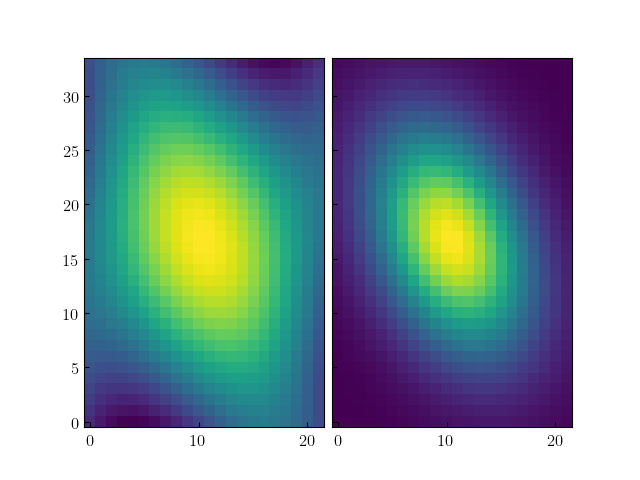

<IPython.core.display.Javascript object>


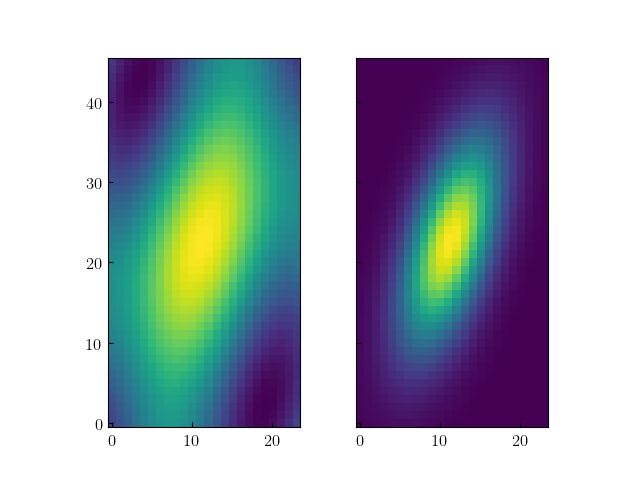

<IPython.core.display.Javascript object>


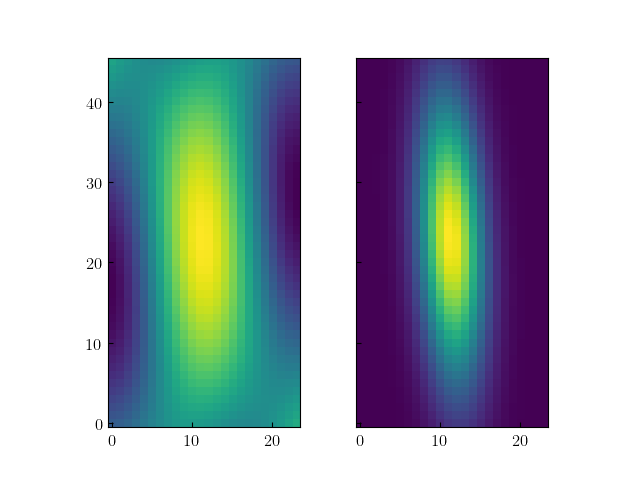

<IPython.core.display.Javascript object>


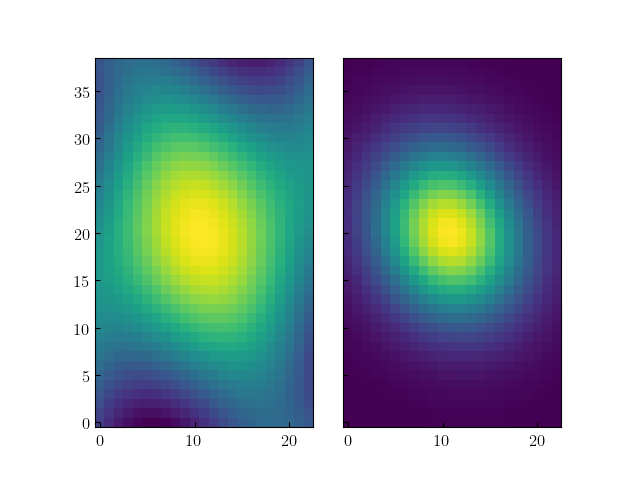

<IPython.core.display.Javascript object>


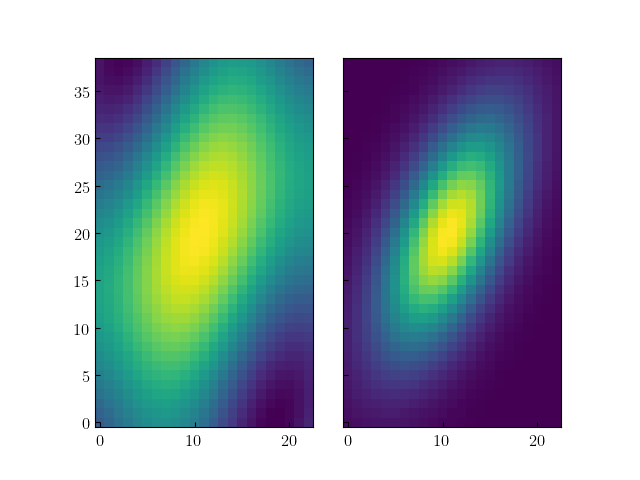

<IPython.core.display.Javascript object>


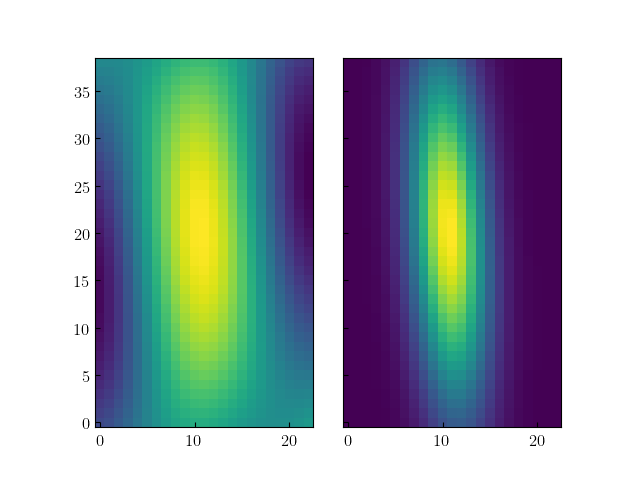

<IPython.core.display.Javascript object>


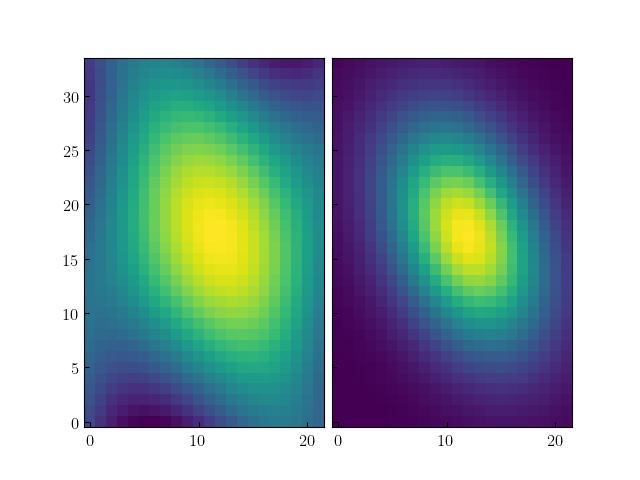

<IPython.core.display.Javascript object>


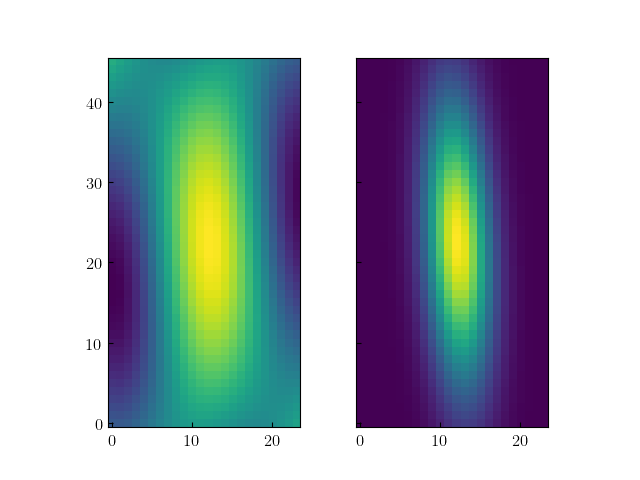

<IPython.core.display.Javascript object>


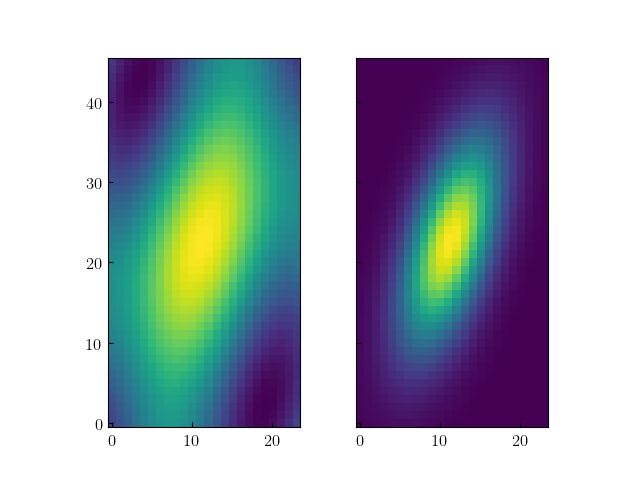

In [133]:
for calkey in ['cal', 'uncal', 'blerr']:
    for fnamei, fname in enumerate(imgdata['two-fringes'][calkey]):
        fig, axs = PLT.subplots(nrows=1, ncols=2, squeeze=True, sharex=True, sharey=True)
        axs[0].imshow(scipy_fit_output_1[calkey][fname]['data'], origin='lower')
        axs[1].imshow(scipy_fit_output_1[calkey][fname]['modelfit'], origin='lower')
        fig.subplots_adjust(hspace=0, wspace=0)

In [134]:
scipy_fit_output_2 = {}
for calkey in ['cal', 'uncal', 'blerr']:
    scipy_fit_output_2[calkey] = {}
    for fnamei, fname in enumerate(imgdata['two-fringes'][calkey]):
        xgrid, ygrid = NP.meshgrid(NP.arange(xy_blc[calkey][fname][0], xy_trc[calkey][fname][0]+1), NP.arange(xy_blc[calkey][fname][1], xy_trc[calkey][fname][1]+1))
        data_full = imgdata['two-fringes'][calkey][fname].squeeze()[:,::-1] 
        data_subset = data_full[xy_blc[calkey][fname][1]:xy_trc[calkey][fname][1]+1, xy_blc[calkey][fname][0]:xy_trc[calkey][fname][0]+1]
        initial_guess = (10.0, xy_center[calkey][fname][0], xy_center[calkey][fname][1], xy_std[calkey][fname][0], xy_std[calkey][fname][1], 0.0, 0.0)    
        popt, pcov = OPT.curve_fit(gaussian2D_with_offset, (xgrid, ygrid), data_subset.ravel(), p0=initial_guess)
        scipy_fit_output_2[calkey][fname] = {}
        scipy_fit_output_2[calkey][fname]['data'] = NP.copy(data_subset)
        scipy_fit_output_2[calkey][fname]['parameters'] = {'amplitude': popt[0], 'x_center': popt[1], 'y_center': popt[2], 'x_std': popt[3], 'y_std': popt[4], 'theta': popt[5], 'offset': popt[6]}
        scipy_fit_output_2[calkey][fname]['covariance'] = NP.copy(pcov)
        scipy_fit_output_2[calkey][fname]['modelfit'] = gaussian2D_with_offset((xgrid, ygrid), scipy_fit_output_2[calkey][fname]['parameters']['amplitude'], scipy_fit_output_2[calkey][fname]['parameters']['x_center'], scipy_fit_output_2[calkey][fname]['parameters']['y_center'], scipy_fit_output_2[calkey][fname]['parameters']['x_std'], scipy_fit_output_2[calkey][fname]['parameters']['y_std'], scipy_fit_output_2[calkey][fname]['parameters']['theta'], scipy_fit_output_2[calkey][fname]['parameters']['offset']).reshape(xgrid.shape)
        print('-----{0}-----'.format(fname))
        print('    Optimum values:    ', popt)
        print('    Diagstd:    ', NP.sqrt(NP.diagonal(pcov)))
        print('    Covariance:    ', pcov[1:3,1:3])

-----0913+0919-----
('    Optimum values:    ', array([13.67681323, 66.41346851, 60.68566252,  7.25907631, 11.36600518,
       -0.35158946, -4.79187577]))
('    Diagstd:    ', array([0.17340403, 0.04152339, 0.05560425, 0.11777073, 0.17245008,
       0.0100059 , 0.19781657]))
('    Covariance:    ', array([[ 0.00172419, -0.00077999],
       [-0.00077999,  0.00309183]]))
-----0919+1319-----
('    Optimum values:    ', array([17.99940262, 66.31801711, 60.60207332,  7.0014167 , 17.78907368,
        0.31664356, -9.20770519]))
('    Diagstd:    ', array([0.16013883, 0.04399596, 0.08743535, 0.08392609, 0.19963007,
       0.0042435 , 0.17063342]))
('    Covariance:    ', array([[0.00193564, 0.00237737],
       [0.00237737, 0.00764494]]))
-----1319+0913-----
('    Optimum values:    ', array([14.76312354, 66.33514376, 60.84815467,  5.20625063, 24.19328291,
       -0.08834547, -6.77153511]))
('    Diagstd:    ', array([0.20743881, 0.04956143, 0.28698778, 0.10423996, 0.64169083,
       0.00385155

<IPython.core.display.Javascript object>


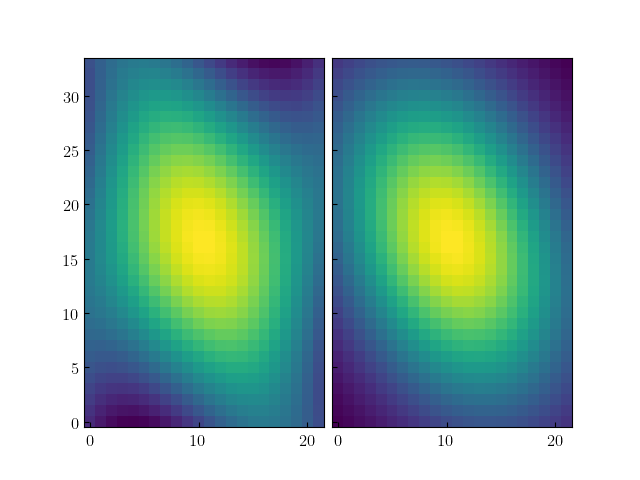

<IPython.core.display.Javascript object>


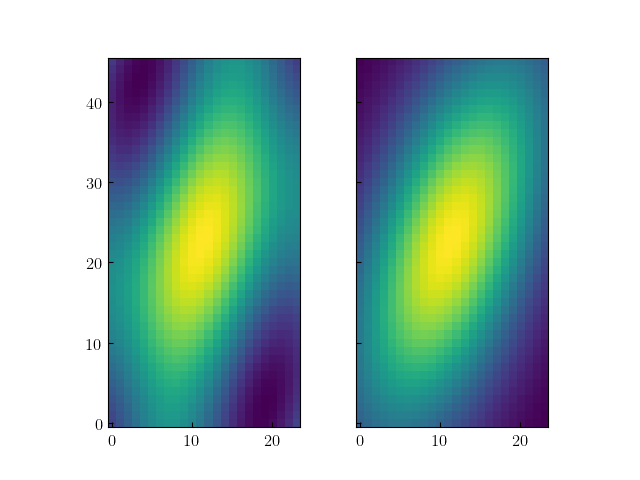

<IPython.core.display.Javascript object>


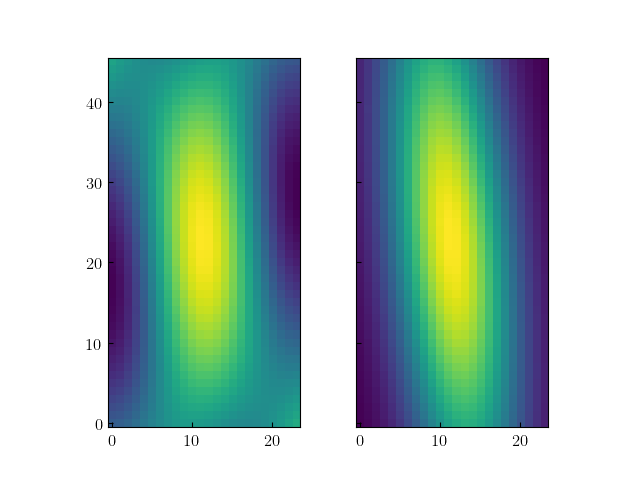

<IPython.core.display.Javascript object>


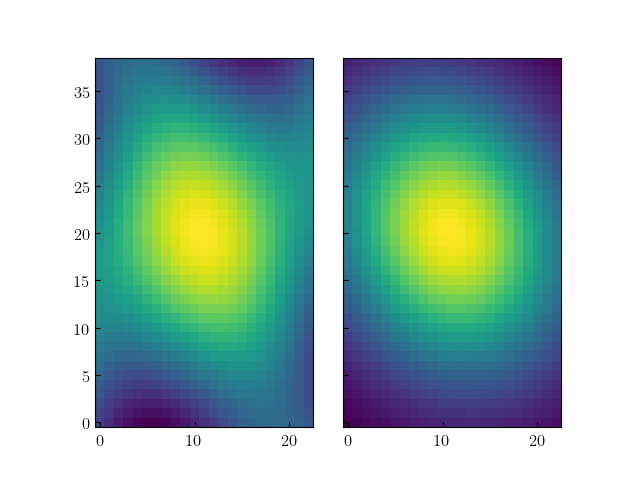

<IPython.core.display.Javascript object>


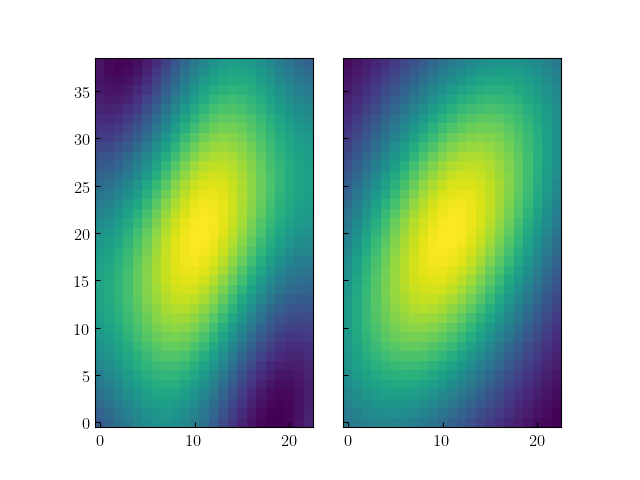

<IPython.core.display.Javascript object>


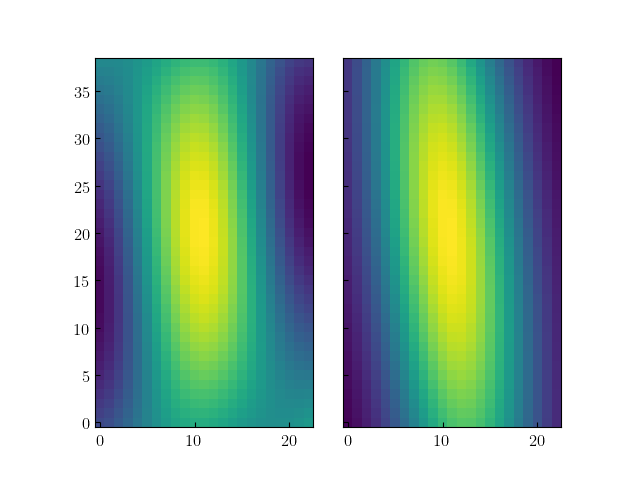

<IPython.core.display.Javascript object>


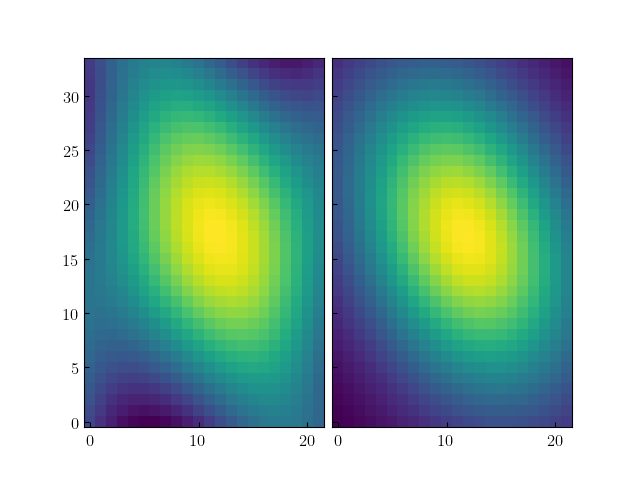

<IPython.core.display.Javascript object>


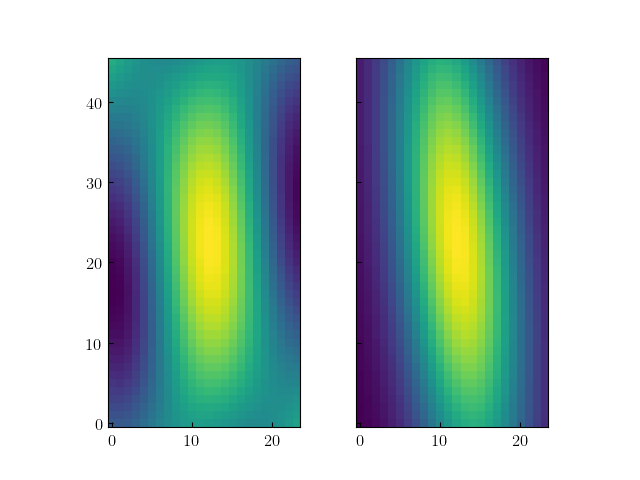

<IPython.core.display.Javascript object>


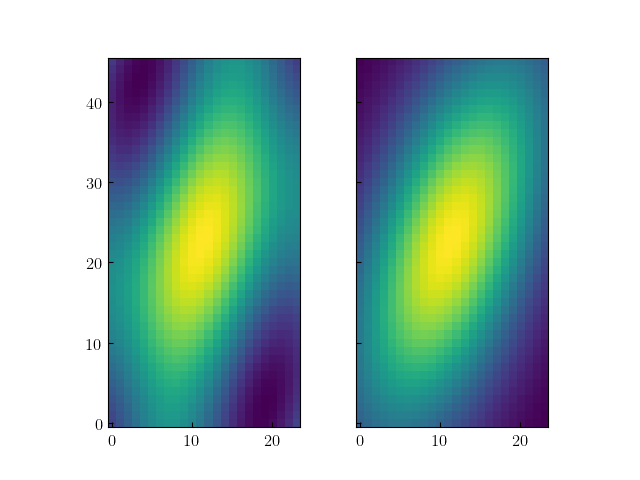

In [135]:
for calkey in ['cal', 'uncal', 'blerr']:
    for fnamei, fname in enumerate(imgdata['two-fringes'][calkey]):
        fig, axs = PLT.subplots(nrows=1, ncols=2, squeeze=True, sharex=True, sharey=True)
        axs[0].imshow(scipy_fit_output_2[calkey][fname]['data'], origin='lower')
        axs[1].imshow(scipy_fit_output_2[calkey][fname]['modelfit'], origin='lower')
        fig.subplots_adjust(hspace=0, wspace=0)

# Determine fringe NPC equations

In [136]:
points = {}
coeff_dvect_lines = {}
dvect_range_lines = {}

dl_data = NP.sin(NP.radians(NP.abs(wcs.wcs.cdelt[0])))
dm_data = NP.sin(NP.radians(NP.abs(wcs.wcs.cdelt[1])))

for calkey in ['cal', 'uncal', 'blerr']:
    points[calkey] = []
    coeff_dvect_lines[calkey] = []
    for fnamei,fname in enumerate(imgdata['two-fringes'][calkey]):
        points[calkey] += [NP.asarray([scipy_fit_output_2[calkey][fname]['parameters']['x_center'], scipy_fit_output_2[calkey][fname]['parameters']['y_center']])]
    points[calkey] = NP.asarray(points[calkey])
    coeff_dvect_lines[calkey] = GEOM.generate_line_from_point_and_slope(points[calkey], fringe_slopes_data)
    dvect_range_lines[calkey] = GEOM.generate_parallel_lines_at_distance_from_line(coeff_dvect_lines[calkey][:,:2], coeff_dvect_lines[calkey][:,2], NP.degrees(pos_err)/NP.sqrt(NP.abs(wcs.wcs.cdelt[0]*wcs.wcs.cdelt[1])))
# points2 = NP.asarray(points2)

fringe_NPC_info = {}
for calkey in ['cal', 'uncal', 'blerr']:
    fringe_NPC_info[calkey] = {}
    for fnamei,fname in enumerate(imgfilenames['bl-fringes'][calkey]):
        fringe_NPC_info[calkey][fname] = {}
        fringe_NPC_info[calkey][fname]['equation'] = coeff_dvect_lines[calkey][fnamei]
        xvals = NP.arange(imgdata[imgfilenames['bl-fringes'][calkey][fnamei]].squeeze().shape[1])
        yvals = GEOM.get_ordinate_from_abscissa_on_line(coeff_dvect_lines[calkey][fnamei][:2], coeff_dvect_lines[calkey][fnamei][2], xvals)
        yvals_lim1 = GEOM.get_ordinate_from_abscissa_on_line(coeff_dvect_lines[calkey][fnamei][:2], dvect_range_lines[calkey][fnamei][0], xvals)
        yvals_lim2 = GEOM.get_ordinate_from_abscissa_on_line(coeff_dvect_lines[calkey][fnamei][:2], dvect_range_lines[calkey][fnamei][1], xvals)
        fringe_NPC_info[calkey][fname]['xvals'] = NP.copy(xvals)
        fringe_NPC_info[calkey][fname]['yvals'] = NP.copy(yvals)
        fringe_NPC_info[calkey][fname]['yvals_lim1'] = NP.copy(yvals_lim1)
        fringe_NPC_info[calkey][fname]['yvals_lim2'] = NP.copy(yvals_lim2)
        

# calkey = 'cal'
# points1 = []
# points2 = []
# for fnamei,fname in enumerate(imgfilenames['bl-fringes'][calkey]):
#     fname_next = imgfilenames['bl-fringes'][calkey][(fnamei+1)%3]
#     fname_next2 = imgfilenames['bl-fringes'][calkey][(fnamei+2)%3]
#     fkey_out = '{0}+{1}'.format(fname.split('.fits')[0], fname_next.split('.fits')[0])
#     fkey_out2 = '{0}+{1}'.format(fname_next2.split('.fits')[0], fname.split('.fits')[0])
#     points1 += [NP.asarray([scipy_fit_output_2[fkey_out]['parameters']['x_center'], scipy_fit_output_2[fkey_out]['parameters']['y_center']])]
#     points2 += [NP.asarray([scipy_fit_output_2[fkey_out2]['parameters']['x_center'], scipy_fit_output_2[fkey_out2]['parameters']['y_center']])]
#     print(fkey_out, fkey_out2)
# points1 = NP.asarray(points1)
# points2 = NP.asarray(points2)
# coeff_dvect_lines = GEOM.generate_line_from_two_points(points1, points2)

In [137]:
print(coeff_dvect_lines)
print(fringe_slopes_data)
print(yvals)
print(yvals_lim1)
print(yvals_lim2)

{'uncal': array([[   2.63164997,    1.        ,  254.61485566],
       [  -0.48424184,    1.        ,   37.10095621],
       [  -6.29968882,    1.        , -367.77008464]]), 'blerr': array([[   2.63164997,    1.        ,  251.92969933],
       [  -0.48424184,    1.        ,   39.59260264],
       [  -6.29968882,    1.        , -357.18079734]]), 'cal': array([[   2.63164997,    1.        ,  235.46266499],
       [  -0.48424184,    1.        ,   28.48811448],
       [  -6.29968882,    1.        , -357.04260859]])}
[-2.63165     0.48424184  6.299689  ]
[-357.18079734 -350.88110853 -344.58141971 -338.28173089 -331.98204208
 -325.68235326 -319.38266445 -313.08297563 -306.78328681 -300.483598
 -294.18390918 -287.88422037 -281.58453155 -275.28484273 -268.98515392
 -262.6854651  -256.38577629 -250.08608747 -243.78639865 -237.48670984
 -231.18702102 -224.88733221 -218.58764339 -212.28795457 -205.98826576
 -199.68857694 -193.38888813 -187.08919931 -180.78951049 -174.48982168
 -168.19013286 -161.

# Verify that the fringe NPC equations determined align with the fringes in direction-cosine coordinates

<IPython.core.display.Javascript object>


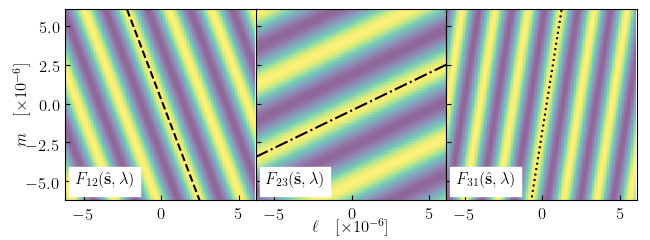

0913.fits
0919.fits
1319.fits
/lustre/aoc/users/nthyagar/projects/CPhaseGeom/figures/3C286_individual_cal_fringes_fitted_NPC_dircos.pdf


<IPython.core.display.Javascript object>


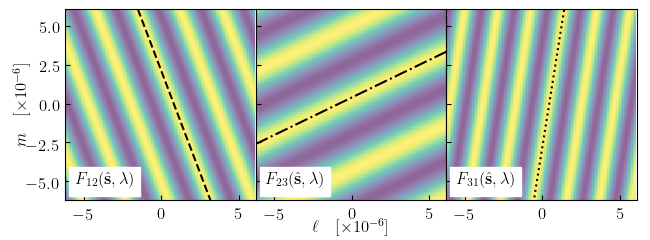

0913u.fits
0919u.fits
1319u.fits
/lustre/aoc/users/nthyagar/projects/CPhaseGeom/figures/3C286_individual_uncal_fringes_fitted_NPC_dircos.pdf


<IPython.core.display.Javascript object>


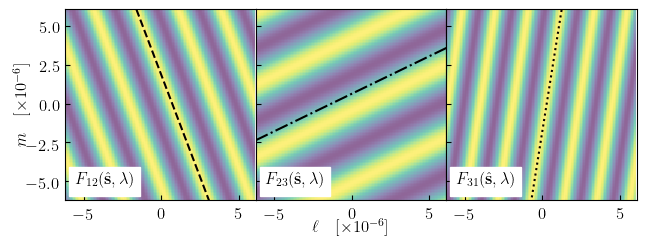

0913cb.fits
0919.fits
1319.fits
/lustre/aoc/users/nthyagar/projects/CPhaseGeom/figures/3C286_individual_blerr_fringes_fitted_NPC_dircos.pdf


In [138]:
fname = '0913.fits'
wcs = WCS(imghdrs[fname]).celestial
center = wcs.all_world2pix(NP.asarray([wcs.wcs.crval[0], wcs.wcs.crval[1]]).reshape(-1,2), 0)
lvect_data = (NP.arange(imghdrs['0919.fits']['NAXIS1']) - center[0,0]) * NP.abs(dl_data)
mvect_data = (NP.arange(imghdrs['0919.fits']['NAXIS2']) - center[0,1]) * NP.abs(dm_data)

ls = ['--', '-.', ':']
for calkey in ['cal', 'uncal', 'blerr']:
    fig, axs = PLT.subplots(nrows=1, ncols=3, squeeze=True, sharex=True, sharey=True, subplot_kw={'aspect': 'equal'}, figsize=(6.5,2.4))
    for fnamei, fname in enumerate(imgfilenames['bl-fringes'][calkey]):
        print(fname)
        data = imgdata[fname].squeeze()[:,::-1]
        axs[fnamei].pcolorfast((lvect_data-0.5*dl_data)/1e-6, (mvect_data-0.5*dm_data)/1e-6, data[:-1,:-1].real, cmap='viridis', alpha=0.6)

#         axs[fnamei].imshow(data, origin='lower', cmap='viridis', interpolation='none', alpha=0.6)
#         ax.text(center[0,0]-1, center[0,1], 'O', transform=ax.transData, ha='center', va='center', fontsize=10, color='magenta')
#         fname_next = imgfilenames['bl-fringes'][calkey][(fnamei+1)%3]
#         fname_next2 = imgfilenames['bl-fringes'][calkey][(fnamei+2)%3]
        l_xvals = (fringe_NPC_info[calkey][fname]['xvals'] - center[0,0]) * NP.abs(dl_data)
        m_yvals = (fringe_NPC_info[calkey][fname]['yvals'] - center[0,1]) * NP.abs(dm_data)
        axs[fnamei].plot(l_xvals/1e-6, m_yvals/1e-6, color='black', ls=ls[fnamei])
#         ax.plot(fringe_NPC_info[calkey][fname_next]['xvals'], fringe_NPC_info[calkey][fname_next]['yvals'], color='black', ls='-')
#         ax.plot(fringe_NPC_info[calkey][fname_next2]['xvals'], fringe_NPC_info[calkey][fname_next2]['yvals'], color='black', ls='-')
        axs[fnamei].set_xlim(lvect_data.min()/1e-6, lvect_data.max()/1e-6)
        axs[fnamei].set_ylim(mvect_data.min()/1e-6, mvect_data.max()/1e-6)

    axs[0].text(0.05, 0.05, r'$F_{12}(\hat{\mathbf{s}},\lambda)$', ha='left', va='bottom', transform=axs[0].transAxes, fontsize=12, color='black', backgroundcolor='white')
    axs[1].text(0.05, 0.05, r'$F_{23}(\hat{\mathbf{s}},\lambda)$', ha='left', va='bottom', transform=axs[1].transAxes, fontsize=12, color='black', backgroundcolor='white')
    axs[2].text(0.05, 0.05, r'$F_{31}(\hat{\mathbf{s}},\lambda)$', ha='left', va='bottom', transform=axs[2].transAxes, fontsize=12, color='black', backgroundcolor='white')

    fig.subplots_adjust(hspace=0, wspace=0)
    fig.subplots_adjust(left=0.1, right=0.98, bottom=0.15, top=0.98)

    big_ax = fig.add_subplot(111)
    big_ax.set_facecolor('none') # matplotlib.__version__ >= 2.0.0
    # big_ax.set_axis_bgcolor('none') # matplotlib.__version__ < 2.0.0
    big_ax.spines['right'].set_visible(False)
    big_ax.spines['top'].set_visible(False)
    big_ax.spines['left'].set_visible(False)
    big_ax.spines['bottom'].set_visible(False)
    big_ax.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
    big_ax.set_xticks([])
    big_ax.set_yticks([])
    big_ax.set_xlabel(r'$\ell \quad [\times 10^{-6}]$', fontsize=12, weight='medium', labelpad=10)
    big_ax.set_ylabel(r'$m \quad [\times 10^{-6}]$', fontsize=12, weight='medium', labelpad=25)

#     PLT.savefig(figdir+'3C286_individual_{0}_fringes_fitted_NPC_dircos.pdf'.format(calkey), bbox_inches=0)
    print(figdir+'3C286_individual_{0}_fringes_fitted_NPC_dircos.pdf'.format(calkey))


In [ ]:
# fname = '0913.fits'
# wcs = WCS(imghdrs[fname]).celestial
# center = wcs.all_world2pix(NP.asarray([wcs.wcs.crval[0], wcs.wcs.crval[1]]).reshape(-1,2), 0)
# lvect_data = (NP.arange(imghdrs['0919.fits']['NAXIS1']) - center[0,0]) * NP.abs(dl_data)
# mvect_data = (NP.arange(imghdrs['0919.fits']['NAXIS2']) - center[0,1]) * NP.abs(dm_data)

# ls = ['--', '-.', ':']
# for calkey in ['cal', 'uncal']:
#     fig, axs = PLT.subplots(nrows=1, ncols=3, squeeze=True, sharex=True, sharey=True, subplot_kw={'aspect': 'equal'}, figsize=(6.5,2.4))
#     for fnamei, fname in enumerate(imgfilenames['bl-fringes'][calkey]):
#         data = imgdata[fname].squeeze()[:,::-1]
#         axs[fnamei].pcolorfast((lvect_data-0.5*dl_data)/1e-6, (mvect_data-0.5*dm_data)/1e-6, data[:-1,:-1].real, cmap='viridis', alpha=0.6)

# #         axs[fnamei].imshow(data, origin='lower', cmap='viridis', interpolation='none', alpha=0.6)
# #         ax.text(center[0,0]-1, center[0,1], 'O', transform=ax.transData, ha='center', va='center', fontsize=10, color='magenta')
# #         fname_next = imgfilenames['bl-fringes'][calkey][(fnamei+1)%3]
# #         fname_next2 = imgfilenames['bl-fringes'][calkey][(fnamei+2)%3]
#         l_xvals = (fringe_NPC_info[calkey][fname]['xvals'] - center[0,0]) * NP.abs(dl_data)
#         m_yvals = (fringe_NPC_info[calkey][fname]['yvals'] - center[0,1]) * NP.abs(dm_data)
#         axs[fnamei].plot(l_xvals/1e-6, m_yvals/1e-6, color='black', ls=ls[fnamei])
# #         ax.plot(fringe_NPC_info[calkey][fname_next]['xvals'], fringe_NPC_info[calkey][fname_next]['yvals'], color='black', ls='-')
# #         ax.plot(fringe_NPC_info[calkey][fname_next2]['xvals'], fringe_NPC_info[calkey][fname_next2]['yvals'], color='black', ls='-')
#         axs[fnamei].set_xlim(lvect_data.min()/1e-6, lvect_data.max()/1e-6)
#         axs[fnamei].set_ylim(mvect_data.min()/1e-6, mvect_data.max()/1e-6)

#     axs[0].text(0.05, 0.05, r'$F_{12}(\hat{\mathbf{s}},\lambda)$', ha='left', va='bottom', transform=axs[0].transAxes, fontsize=10, color='black', backgroundcolor='white')
#     axs[1].text(0.05, 0.05, r'$F_{23}(\hat{\mathbf{s}},\lambda)$', ha='left', va='bottom', transform=axs[1].transAxes, fontsize=10, color='black', backgroundcolor='white')
#     axs[2].text(0.05, 0.05, r'$F_{31}(\hat{\mathbf{s}},\lambda)$', ha='left', va='bottom', transform=axs[2].transAxes, fontsize=10, color='black', backgroundcolor='white')

#     fig.subplots_adjust(hspace=0, wspace=0)
#     fig.subplots_adjust(left=0.1, right=0.98, bottom=0.15, top=0.98)

#     big_ax = fig.add_subplot(111)
#     big_ax.set_facecolor('none') # matplotlib.__version__ >= 2.0.0
#     # big_ax.set_axis_bgcolor('none') # matplotlib.__version__ < 2.0.0
#     big_ax.spines['right'].set_visible(False)
#     big_ax.spines['top'].set_visible(False)
#     big_ax.spines['left'].set_visible(False)
#     big_ax.spines['bottom'].set_visible(False)
#     big_ax.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
#     big_ax.set_xticks([])
#     big_ax.set_yticks([])
#     big_ax.set_xlabel(r'$l \quad [\times 10^{-6}]$', fontsize=10, weight='medium', labelpad=10)
#     big_ax.set_ylabel(r'$m \quad [\times 10^{-6}]$', fontsize=10, weight='medium', labelpad=25)

#     PLT.savefig(figdir+'3C286_individual_{0}_fringes_fitted_NPC_dircos.pdf'.format(calkey), bbox_inches=0)
#     print(figdir+'3C286_individual_{0}_fringes_fitted_NPC_dircos.pdf'.format(calkey))


# Verify that the fringe NPC equations determined align with the fringes in RA-Dec coordinates

<IPython.core.display.Javascript object>


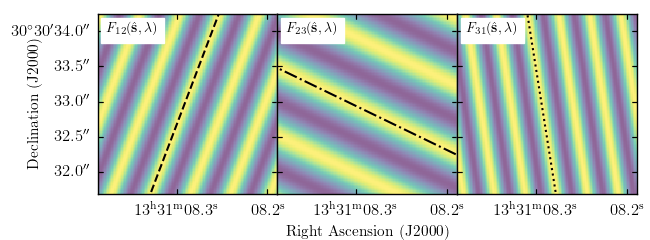

/lustre/aoc/users/nthyagar/projects/CPhaseGeom/figures/3C286_individual_cal_fringes_fitted_NPC.pdf


<IPython.core.display.Javascript object>


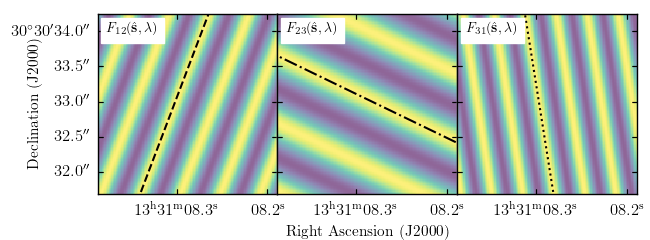

/lustre/aoc/users/nthyagar/projects/CPhaseGeom/figures/3C286_individual_uncal_fringes_fitted_NPC.pdf


<IPython.core.display.Javascript object>


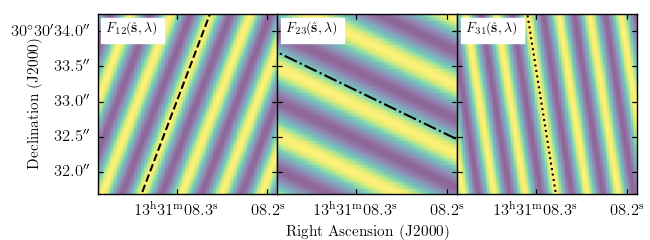

/lustre/aoc/users/nthyagar/projects/CPhaseGeom/figures/3C286_individual_blerr_fringes_fitted_NPC.pdf


In [139]:
fname = '0913.fits'
wcs = WCS(imghdrs[fname]).celestial
center = wcs.all_world2pix(NP.asarray([wcs.wcs.crval[0], wcs.wcs.crval[1]]).reshape(-1,2), 0)

ls = ['--', '-.', ':']
for calkey in ['cal', 'uncal', 'blerr']:
    fig, axs = PLT.subplots(nrows=1, ncols=3, squeeze=True, sharex=True, sharey=True, subplot_kw={'projection': wcs, 'aspect': 'equal'}, figsize=(6.5,2.4))
    for fnamei, fname in enumerate(imgfilenames['bl-fringes'][calkey]):
        data = imgdata[fname].squeeze()
#         axs[fnamei].pcolorfast((lvect_data-0.5*dl_data)/1e-6, (mvect_data-0.5*dm_data)/1e-6, data[:-1,:-1].real, cmap='viridis', alpha=0.6)

        axs[fnamei].imshow(data, origin='lower', cmap='viridis', interpolation='none', alpha=0.6)
        xvals = fringe_NPC_info[calkey][fname]['xvals']
        yvals = fringe_NPC_info[calkey][fname]['yvals']
        axs[fnamei].plot(xvals[::-1], yvals, color='black', ls=ls[fnamei])
        axs[fnamei].set_xlim(0, data.shape[1])
        axs[fnamei].set_ylim(0, data.shape[0])

        lon = axs[fnamei].coords[0]
        lat = axs[fnamei].coords[1]
        lon.set_major_formatter('hh:mm:ss.s')
        lat.set_major_formatter('dd:mm:ss.s')
        lon.set_separator((r'$^\mathrm{h}$', r'$^\mathrm{m}$', r'$^\mathrm{s}$'))
        lat.set_separator((r'$^\circ$', r'$^\prime$', r'$^{\prime\prime}$'))    
        if fnamei > 0:
            lat.set_ticklabel_visible(False)

    axs[0].text(0.05, 0.95, r'$F_{12}(\hat{\mathbf{s}},\lambda)$', ha='left', va='top', transform=axs[0].transAxes, fontsize=10, color='black', backgroundcolor='white')
    axs[1].text(0.05, 0.95, r'$F_{23}(\hat{\mathbf{s}},\lambda)$', ha='left', va='top', transform=axs[1].transAxes, fontsize=10, color='black', backgroundcolor='white')
    axs[2].text(0.05, 0.95, r'$F_{31}(\hat{\mathbf{s}},\lambda)$', ha='left', va='top', transform=axs[2].transAxes, fontsize=10, color='black', backgroundcolor='white')

    fig.subplots_adjust(hspace=0, wspace=0)
    fig.subplots_adjust(left=0.15, right=0.98, bottom=0.15, top=0.98)

    big_ax = fig.add_subplot(111)
    big_ax.set_facecolor('none') # matplotlib.__version__ >= 2.0.0
    # big_ax.set_axis_bgcolor('none') # matplotlib.__version__ < 2.0.0
    big_ax.spines['right'].set_visible(False)
    big_ax.spines['top'].set_visible(False)
    big_ax.spines['left'].set_visible(False)
    big_ax.spines['bottom'].set_visible(False)
    big_ax.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
    big_ax.set_xticks([])
    big_ax.set_yticks([])
    big_ax.set_xlabel('Right Ascension (J2000)', fontsize=11, weight='medium', labelpad=15)
    big_ax.set_ylabel('Declination (J2000)', fontsize=11, weight='medium', labelpad=40)

#     PLT.savefig(figdir+'3C286_individual_{0}_fringes_fitted_NPC.pdf'.format(calkey), bbox_inches=0)
    print(figdir+'3C286_individual_{0}_fringes_fitted_NPC.pdf'.format(calkey))

In [ ]:
# fname = '0913.fits'
# wcs = WCS(imghdrs[fname]).celestial
# center = wcs.all_world2pix(NP.asarray([wcs.wcs.crval[0], wcs.wcs.crval[1]]).reshape(-1,2), 0)

# ls = ['--', '-.', ':']
# for calkey in ['cal', 'uncal']:
#     fig, axs = PLT.subplots(nrows=1, ncols=3, squeeze=True, sharex=True, sharey=True, subplot_kw={'projection': wcs, 'aspect': 'equal'}, figsize=(6.5,2.4))
#     for fnamei, fname in enumerate(imgfilenames['bl-fringes'][calkey]):
#         data = imgdata[fname].squeeze()
# #         axs[fnamei].pcolorfast((lvect_data-0.5*dl_data)/1e-6, (mvect_data-0.5*dm_data)/1e-6, data[:-1,:-1].real, cmap='viridis', alpha=0.6)

#         axs[fnamei].imshow(data, origin='lower', cmap='viridis', interpolation='none', alpha=0.6)
#         xvals = fringe_NPC_info[calkey][fname]['xvals']
#         yvals = fringe_NPC_info[calkey][fname]['yvals']
#         axs[fnamei].plot(xvals[::-1], yvals, color='black', ls=ls[fnamei])
#         axs[fnamei].set_xlim(0, data.shape[1])
#         axs[fnamei].set_ylim(0, data.shape[0])

#         lon = axs[fnamei].coords[0]
#         lat = axs[fnamei].coords[1]
#         lon.set_major_formatter('hh:mm:ss.s')
#         lat.set_major_formatter('dd:mm:ss.s')
#         lon.set_separator((r'$^\mathrm{h}$', r'$^\mathrm{m}$', r'$^\mathrm{s}$'))
#         lat.set_separator((r'$^\circ$', r'$^\prime$', r'$^{\prime\prime}$'))    
#         if fnamei > 0:
#             lat.set_ticklabel_visible(False)

#     axs[0].text(0.05, 0.95, r'$F_{12}(\hat{\mathbf{s}},\lambda)$', ha='left', va='top', transform=axs[0].transAxes, fontsize=10, color='black', backgroundcolor='white')
#     axs[1].text(0.05, 0.95, r'$F_{23}(\hat{\mathbf{s}},\lambda)$', ha='left', va='top', transform=axs[1].transAxes, fontsize=10, color='black', backgroundcolor='white')
#     axs[2].text(0.05, 0.95, r'$F_{31}(\hat{\mathbf{s}},\lambda)$', ha='left', va='top', transform=axs[2].transAxes, fontsize=10, color='black', backgroundcolor='white')

#     fig.subplots_adjust(hspace=0, wspace=0)
#     fig.subplots_adjust(left=0.15, right=0.98, bottom=0.15, top=0.98)

#     big_ax = fig.add_subplot(111)
#     big_ax.set_facecolor('none') # matplotlib.__version__ >= 2.0.0
#     # big_ax.set_axis_bgcolor('none') # matplotlib.__version__ < 2.0.0
#     big_ax.spines['right'].set_visible(False)
#     big_ax.spines['top'].set_visible(False)
#     big_ax.spines['left'].set_visible(False)
#     big_ax.spines['bottom'].set_visible(False)
#     big_ax.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
#     big_ax.set_xticks([])
#     big_ax.set_yticks([])
#     big_ax.set_xlabel('Right Ascension (J2000)', fontsize=10, weight='medium', labelpad=15)
#     big_ax.set_ylabel('Declination (J2000)', fontsize=10, weight='medium', labelpad=40)

#     PLT.savefig(figdir+'3C286_individual_{0}_fringes_fitted_NPC.pdf'.format(calkey), bbox_inches=0)
#     print(figdir+'3C286_individual_{0}_fringes_fitted_NPC.pdf'.format(calkey))

<IPython.core.display.Javascript object>


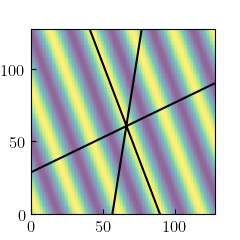

<IPython.core.display.Javascript object>


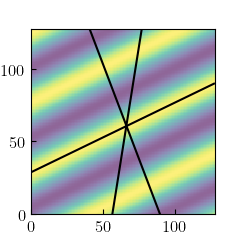

<IPython.core.display.Javascript object>


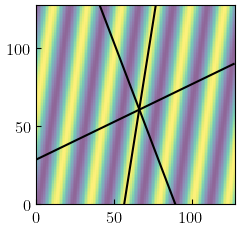

/lustre/aoc/users/nthyagar/projects/CPhaseGeom/figures/3C286_individual_cal_fringes_fitted_NPC.pdf


<IPython.core.display.Javascript object>


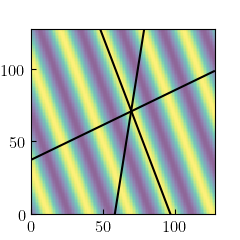

<IPython.core.display.Javascript object>


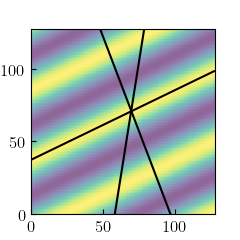

<IPython.core.display.Javascript object>


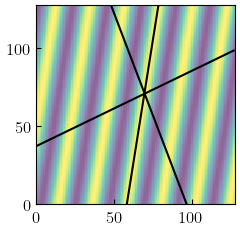

/lustre/aoc/users/nthyagar/projects/CPhaseGeom/figures/3C286_individual_uncal_fringes_fitted_NPC.pdf


<IPython.core.display.Javascript object>


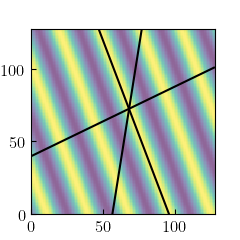

<IPython.core.display.Javascript object>


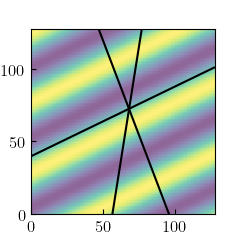

<IPython.core.display.Javascript object>


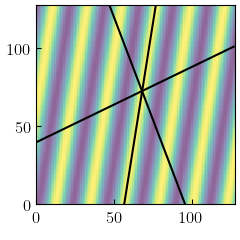

/lustre/aoc/users/nthyagar/projects/CPhaseGeom/figures/3C286_individual_blerr_fringes_fitted_NPC.pdf


In [140]:
fname = '0913.fits'
wcs = WCS(imghdrs[fname]).celestial
center = wcs.all_world2pix(NP.asarray([wcs.wcs.crval[0], wcs.wcs.crval[1]]).reshape(-1,2), 0)

ls = ['--', '-.', ':']
for calkey in ['cal', 'uncal', 'blerr']:
    for fnamei, fname in enumerate(imgfilenames['bl-fringes'][calkey]):
        fig, ax = PLT.subplots(nrows=1, ncols=1, squeeze=True, sharex=True, sharey=True, subplot_kw={'aspect': 'equal'}, figsize=(2.4,2.4))
        data = imgdata[fname].squeeze()[:,::-1]
        center = wcs.all_world2pix(NP.asarray([wcs.wcs.crval[0], wcs.wcs.crval[1]]).reshape(-1,2), 0)
        ax.imshow(data, origin='lower', cmap='viridis', interpolation='none', alpha=0.6)
#         ax.text(center[0,0]-1, center[0,1], 'O', transform=ax.transData, ha='center', va='center', fontsize=10, color='magenta')
        ax.set_xlim(0, data.shape[1])
        ax.set_ylim(0, data.shape[0])
        fname_next = imgfilenames['bl-fringes'][calkey][(fnamei+1)%3]
        fname_next2 = imgfilenames['bl-fringes'][calkey][(fnamei+2)%3]
        ax.plot(fringe_NPC_info[calkey][fname]['xvals'], fringe_NPC_info[calkey][fname]['yvals'], color='black', ls='-')
        ax.plot(fringe_NPC_info[calkey][fname_next]['xvals'], fringe_NPC_info[calkey][fname_next]['yvals'], color='black', ls='-')
        ax.plot(fringe_NPC_info[calkey][fname_next2]['xvals'], fringe_NPC_info[calkey][fname_next2]['yvals'], color='black', ls='-')
    fig.subplots_adjust(hspace=0, wspace=0)
    fig.subplots_adjust(left=0.15, right=0.98, bottom=0.15, top=0.98)

    big_ax = fig.add_subplot(111)
    big_ax.set_facecolor('none') # matplotlib.__version__ >= 2.0.0
    # big_ax.set_axis_bgcolor('none') # matplotlib.__version__ < 2.0.0
    big_ax.spines['right'].set_visible(False)
    big_ax.spines['top'].set_visible(False)
    big_ax.spines['left'].set_visible(False)
    big_ax.spines['bottom'].set_visible(False)
    big_ax.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
    big_ax.set_xticks([])
    big_ax.set_yticks([])
    # big_ax.set_xlabel('Right Ascension (J2000)', fontsize=10, weight='medium', labelpad=10)
    # big_ax.set_ylabel('Declination (J2000)', fontsize=10, weight='medium', labelpad=40)

    # PLT.savefig(figdir+'3C286_individual_cal_fringes.pdf', bbox_inches=0)
    print(figdir+'3C286_individual_{0}_fringes_fitted_NPC.pdf'.format(calkey))


# Plot three fringe images calibrated and uncalibrated with fitted NPC in direction-cosine coordinates 

<IPython.core.display.Javascript object>


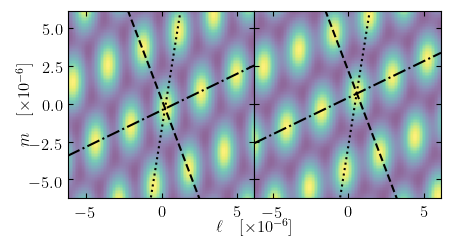

/lustre/aoc/users/nthyagar/projects/CPhaseGeom/figures/3C286_all_fringes_fitted_NPC_dircos.pdf


<IPython.core.display.Javascript object>


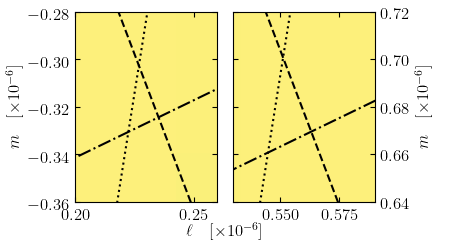

/lustre/aoc/users/nthyagar/projects/CPhaseGeom/figures/3C286_all_fringes_fitted_NPC_zoomed_dircos.pdf
/lustre/aoc/users/nthyagar/projects/CPhaseGeom/figures/3C286_all_fringes_fitted_NPC_zoomed_dircos.pdf


In [141]:
fname = '0913.fits'
wcs = WCS(imghdrs[fname]).celestial
center = wcs.all_world2pix(NP.asarray([wcs.wcs.crval[0], wcs.wcs.crval[1]]).reshape(-1,2), 0)
lvect_data = (NP.arange(imghdrs['0919.fits']['NAXIS1']) - center[0,0]) * NP.abs(dl_data)
mvect_data = (NP.arange(imghdrs['0919.fits']['NAXIS2']) - center[0,1]) * NP.abs(dm_data)

ls = ['--', '-.', ':']

fig, axs = PLT.subplots(nrows=1, ncols=2, squeeze=True, sharex=True, sharey=True, subplot_kw={'aspect': 'equal'}, figsize=(4.5,2.4))
for calind,calkey in enumerate(['cal', 'uncal']):
    fname = imgfilenames['triad-fringes'][calkey]
    data = imgdata[fname].squeeze()[:,::-1]
    axs[calind].pcolorfast((lvect_data-0.5*dl_data)/1e-6, (mvect_data-0.5*dm_data)/1e-6, data[:-1,:-1].real, cmap='viridis', alpha=0.6)
    for fnamej, fn in enumerate(imgfilenames['bl-fringes'][calkey]):
        l_xvals = (fringe_NPC_info[calkey][fn]['xvals'] - center[0,0]) * NP.abs(dl_data)
        m_yvals = (fringe_NPC_info[calkey][fn]['yvals'] - center[0,1]) * NP.abs(dm_data)
        axs[calind].plot(l_xvals/1e-6, m_yvals/1e-6, color='black', ls=ls[fnamej])
    axs[calind].set_xlim(lvect_data.min()/1e-6, lvect_data.max()/1e-6)
    axs[calind].set_ylim(mvect_data.min()/1e-6, mvect_data.max()/1e-6)
    axs[calind].tick_params(bottom=True, top=True, left=True, right=True)

fig.subplots_adjust(hspace=0, wspace=0)
fig.subplots_adjust(left=0.15, right=0.98, bottom=0.15, top=0.98)

big_ax = fig.add_subplot(111)
big_ax.set_facecolor('none') # matplotlib.__version__ >= 2.0.0
# big_ax.set_axis_bgcolor('none') # matplotlib.__version__ < 2.0.0
big_ax.spines['right'].set_visible(False)
big_ax.spines['top'].set_visible(False)
big_ax.spines['left'].set_visible(False)
big_ax.spines['bottom'].set_visible(False)
big_ax.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
big_ax.set_xticks([])
big_ax.set_yticks([])
big_ax.set_xlabel(r'$\ell \quad [\times 10^{-6}]$', fontsize=12, weight='medium', labelpad=10)
big_ax.set_ylabel(r'$m \quad [\times 10^{-6}]$', fontsize=12, weight='medium', labelpad=25)

# PLT.savefig(figdir+'3C286_all_fringes_fitted_NPC_dircos.pdf', bbox_inches=0)
print(figdir+'3C286_all_fringes_fitted_NPC_dircos.pdf')

fig, axs = PLT.subplots(nrows=1, ncols=2, squeeze=True, sharex=False, sharey=False, subplot_kw={'aspect': 'equal'}, figsize=(4.5,2.4))
for calind,calkey in enumerate(['cal', 'uncal']):
    fname = imgfilenames['triad-fringes'][calkey]
    data = imgdata[fname].squeeze()[:,::-1]
    axs[calind].pcolorfast((lvect_data-0.5*dl_data)/1e-6, (mvect_data-0.5*dm_data)/1e-6, data[:-1,:-1].real, cmap='viridis', alpha=0.6)
    for fnamej, fn in enumerate(imgfilenames['bl-fringes'][calkey]):
        l_xvals = (fringe_NPC_info[calkey][fn]['xvals'] - center[0,0]) * NP.abs(dl_data)
        m_yvals = (fringe_NPC_info[calkey][fn]['yvals'] - center[0,1]) * NP.abs(dm_data)
        axs[calind].plot(l_xvals/1e-6, m_yvals/1e-6, color='black', ls=ls[fnamej])
    if calkey == 'cal': 
        axs[calind].set_xlim(0.2, 0.26)
        axs[calind].set_ylim(-0.36, -0.28)
        axs[calind].tick_params(bottom=True, top=True, left=True, right=True)
        axs[calind].set_ylabel(r'$m \quad [\times 10^{-6}]$', fontsize=12, weight='medium')
    else:
        axs[calind].set_xlim(0.53, 0.59)
        axs[calind].set_ylim(0.64, 0.72)
        axs[calind].yaxis.tick_right()
        axs[calind].yaxis.set_label_position('right')
        axs[calind].tick_params(bottom=True, top=True, left=True, right=True)
        axs[calind].tick_params(labelbottom=True, labeltop=False, labelleft=False, labelright=True)
        axs[calind].set_ylabel(r'$m \quad [\times 10^{-6}]$', fontsize=12, weight='medium')
        
    fig.subplots_adjust(hspace=0, wspace=0)
    fig.subplots_adjust(left=0.15, right=0.85, bottom=0.16, top=0.95)

    big_ax = fig.add_subplot(111)
    big_ax.set_facecolor('none') # matplotlib.__version__ >= 2.0.0
    # big_ax.set_axis_bgcolor('none') # matplotlib.__version__ < 2.0.0
    big_ax.spines['right'].set_visible(False)
    big_ax.spines['top'].set_visible(False)
    big_ax.spines['left'].set_visible(False)
    big_ax.spines['bottom'].set_visible(False)
    big_ax.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
    big_ax.set_xticks([])
    big_ax.set_yticks([])
    big_ax.set_xlabel(r'$\ell \quad [\times 10^{-6}]$', fontsize=12, weight='medium', labelpad=15)

#     PLT.savefig(figdir+'3C286_all_fringes_fitted_NPC_zoomed_dircos.pdf', bbox_inches=0)
    print(figdir+'3C286_all_fringes_fitted_NPC_zoomed_dircos.pdf')

<IPython.core.display.Javascript object>


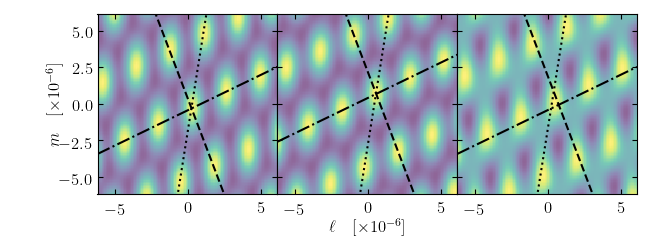

cal
uncal
blerr
/lustre/aoc/users/nthyagar/projects/CPhaseGeom/figures/3C286_all_fringes_fitted_NPC_dircos.pdf


<IPython.core.display.Javascript object>


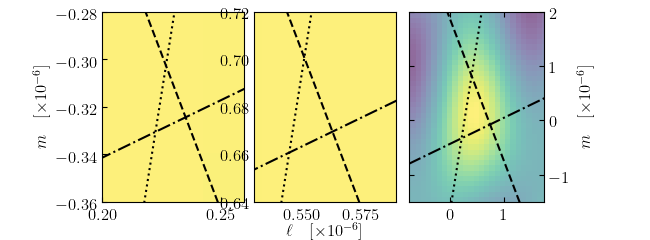

/lustre/aoc/users/nthyagar/projects/CPhaseGeom/figures/3C286_all_fringes_fitted_NPC_zoomed_dircos.pdf
/lustre/aoc/users/nthyagar/projects/CPhaseGeom/figures/3C286_all_fringes_fitted_NPC_zoomed_dircos.pdf
/lustre/aoc/users/nthyagar/projects/CPhaseGeom/figures/3C286_all_fringes_fitted_NPC_zoomed_dircos.pdf


In [157]:
fname = '0913.fits'
wcs = WCS(imghdrs[fname]).celestial
center = wcs.all_world2pix(NP.asarray([wcs.wcs.crval[0], wcs.wcs.crval[1]]).reshape(-1,2), 0)
lvect_data = (NP.arange(imghdrs['0919.fits']['NAXIS1']) - center[0,0]) * NP.abs(dl_data)
mvect_data = (NP.arange(imghdrs['0919.fits']['NAXIS2']) - center[0,1]) * NP.abs(dm_data)

ls = ['--', '-.', ':']

fig, axs = PLT.subplots(nrows=1, ncols=3, squeeze=True, sharex=True, sharey=True, subplot_kw={'aspect': 'equal'}, figsize=(6.5,2.4))
for calind,calkey in enumerate(['cal', 'uncal', 'blerr']):
    print(calkey)
    fname = imgfilenames['triad-fringes'][calkey]
    data = imgdata[fname].squeeze()[:,::-1]
    axs[calind].pcolorfast((lvect_data-0.5*dl_data)/1e-6, (mvect_data-0.5*dm_data)/1e-6, data[:-1,:-1].real, cmap='viridis', alpha=0.6)
    for fnamej, fn in enumerate(imgfilenames['bl-fringes'][calkey]):
        if calkey == 'blerr':
            if fn == '0913cb.fits':
                l_xvals = (fringe_NPC_info[calkey][fn]['xvals'] - center[0,0]) * NP.abs(dl_data)
                m_yvals = (fringe_NPC_info[calkey][fn]['yvals'] - center[0,1]) * NP.abs(dm_data)  
            else:
                l_xvals = (fringe_NPC_info['cal'][fn]['xvals'] - center[0,0]) * NP.abs(dl_data)
                m_yvals = (fringe_NPC_info['cal'][fn]['yvals'] - center[0,1]) * NP.abs(dm_data)                  
        else:
            l_xvals = (fringe_NPC_info[calkey][fn]['xvals'] - center[0,0]) * NP.abs(dl_data)
            m_yvals = (fringe_NPC_info[calkey][fn]['yvals'] - center[0,1]) * NP.abs(dm_data)
        axs[calind].plot(l_xvals/1e-6, m_yvals/1e-6, color='black', ls=ls[fnamej])
    axs[calind].set_xlim(lvect_data.min()/1e-6, lvect_data.max()/1e-6)
    axs[calind].set_ylim(mvect_data.min()/1e-6, mvect_data.max()/1e-6)
    axs[calind].tick_params(bottom=True, top=True, left=True, right=True)

fig.subplots_adjust(hspace=0, wspace=0)
fig.subplots_adjust(left=0.15, right=0.98, bottom=0.15, top=0.98)

big_ax = fig.add_subplot(111)
big_ax.set_facecolor('none') # matplotlib.__version__ >= 2.0.0
# big_ax.set_axis_bgcolor('none') # matplotlib.__version__ < 2.0.0
big_ax.spines['right'].set_visible(False)
big_ax.spines['top'].set_visible(False)
big_ax.spines['left'].set_visible(False)
big_ax.spines['bottom'].set_visible(False)
big_ax.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
big_ax.set_xticks([])
big_ax.set_yticks([])
big_ax.set_xlabel(r'$\ell \quad [\times 10^{-6}]$', fontsize=12, weight='medium', labelpad=10)
big_ax.set_ylabel(r'$m \quad [\times 10^{-6}]$', fontsize=12, weight='medium', labelpad=25)

# PLT.savefig(figdir+'3C286_all_fringes_fitted_NPC_dircos.pdf', bbox_inches=0)
print(figdir+'3C286_all_fringes_fitted_NPC_dircos.pdf')

fig, axs = PLT.subplots(nrows=1, ncols=3, squeeze=True, sharex=False, sharey=False, subplot_kw={'aspect': 'equal'}, figsize=(6.5,2.4))
for calind,calkey in enumerate(['cal', 'uncal', 'blerr']):
    fname = imgfilenames['triad-fringes'][calkey]
    data = imgdata[fname].squeeze()[:,::-1]
    axs[calind].pcolorfast((lvect_data-0.5*dl_data)/1e-6, (mvect_data-0.5*dm_data)/1e-6, data[:-1,:-1].real, cmap='viridis', alpha=0.6)
    for fnamej, fn in enumerate(imgfilenames['bl-fringes'][calkey]):
        if calkey == 'blerr':
            if fn == '0913cb.fits':
                l_xvals = (fringe_NPC_info[calkey][fn]['xvals'] - center[0,0]) * NP.abs(dl_data)
                m_yvals = (fringe_NPC_info[calkey][fn]['yvals'] - center[0,1]) * NP.abs(dm_data)  
            else:
                l_xvals = (fringe_NPC_info['cal'][fn]['xvals'] - center[0,0]) * NP.abs(dl_data)
                m_yvals = (fringe_NPC_info['cal'][fn]['yvals'] - center[0,1]) * NP.abs(dm_data)                  
        else:
            l_xvals = (fringe_NPC_info[calkey][fn]['xvals'] - center[0,0]) * NP.abs(dl_data)
            m_yvals = (fringe_NPC_info[calkey][fn]['yvals'] - center[0,1]) * NP.abs(dm_data)
        axs[calind].plot(l_xvals/1e-6, m_yvals/1e-6, color='black', ls=ls[fnamej])
    if calkey == 'cal': 
        axs[calind].set_xlim(0.2, 0.26)
        axs[calind].set_ylim(-0.36, -0.28)
        axs[calind].tick_params(bottom=True, top=True, left=True, right=True)
        axs[calind].set_ylabel(r'$m \quad [\times 10^{-6}]$', fontsize=12, weight='medium')
    elif calkey == 'uncal':
        axs[calind].set_xlim(0.53, 0.59)
        axs[calind].set_ylim(0.64, 0.72)        
        axs[calind].tick_params(bottom=False, top=False, left=False, right=False)
    else:
        axs[calind].set_xlim(-0.75, 1.75)
        axs[calind].set_ylim(-1.5, 2.0)
        axs[calind].yaxis.tick_right()
        axs[calind].yaxis.set_label_position('right')
        axs[calind].tick_params(bottom=True, top=True, left=True, right=True)
        axs[calind].tick_params(labelbottom=True, labeltop=False, labelleft=False, labelright=True)
        axs[calind].set_ylabel(r'$m \quad [\times 10^{-6}]$', fontsize=12, weight='medium')
        
    fig.subplots_adjust(hspace=0, wspace=0)
    fig.subplots_adjust(left=0.15, right=0.85, bottom=0.16, top=0.95)

    big_ax = fig.add_subplot(111)
    big_ax.set_facecolor('none') # matplotlib.__version__ >= 2.0.0
    # big_ax.set_axis_bgcolor('none') # matplotlib.__version__ < 2.0.0
    big_ax.spines['right'].set_visible(False)
    big_ax.spines['top'].set_visible(False)
    big_ax.spines['left'].set_visible(False)
    big_ax.spines['bottom'].set_visible(False)
    big_ax.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
    big_ax.set_xticks([])
    big_ax.set_yticks([])
    big_ax.set_xlabel(r'$\ell \quad [\times 10^{-6}]$', fontsize=12, weight='medium', labelpad=15)

#     PLT.savefig(figdir+'3C286_all_fringes_fitted_NPC_zoomed_dircos.pdf', bbox_inches=0)
    print(figdir+'3C286_all_fringes_fitted_NPC_zoomed_dircos.pdf')

# Plot three fringe images calibrated and uncalibrated with fitted NPC in RA-Dec coordinates 

<IPython.core.display.Javascript object>


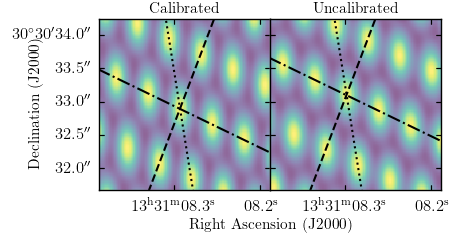

/lustre/aoc/users/nthyagar/projects/CPhaseGeom/figures/3C286_all_fringes_fitted_NPC.pdf


<IPython.core.display.Javascript object>


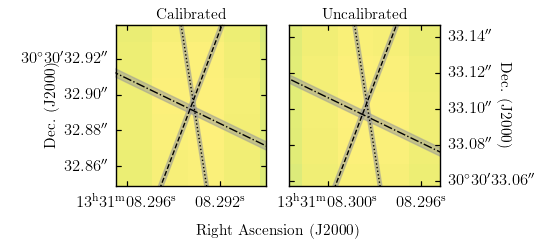

/lustre/aoc/users/nthyagar/projects/CPhaseGeom/figures/3C286_all_fringes_fitted_NPC_zoomed.pdf
/lustre/aoc/users/nthyagar/projects/CPhaseGeom/figures/3C286_all_fringes_fitted_NPC_zoomed.pdf


In [85]:
nsigma = 2

fname = '0913.fits'
wcs = WCS(imghdrs[fname]).celestial
center = wcs.all_world2pix(NP.asarray([wcs.wcs.crval[0], wcs.wcs.crval[1]]).reshape(-1,2), 0)

calstrings = ['cal', 'uncal', 'blerr']
caltexts = ['Calibrated', 'Uncalibrated', 'Baseline-based\nphase error']

ls = ['--', '-.', ':']

fig, axs = PLT.subplots(nrows=1, ncols=2, squeeze=True, sharex=True, sharey=True, subplot_kw={'projection': wcs, 'aspect': 'equal'}, figsize=(4.5,2.4))
for calind,calkey in enumerate(['cal', 'uncal']):
    fname = imgfilenames['triad-fringes'][calkey]
    data = imgdata[fname].squeeze()
    axs[calind].imshow(data, origin='lower', cmap='viridis', interpolation='none', alpha=0.6)
#     axs[calind].pcolorfast((lvect_data-0.5*dl_data)/1e-6, (mvect_data-0.5*dm_data)/1e-6, data[:-1,:-1].real, cmap='viridis', alpha=0.6)
    axs[calind].text(0.5, 1.01, caltexts[calind], transform=axs[calind].transAxes, ha='center', va='bottom', fontsize=11, color='black', backgroundcolor='none')
    for fnamej, fn in enumerate(imgfilenames['bl-fringes'][calkey]):
        xvals = fringe_NPC_info[calkey][fn]['xvals']
        yvals = fringe_NPC_info[calkey][fn]['yvals']
        axs[calind].plot(xvals[::-1], yvals, color='black', ls=ls[fnamej])
        axs[calind].set_xlim(0, data.shape[1])
        axs[calind].set_ylim(0, data.shape[0])
        lon = axs[calind].coords[0]
        lat = axs[calind].coords[1]
        lon.set_major_formatter('hh:mm:ss.s')
        lat.set_major_formatter('dd:mm:ss.s')
        lon.set_separator((r'$^\mathrm{h}$', r'$^\mathrm{m}$', r'$^\mathrm{s}$'))
        lat.set_separator((r'$^\circ$', r'$^\prime$', r'$^{\prime\prime}$'))    
        if calind > 0:
            lat.set_ticklabel_visible(False)
    axs[calind].set_xlim(0, data.shape[1])
    axs[calind].set_ylim(0, data.shape[0])

fig.subplots_adjust(hspace=0, wspace=0)
fig.subplots_adjust(left=0.22, right=0.98, bottom=0.15, top=0.98)

big_ax = fig.add_subplot(111)
big_ax.set_facecolor('none') # matplotlib.__version__ >= 2.0.0
# big_ax.set_axis_bgcolor('none') # matplotlib.__version__ < 2.0.0
big_ax.spines['right'].set_visible(False)
big_ax.spines['top'].set_visible(False)
big_ax.spines['left'].set_visible(False)
big_ax.spines['bottom'].set_visible(False)
big_ax.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
big_ax.set_xticks([])
big_ax.set_yticks([])
big_ax.set_xlabel('Right Ascension (J2000)', fontsize=11, weight='medium', labelpad=10)
big_ax.set_ylabel('Declination (J2000)', fontsize=11, weight='medium', labelpad=40)

PLT.savefig(figdir+'3C286_all_fringes_fitted_NPC.pdf', bbox_inches=0)
print(figdir+'3C286_all_fringes_fitted_NPC.pdf')

fig, axs = PLT.subplots(nrows=1, ncols=2, squeeze=True, sharex=False, sharey=False, subplot_kw={'projection': wcs, 'aspect': 'equal'}, figsize=(5.5,2.4))
for calind,calkey in enumerate(['cal', 'uncal']):
    fname = imgfilenames['triad-fringes'][calkey]
    data = imgdata[fname].squeeze()
    axs[calind].imshow(data, origin='lower', cmap='viridis', interpolation='none', alpha=0.6)
#     axs[calind].pcolorfast((lvect_data-0.5*dl_data)/1e-6, (mvect_data-0.5*dm_data)/1e-6, data[:-1,:-1].real, cmap='viridis', alpha=0.6)
    axs[calind].text(0.5, 1.01, caltexts[calind], transform=axs[calind].transAxes, ha='center', va='bottom', fontsize=11, color='black', backgroundcolor='none')
    for fnamej, fn in enumerate(imgfilenames['bl-fringes'][calkey]):
        xvals = fringe_NPC_info[calkey][fn]['xvals']
        yvals = fringe_NPC_info[calkey][fn]['yvals']
        yvals_lim1_1sigma = fringe_NPC_info[calkey][fn]['yvals_lim1']
        yvals_lim2_1sigma = fringe_NPC_info[calkey][fn]['yvals_lim2']
        yvals_lim1_nsigma = yvals + nsigma * (yvals_lim1_1sigma - yvals)
        yvals_lim2_nsigma = yvals + nsigma * (yvals_lim2_1sigma - yvals)
        axs[calind].plot(xvals[::-1], yvals, color='black', ls=ls[fnamej], lw=1)
#         axs[calind].fill_between(xvals[::-1], yvals_lim1_1sigma, yvals_lim2_1sigma, color='0.6', alpha=0.5)
        axs[calind].fill_between(xvals[::-1], yvals_lim1_nsigma, yvals_lim2_nsigma, color='0.6', alpha=0.5)
        lon = axs[calind].coords[0]
        lat = axs[calind].coords[1]
        lon.set_major_formatter('hh:mm:ss.sss')
        lat.set_major_formatter('dd:mm:ss.ss')
        lon.set_separator((r'$^\mathrm{h}$', r'$^\mathrm{m}$', r'$^\mathrm{s}$'))
        lat.set_separator((r'$^\circ$', r'$^\prime$', r'$^{\prime\prime}$'))
        axs[calind].set_aspect('equal')

    if calind == 0: 
        axs[calind].set_xlim(58.5, 62.7)
        axs[calind].set_ylim(58.5, 63)
        lon.set_ticks(number=2)
        lat.set_ticks(number=4)
        lat.set_ticklabel_position('l')
        lat.set_axislabel_position('l')
        lon.set_ticks(spacing=0.06*U.arcsec)
        lat.set_ticks(spacing=0.02*U.arcsec)
        lon.set_ticklabel(exclude_overlapping=True)
        lat.set_ticklabel(exclude_overlapping=True)
        axs[calind].tick_params(bottom=True, top=True, left=True, right=True)
        axs[calind].set_ylabel('Dec. (J2000)', fontsize=11, weight='medium', labelpad=-2)
        axs[calind].yaxis.set_label_position('left')
    else:
        axs[calind].set_xlim(55.15, 59.35)
        axs[calind].set_ylim(68.9, 73.4)
        lat.set_ticklabel_position('r')
        lat.set_axislabel_position('r')
        lon.set_ticks(spacing=0.06*U.arcsec)
        lat.set_ticks(spacing=0.02*U.arcsec)
        lon.set_ticklabel(exclude_overlapping=True)
        lat.set_ticklabel(exclude_overlapping=True)
        axs[calind].set_ylabel('Dec. (J2000)', fontsize=11, weight='medium', labelpad=-2)
        
    fig.subplots_adjust(hspace=0, wspace=0.15)
    fig.subplots_adjust(left=0.21, right=0.8, bottom=0.17, top=0.95)

    big_ax = fig.add_subplot(111)
    big_ax.set_facecolor('none') # matplotlib.__version__ >= 2.0.0
    # big_ax.set_axis_bgcolor('none') # matplotlib.__version__ < 2.0.0
    big_ax.spines['right'].set_visible(False)
    big_ax.spines['top'].set_visible(False)
    big_ax.spines['left'].set_visible(False)
    big_ax.spines['bottom'].set_visible(False)
    big_ax.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
    big_ax.set_xticks([])
    big_ax.set_yticks([])
    big_ax.set_xlabel('Right Ascension (J2000)', fontsize=11, weight='medium', labelpad=18)
#     big_ax.set_ylabel('Declination (J2000)', fontsize=10, weight='medium', labelpad=35)
#     big_ax.set_xlabel(r'$l \quad [\times 10^{-6}]$', fontsize=10, weight='medium', labelpad=15)

    PLT.savefig(figdir+'3C286_all_fringes_fitted_NPC_zoomed.pdf', bbox_inches=0)
    print(figdir+'3C286_all_fringes_fitted_NPC_zoomed.pdf')

<IPython.core.display.Javascript object>


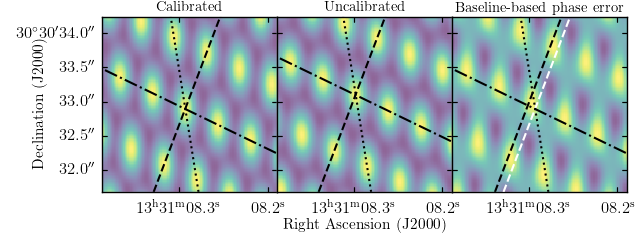

/lustre/aoc/users/nthyagar/projects/CPhaseGeom/figures/3C286_all_fringes_fitted_NPC_3panel.pdf


In [171]:
nsigma = 2

fname = '0913.fits'
wcs = WCS(imghdrs[fname]).celestial
center = wcs.all_world2pix(NP.asarray([wcs.wcs.crval[0], wcs.wcs.crval[1]]).reshape(-1,2), 0)

calstrings = ['cal', 'uncal', 'blerr']
caltexts = ['Calibrated', 'Uncalibrated', 'Baseline-based phase error']

ls = ['--', '-.', ':']

fig, axs = PLT.subplots(nrows=1, ncols=3, squeeze=True, sharex=True, sharey=True, subplot_kw={'projection': wcs, 'aspect': 'equal'}, figsize=(6.4,2.4))
for calind,calkey in enumerate(['cal', 'uncal', 'blerr']):
    fname = imgfilenames['triad-fringes'][calkey]
    data = imgdata[fname].squeeze()
    axs[calind].imshow(data, origin='lower', cmap='viridis', interpolation='none', alpha=0.6)
#     axs[calind].pcolorfast((lvect_data-0.5*dl_data)/1e-6, (mvect_data-0.5*dm_data)/1e-6, data[:-1,:-1].real, cmap='viridis', alpha=0.6)
    axs[calind].text(0.5, 1.01, caltexts[calind], transform=axs[calind].transAxes, ha='center', va='bottom', fontsize=10.5, color='black', backgroundcolor='none')
    for fnamej, fn in enumerate(imgfilenames['bl-fringes'][calkey]):

        if calkey == 'blerr':
            if fn == '0913cb.fits':
                xvals = fringe_NPC_info[calkey][fn]['xvals']
                yvals = fringe_NPC_info[calkey][fn]['yvals'] 
                uncorrupted_xvals = fringe_NPC_info['cal']['0913.fits']['xvals']
                uncorrupted_yvals = fringe_NPC_info['cal']['0913.fits']['yvals']
                axs[calind].plot(uncorrupted_xvals[::-1], uncorrupted_yvals, color='white', ls=ls[fnamej])
            else:
                xvals = fringe_NPC_info['cal'][fn]['xvals']
                yvals = fringe_NPC_info['cal'][fn]['yvals']                 
        else:
            xvals = fringe_NPC_info[calkey][fn]['xvals']
            yvals = fringe_NPC_info[calkey][fn]['yvals']
        axs[calind].plot(xvals[::-1], yvals, color='black', ls=ls[fnamej])
        axs[calind].set_xlim(0, data.shape[1])
        axs[calind].set_ylim(0, data.shape[0])
        lon = axs[calind].coords[0]
        lat = axs[calind].coords[1]
        lon.set_major_formatter('hh:mm:ss.s')
        lat.set_major_formatter('dd:mm:ss.s')
        lon.set_separator((r'$^\mathrm{h}$', r'$^\mathrm{m}$', r'$^\mathrm{s}$'))
        lat.set_separator((r'$^\circ$', r'$^\prime$', r'$^{\prime\prime}$'))    
        if calind > 0:
            lat.set_ticklabel_visible(False)
    axs[calind].set_xlim(0, data.shape[1])
    axs[calind].set_ylim(0, data.shape[0])

fig.subplots_adjust(hspace=0, wspace=0)
fig.subplots_adjust(left=0.16, right=0.98, bottom=0.15, top=0.98)

big_ax = fig.add_subplot(111)
big_ax.set_facecolor('none') # matplotlib.__version__ >= 2.0.0
# big_ax.set_axis_bgcolor('none') # matplotlib.__version__ < 2.0.0
big_ax.spines['right'].set_visible(False)
big_ax.spines['top'].set_visible(False)
big_ax.spines['left'].set_visible(False)
big_ax.spines['bottom'].set_visible(False)
big_ax.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
big_ax.set_xticks([])
big_ax.set_yticks([])
big_ax.set_xlabel('Right Ascension (J2000)', fontsize=11, weight='medium', labelpad=10)
big_ax.set_ylabel('Declination (J2000)', fontsize=11, weight='medium', labelpad=40)

PLT.savefig(figdir+'3C286_all_fringes_fitted_NPC_3panel.pdf', bbox_inches=0)
print(figdir+'3C286_all_fringes_fitted_NPC_3panel.pdf')

<IPython.core.display.Javascript object>


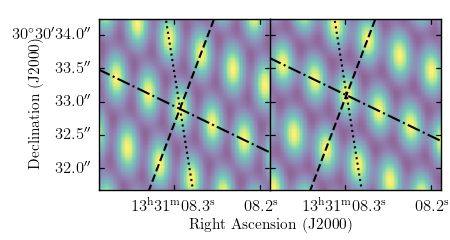

/lustre/aoc/users/nthyagar/projects/CPhaseGeom/figures/3C286_all_fringes_fitted_NPC.pdf


<IPython.core.display.Javascript object>


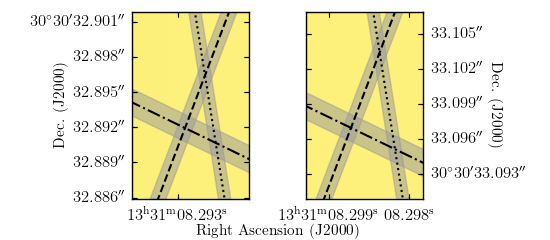

/lustre/aoc/users/nthyagar/projects/CPhaseGeom/figures/3C286_all_fringes_fitted_NPC_zoomed.pdf
/lustre/aoc/users/nthyagar/projects/CPhaseGeom/figures/3C286_all_fringes_fitted_NPC_zoomed.pdf


In [99]:
# fname = '0913.fits'
# wcs = WCS(imghdrs[fname]).celestial
# center = wcs.all_world2pix(NP.asarray([wcs.wcs.crval[0], wcs.wcs.crval[1]]).reshape(-1,2), 0)

# ls = ['--', '-.', ':']

# fig, axs = PLT.subplots(nrows=1, ncols=2, squeeze=True, sharex=True, sharey=True, subplot_kw={'projection': wcs, 'aspect': 'equal'}, figsize=(4.5,2.4))
# for calind,calkey in enumerate(['cal', 'uncal']):
#     fname = imgfilenames['triad-fringes'][calkey]
#     data = imgdata[fname].squeeze()
#     axs[calind].imshow(data, origin='lower', cmap='viridis', interpolation='none', alpha=0.6)
# #     axs[calind].pcolorfast((lvect_data-0.5*dl_data)/1e-6, (mvect_data-0.5*dm_data)/1e-6, data[:-1,:-1].real, cmap='viridis', alpha=0.6)
#     for fnamej, fn in enumerate(imgfilenames['bl-fringes'][calkey]):
#         xvals = fringe_NPC_info[calkey][fn]['xvals']
#         yvals = fringe_NPC_info[calkey][fn]['yvals']
#         axs[calind].plot(xvals[::-1], yvals, color='black', ls=ls[fnamej])
#         axs[calind].set_xlim(0, data.shape[1])
#         axs[calind].set_ylim(0, data.shape[0])
#         lon = axs[calind].coords[0]
#         lat = axs[calind].coords[1]
#         lon.set_major_formatter('hh:mm:ss.s')
#         lat.set_major_formatter('dd:mm:ss.s')
#         lon.set_separator((r'$^\mathrm{h}$', r'$^\mathrm{m}$', r'$^\mathrm{s}$'))
#         lat.set_separator((r'$^\circ$', r'$^\prime$', r'$^{\prime\prime}$'))    
#         if calind > 0:
#             lat.set_ticklabel_visible(False)
#     axs[calind].set_xlim(0, data.shape[1])
#     axs[calind].set_ylim(0, data.shape[0])

# fig.subplots_adjust(hspace=0, wspace=0)
# fig.subplots_adjust(left=0.22, right=0.98, bottom=0.15, top=0.98)

# big_ax = fig.add_subplot(111)
# big_ax.set_facecolor('none') # matplotlib.__version__ >= 2.0.0
# # big_ax.set_axis_bgcolor('none') # matplotlib.__version__ < 2.0.0
# big_ax.spines['right'].set_visible(False)
# big_ax.spines['top'].set_visible(False)
# big_ax.spines['left'].set_visible(False)
# big_ax.spines['bottom'].set_visible(False)
# big_ax.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
# big_ax.set_xticks([])
# big_ax.set_yticks([])
# big_ax.set_xlabel('Right Ascension (J2000)', fontsize=11, weight='medium', labelpad=10)
# big_ax.set_ylabel('Declination (J2000)', fontsize=11, weight='medium', labelpad=40)

# PLT.savefig(figdir+'3C286_all_fringes_fitted_NPC.pdf', bbox_inches=0)
# print(figdir+'3C286_all_fringes_fitted_NPC.pdf')

# fig, axs = PLT.subplots(nrows=1, ncols=2, squeeze=True, sharex=False, sharey=False, subplot_kw={'projection': wcs, 'aspect': 'equal'}, figsize=(5.5,2.4))
# for calind,calkey in enumerate(['cal', 'uncal']):
#     fname = imgfilenames['triad-fringes'][calkey]
#     data = imgdata[fname].squeeze()
#     axs[calind].imshow(data, origin='lower', cmap='viridis', interpolation='none', alpha=0.6)
# #     axs[calind].pcolorfast((lvect_data-0.5*dl_data)/1e-6, (mvect_data-0.5*dm_data)/1e-6, data[:-1,:-1].real, cmap='viridis', alpha=0.6)
#     for fnamej, fn in enumerate(imgfilenames['bl-fringes'][calkey]):
#         xvals = fringe_NPC_info[calkey][fn]['xvals']
#         yvals = fringe_NPC_info[calkey][fn]['yvals']
#         yvals_lim1 = fringe_NPC_info[calkey][fn]['yvals_lim1']
#         yvals_lim2 = fringe_NPC_info[calkey][fn]['yvals_lim2']
#         axs[calind].plot(xvals[::-1], yvals, color='black', ls=ls[fnamej])
#         axs[calind].fill_between(xvals[::-1], yvals_lim1, yvals_lim2, color='0.6', alpha=0.5)
#         lon = axs[calind].coords[0]
#         lat = axs[calind].coords[1]
#         lon.set_major_formatter('hh:mm:ss.sss')
#         lat.set_major_formatter('dd:mm:ss.sss')
#         lon.set_separator((r'$^\mathrm{h}$', r'$^\mathrm{m}$', r'$^\mathrm{s}$'))
#         lat.set_separator((r'$^\circ$', r'$^\prime$', r'$^{\prime\prime}$'))
#         axs[calind].set_aspect('equal')

#     if calind == 0: 
#         axs[calind].set_xlim(60.35, 60.85)
#         axs[calind].set_ylim(60.35, 61.15)
#         lon.set_ticks(number=2)
#         lat.set_ticks(number=4)
#         lat.set_ticklabel_position('l')
#         lat.set_axislabel_position('l')
#         lon.set_ticks(spacing=0.008*U.arcsec)
#         lat.set_ticks(spacing=0.003*U.arcsec)
#         lon.set_ticklabel(exclude_overlapping=True)
#         lat.set_ticklabel(exclude_overlapping=True)
#         axs[calind].tick_params(bottom=True, top=True, left=True, right=True)
#         axs[calind].set_ylabel('Dec. (J2000)', fontsize=11, weight='medium', labelpad=-2)
#         axs[calind].yaxis.set_label_position('left')
#     else:
#         axs[calind].set_xlim(57, 57.5)
#         axs[calind].set_ylim(70.6, 71.4)
#         lat.set_ticklabel_position('r')
#         lat.set_axislabel_position('r')
#         lon.set_ticks(spacing=0.008*U.arcsec)
#         lat.set_ticks(spacing=0.003*U.arcsec)
#         lon.set_ticklabel(exclude_overlapping=True)
#         lat.set_ticklabel(exclude_overlapping=True)
#         axs[calind].set_ylabel('Dec. (J2000)', fontsize=11, weight='medium', labelpad=-2)
        
#     fig.subplots_adjust(hspace=0, wspace=0.15)
#     fig.subplots_adjust(left=0.21, right=0.8, bottom=0.17, top=0.95)

#     big_ax = fig.add_subplot(111)
#     big_ax.set_facecolor('none') # matplotlib.__version__ >= 2.0.0
#     # big_ax.set_axis_bgcolor('none') # matplotlib.__version__ < 2.0.0
#     big_ax.spines['right'].set_visible(False)
#     big_ax.spines['top'].set_visible(False)
#     big_ax.spines['left'].set_visible(False)
#     big_ax.spines['bottom'].set_visible(False)
#     big_ax.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
#     big_ax.set_xticks([])
#     big_ax.set_yticks([])
#     big_ax.set_xlabel('Right Ascension (J2000)', fontsize=11, weight='medium', labelpad=18)
# #     big_ax.set_ylabel('Declination (J2000)', fontsize=10, weight='medium', labelpad=35)
# #     big_ax.set_xlabel(r'$l \quad [\times 10^{-6}]$', fontsize=10, weight='medium', labelpad=15)

#     PLT.savefig(figdir+'3C286_all_fringes_fitted_NPC_zoomed.pdf', bbox_inches=0)
#     print(figdir+'3C286_all_fringes_fitted_NPC_zoomed.pdf')

In [ ]:
# fname = '0913.fits'
# wcs = WCS(imghdrs[fname]).celestial
# center = wcs.all_world2pix(NP.asarray([wcs.wcs.crval[0], wcs.wcs.crval[1]]).reshape(-1,2), 0)

# ls = ['--', '-.', ':']

# fig, axs = PLT.subplots(nrows=1, ncols=2, squeeze=True, sharex=True, sharey=True, subplot_kw={'projection': wcs, 'aspect': 'equal'}, figsize=(4.5,2.4))
# for calind,calkey in enumerate(['cal', 'uncal']):
#     fname = imgfilenames['triad-fringes'][calkey]
#     data = imgdata[fname].squeeze()
#     axs[calind].imshow(data, origin='lower', cmap='viridis', interpolation='none', alpha=0.6)
# #     axs[calind].pcolorfast((lvect_data-0.5*dl_data)/1e-6, (mvect_data-0.5*dm_data)/1e-6, data[:-1,:-1].real, cmap='viridis', alpha=0.6)
#     for fnamej, fn in enumerate(imgfilenames['bl-fringes'][calkey]):
#         xvals = fringe_NPC_info[calkey][fn]['xvals']
#         yvals = fringe_NPC_info[calkey][fn]['yvals']
#         axs[calind].plot(xvals[::-1], yvals, color='black', ls=ls[fnamej])
#         axs[calind].set_xlim(0, data.shape[1])
#         axs[calind].set_ylim(0, data.shape[0])
#         lon = axs[calind].coords[0]
#         lat = axs[calind].coords[1]
#         lon.set_major_formatter('hh:mm:ss.s')
#         lat.set_major_formatter('dd:mm:ss.s')
#         lon.set_separator((r'$^\mathrm{h}$', r'$^\mathrm{m}$', r'$^\mathrm{s}$'))
#         lat.set_separator((r'$^\circ$', r'$^\prime$', r'$^{\prime\prime}$'))    
#         if calind > 0:
#             lat.set_ticklabel_visible(False)
#     axs[calind].set_xlim(0, data.shape[1])
#     axs[calind].set_ylim(0, data.shape[0])

# fig.subplots_adjust(hspace=0, wspace=0)
# fig.subplots_adjust(left=0.22, right=0.98, bottom=0.15, top=0.98)

# big_ax = fig.add_subplot(111)
# big_ax.set_facecolor('none') # matplotlib.__version__ >= 2.0.0
# # big_ax.set_axis_bgcolor('none') # matplotlib.__version__ < 2.0.0
# big_ax.spines['right'].set_visible(False)
# big_ax.spines['top'].set_visible(False)
# big_ax.spines['left'].set_visible(False)
# big_ax.spines['bottom'].set_visible(False)
# big_ax.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
# big_ax.set_xticks([])
# big_ax.set_yticks([])
# big_ax.set_xlabel('Right Ascension (J2000)', fontsize=10, weight='medium', labelpad=15)
# big_ax.set_ylabel('Declination (J2000)', fontsize=10, weight='medium', labelpad=40)

# PLT.savefig(figdir+'3C286_all_fringes_fitted_NPC.pdf', bbox_inches=0)
# print(figdir+'3C286_all_fringes_fitted_NPC.pdf')

# fig, axs = PLT.subplots(nrows=1, ncols=2, squeeze=True, sharex=False, sharey=False, subplot_kw={'projection': wcs, 'aspect': 'equal'}, figsize=(5.5,2.4))
# for calind,calkey in enumerate(['cal', 'uncal']):
#     fname = imgfilenames['triad-fringes'][calkey]
#     data = imgdata[fname].squeeze()
#     axs[calind].imshow(data, origin='lower', cmap='viridis', interpolation='none', alpha=0.6)
# #     axs[calind].pcolorfast((lvect_data-0.5*dl_data)/1e-6, (mvect_data-0.5*dm_data)/1e-6, data[:-1,:-1].real, cmap='viridis', alpha=0.6)
#     for fnamej, fn in enumerate(imgfilenames['bl-fringes'][calkey]):
#         xvals = fringe_NPC_info[calkey][fn]['xvals']
#         yvals = fringe_NPC_info[calkey][fn]['yvals']
#         yvals_lim1 = fringe_NPC_info[calkey][fn]['yvals_lim1']
#         yvals_lim2 = fringe_NPC_info[calkey][fn]['yvals_lim2']
#         axs[calind].plot(xvals[::-1], yvals, color='black', ls=ls[fnamej])
#         axs[calind].fill_between(xvals[::-1], yvals_lim1, yvals_lim2, color='0.6', alpha=0.5)
#         lon = axs[calind].coords[0]
#         lat = axs[calind].coords[1]
#         lon.set_major_formatter('hh:mm:ss.sss')
#         lat.set_major_formatter('dd:mm:ss.sss')
#         lon.set_separator((r'$^\mathrm{h}$', r'$^\mathrm{m}$', r'$^\mathrm{s}$'))
#         lat.set_separator((r'$^\circ$', r'$^\prime$', r'$^{\prime\prime}$'))
#         axs[calind].set_aspect('equal')

#     if calind == 0: 
#         axs[calind].set_xlim(60.35, 60.85)
#         axs[calind].set_ylim(60.35, 61.15)
#         lon.set_ticks(number=2)
#         lat.set_ticks(number=4)
#         lat.set_ticklabel_position('l')
#         lat.set_axislabel_position('l')
#         lon.set_ticks(spacing=0.008*U.arcsec)
#         lat.set_ticks(spacing=0.003*U.arcsec)
#         lon.set_ticklabel(exclude_overlapping=True)
#         lat.set_ticklabel(exclude_overlapping=True)
#         axs[calind].tick_params(bottom=True, top=True, left=True, right=True)
#         axs[calind].set_ylabel('Dec. (J2000)', fontsize=10, weight='medium', labelpad=-2.5)
#         axs[calind].yaxis.set_label_position('left')
#     else:
#         axs[calind].set_xlim(57, 57.5)
#         axs[calind].set_ylim(70.6, 71.4)
#         lat.set_ticklabel_position('r')
#         lat.set_axislabel_position('r')
#         lon.set_ticks(spacing=0.008*U.arcsec)
#         lat.set_ticks(spacing=0.003*U.arcsec)
#         lon.set_ticklabel(exclude_overlapping=True)
#         lat.set_ticklabel(exclude_overlapping=True)
#         axs[calind].set_ylabel('Dec. (J2000)', fontsize=10, weight='medium', labelpad=-2.75)
        
#     fig.subplots_adjust(hspace=0, wspace=0.15)
#     fig.subplots_adjust(left=0.23, right=0.78, bottom=0.15, top=0.95)

#     big_ax = fig.add_subplot(111)
#     big_ax.set_facecolor('none') # matplotlib.__version__ >= 2.0.0
#     # big_ax.set_axis_bgcolor('none') # matplotlib.__version__ < 2.0.0
#     big_ax.spines['right'].set_visible(False)
#     big_ax.spines['top'].set_visible(False)
#     big_ax.spines['left'].set_visible(False)
#     big_ax.spines['bottom'].set_visible(False)
#     big_ax.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
#     big_ax.set_xticks([])
#     big_ax.set_yticks([])
#     big_ax.set_xlabel('Right Ascension (J2000)', fontsize=10, weight='medium', labelpad=15)
# #     big_ax.set_ylabel('Declination (J2000)', fontsize=10, weight='medium', labelpad=35)
# #     big_ax.set_xlabel(r'$l \quad [\times 10^{-6}]$', fontsize=10, weight='medium', labelpad=15)

#     PLT.savefig(figdir+'3C286_all_fringes_fitted_NPC_zoomed.pdf', bbox_inches=0)
#     print(figdir+'3C286_all_fringes_fitted_NPC_zoomed.pdf')

In [100]:
print(imgfilenames['bl-fringes'][calkey])

['0913u.fits', '0919u.fits', '1319u.fits']


In [101]:
perp_distances = {}
phase_offsets = {}
phase_uncertainties = {}
for calkey in ['cal', 'uncal']:
    perp_distances[calkey] = {}
    phase_offsets[calkey] = {}
    phase_uncertainties[calkey] = {}
    for fnamei, fname in enumerate(imgfilenames['bl-fringes'][calkey]):
        perp_distances[calkey][fname] = (NP.dot(coeff_dvect_lines[calkey][fnamei,:2], points[calkey][(fnamei+1)%3,:]) - coeff_dvect_lines[calkey][fnamei,2]) / NP.sqrt(NP.sum(coeff_dvect_lines[calkey][fnamei,:2]**2)) 
        phase_offsets[calkey][fname] = NP.degrees(2*NP.pi) * perp_distances[calkey][fname] * NP.sqrt(NP.sum(uvw_data[fnamei,:2]**2)) / wl0.to('m').value * dm_data
        for fnamej, fn in enumerate(imgdata['two-fringes'][calkey]):
            if fname not in fn:
                phase_uncertainties[calkey][fname] = NP.degrees(2*NP.pi) * NP.sqrt(NP.diag(scipy_fit_output_2[calkey][fn]['covariance'])[1:3]) * NP.sqrt(NP.sum(uvw_data[fnamei,:2]**2)) / wl0.to('m').value * dm_data
    print('Perpendicular offsets:    ', perp_distances[calkey])
    print('Phase offsets:    ', phase_offsets[calkey])
    print('Phase uncertainties:    ', phase_uncertainties[calkey])
    

('Perpendicular offsets:    ', {'0913.fits': -0.1189183755201114, '0919.fits': 0.21401585372217097, '1319.fits': -0.1028309314980128})
('Phase offsets:    ', {'0913.fits': -1.623803683800333, '0919.fits': 1.7713005343709491, '1319.fits': -1.7045706000378853})
('Phase uncertainties:    ', {'0913.fits': array([0.67675017, 3.91875368]), '0919.fits': array([0.41019478, 2.37525215]), '1319.fits': array([0.82155197, 4.75723533])})
('Perpendicular offsets:    ', {'0919u.fits': 0.2082390418941301, '1319u.fits': -0.12175979090834904, '0913u.fits': -0.14542330158886005})
('Phase offsets:    ', {'0919u.fits': 1.7234887965954255, '1319u.fits': -2.018343671749612, '0913u.fits': -1.9857224907218993})
('Phase uncertainties:    ', {'0919u.fits': array([0.33469774, 2.28913751]), '1319u.fits': array([0.67034395, 4.58476202]), '0913u.fits': array([0.55219316, 3.77667948])})


In [102]:
for calkey in imgfilenames['bl-fringes']:
    imgdata['two-fringes'][calkey] = {}
    for fnamei,fname in enumerate(imgfilenames['bl-fringes'][calkey]):
        fname_next = imgfilenames['bl-fringes'][calkey][(fnamei+1)%3]
        fkey_out = '{0}+{1}'.format(fname.split('.fits')[0], fname_next.split('.fits')[0])
        print('{0} + {1} --> {2}'.format(fname, fname_next, fkey_out))
        imgdata['two-fringes'][calkey][fkey_out] = imgdata[fname] + imgdata[fname_next]

0913u.fits + 0919u.fits --> 0913u+0919u
0919u.fits + 1319u.fits --> 0919u+1319u
1319u.fits + 0913u.fits --> 1319u+0913u
0913.fits + 0919.fits --> 0913+0919
0919.fits + 1319.fits --> 0919+1319
1319.fits + 0913.fits --> 1319+0913


In [103]:
xy_blc = NP.asarray([[56, 44], [55, 38], [55, 38]])
xy_trc = NP.asarray([[77, 77], [78, 83], [78, 83]])
xy_center = NP.asarray([64.0, 64.0])
xgrid, ygrid = NP.meshgrid(NP.arange(xy_blc[0,0], xy_trc[0,0]+1), NP.arange(xy_blc[0,1], xy_trc[0,1]+1))
data_full = imgdata['two-fringes']['cal']['0913+0919'].squeeze()[:,::-1] 
data_subset = data_full[xy_blc[0,1]:xy_trc[0,1]+1, xy_blc[0,0]:xy_trc[0,0]+1]
print(data_subset.shape)
g2d_model = models.Gaussian2D(x_mean=66.5, y_mean=60.5, x_stddev=3.0, y_stddev=6.0, theta=NP.pi/2)
fitter = fitting.LevMarLSQFitter()
g2p = fitter(g2d_model, xgrid, ygrid, data_subset)
print(g2p.x_mean, g2p.y_mean, g2p.x_stddev, g2p.y_stddev, g2p.theta)
model_data = g2p(xgrid, ygrid)
print(model_data.shape)
print(g2p.param_sets)
print(g2p.parameters)

(34, 22)
(Parameter('x_mean', value=66.3998112744), Parameter('y_mean', value=60.6899053553), Parameter('x_stddev', value=4.55064231071, bounds=(1.1754943508222875e-38, None)), Parameter('y_stddev', value=7.43479850599, bounds=(1.1754943508222875e-38, None)), Parameter('theta', value=0.361612909592))
(34, 22)
[[ 9.98960471]
 [66.39981127]
 [60.68990536]
 [ 4.55064231]
 [ 7.43479851]
 [ 0.36161291]]
[ 9.98960471 66.39981127 60.68990536  4.55064231  7.43479851  0.36161291]


In [104]:
xvals = fringe_NPC_info[calkey][fname]['xvals']
yvals = fringe_NPC_info[calkey][fname]['yvals']
coords = SkyCoord.from_pixel(xvals, yvals, wcs, origin=0, mode='all')
print(xvals)
print(yvals)
print(coords)

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127]
[-357.04260859 -350.74291977 -344.44323095 -338.14354214 -331.84385332
 -325.5441645  -319.24447569 -312.94478687 -306.64509806 -300.34540924
 -294.04572042 -287.74603161 -281.44634279 -275.14665398 -268.84696516
 -262.54727634 -256.24758753 -249.94789871 -243.6482099  -237.34852108
 -231.04883226 -224.74914345 -218.44945463 -212.14976582 -205.850077
 -199.55038818 -193.25069937 -186.95101055 -180.65132174 -174.35163292
 -168.0519441  -161.75225529 -155.45256647 -149.1528776

In [105]:
cof = NP.asarray([[1.0, 0.0], [0.0, 1.0], [-0.5, 0.5]])
dv = NP.asarray([2.0, 3.0, 1.0])
dist = NP.asarray([1.0, 2.0, 1.0])
dvpm = GEOM.generate_parallel_lines_at_distance_from_line(cof, dv, dist)
print(dvpm)
print(dvpm[2] * NP.sqrt(2.0))

[[1.         3.        ]
 [1.         5.        ]
 [0.29289322 1.70710678]]
[0.41421356 2.41421356]


In [106]:
print(NP.sqrt(NP.sum(uvw_data[:,:2]**2, axis=1)))
print(wl0.to('m').value)
print(NP.sqrt(NP.sum(uvw_data[:,:2]**2, axis=1)) / wl0.to('m').value)

[12391.4795  7510.778  15042.84  ]
0.0316771405325
[391180.47 237104.03 474879.97]
